In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 828)
(657450, 8)
validation
(74368, 828)
(74368, 8)
test
(91684, 828)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:54 - loss: 2.2633 - STD: 0.0618 - MAE: 0.2231

 4/66 [>.............................] - ETA: 1s - loss: 1.6853 - STD: 0.1174 - MAE: 0.1821  

 5/66 [=>............................] - ETA: 2s - loss: 1.6285 - STD: 0.1412 - MAE: 0.1716

 6/66 [=>............................] - ETA: 2s - loss: 1.5913 - STD: 0.1592 - MAE: 0.1637

 7/66 [==>...........................] - ETA: 2s - loss: 1.5592 - STD: 0.1724 - MAE: 0.1577

 8/66 [==>...........................] - ETA: 2s - loss: 1.5370 - STD: 0.1816 - MAE: 0.1536

 9/66 [===>..........................] - ETA: 3s - loss: 1.5162 - STD: 0.1876 - MAE: 0.1508

10/66 [===>..........................] - ETA: 3s - loss: 1.4997 - STD: 0.1910 - MAE: 0.1491

11/66 [====>.........................] - ETA: 3s - loss: 1.4836 - STD: 0.1923 - MAE: 0.1483

12/66 [====>.........................] - ETA: 3s - loss: 1.4700 - STD: 0.1920 - MAE: 0.1481

13/66 [====>.........................] - ETA: 7s - loss: 1.4618 - STD: 0.1909 - MAE: 0.1483

16/66 [======>.......................] - ETA: 5s - loss: 1.4396 - STD: 0.1870 - MAE: 0.1495

18/66 [=======>......................] - ETA: 5s - loss: 1.4276 - STD: 0.1860 - MAE: 0.1497

19/66 [=======>......................] - ETA: 4s - loss: 1.4217 - STD: 0.1861 - MAE: 0.1495

20/66 [========>.....................] - ETA: 4s - loss: 1.4168 - STD: 0.1866 - MAE: 0.1492

21/66 [========>.....................] - ETA: 4s - loss: 1.4101 - STD: 0.1873 - MAE: 0.1487

22/66 [=========>....................] - ETA: 4s - loss: 1.4066 - STD: 0.1882 - MAE: 0.1484

23/66 [=========>....................] - ETA: 4s - loss: 1.4026 - STD: 0.1892 - MAE: 0.1479

24/66 [=========>....................] - ETA: 4s - loss: 1.3995 - STD: 0.1901 - MAE: 0.1475

25/66 [==========>...................] - ETA: 3s - loss: 1.3964 - STD: 0.1910 - MAE: 0.1471

26/66 [==========>...................] - ETA: 3s - loss: 1.3937 - STD: 0.1917 - MAE: 0.1468

27/66 [===========>..................] - ETA: 3s - loss: 1.3901 - STD: 0.1922 - MAE: 0.1465

28/66 [===========>..................] - ETA: 3s - loss: 1.3876 - STD: 0.1925 - MAE: 0.1463

29/66 [============>.................] - ETA: 3s - loss: 1.3854 - STD: 0.1926 - MAE: 0.1463

30/66 [============>.................] - ETA: 3s - loss: 1.3826 - STD: 0.1925 - MAE: 0.1462

31/66 [=============>................] - ETA: 3s - loss: 1.3797 - STD: 0.1923 - MAE: 0.1462

32/66 [=============>................] - ETA: 2s - loss: 1.3773 - STD: 0.1921 - MAE: 0.1463

33/66 [==============>...............] - ETA: 2s - loss: 1.3757 - STD: 0.1917 - MAE: 0.1464

34/66 [==============>...............] - ETA: 2s - loss: 1.3737 - STD: 0.1914 - MAE: 0.1465

35/66 [==============>...............] - ETA: 2s - loss: 1.3725 - STD: 0.1912 - MAE: 0.1466

36/66 [===============>..............] - ETA: 2s - loss: 1.3712 - STD: 0.1909 - MAE: 0.1466

37/66 [===============>..............] - ETA: 2s - loss: 1.3692 - STD: 0.1908 - MAE: 0.1466

38/66 [================>.............] - ETA: 2s - loss: 1.3681 - STD: 0.1907 - MAE: 0.1466

39/66 [================>.............] - ETA: 2s - loss: 1.3667 - STD: 0.1907 - MAE: 0.1466

40/66 [=================>............] - ETA: 2s - loss: 1.3653 - STD: 0.1908 - MAE: 0.1466

41/66 [=================>............] - ETA: 2s - loss: 1.3640 - STD: 0.1909 - MAE: 0.1465

42/66 [==================>...........] - ETA: 1s - loss: 1.3628 - STD: 0.1911 - MAE: 0.1464

43/66 [==================>...........] - ETA: 1s - loss: 1.3619 - STD: 0.1912 - MAE: 0.1464

44/66 [===================>..........] - ETA: 1s - loss: 1.3607 - STD: 0.1914 - MAE: 0.1463

45/66 [===================>..........] - ETA: 1s - loss: 1.3595 - STD: 0.1915 - MAE: 0.1462

46/66 [===================>..........] - ETA: 1s - loss: 1.3586 - STD: 0.1916 - MAE: 0.1462

47/66 [====================>.........] - ETA: 1s - loss: 1.3571 - STD: 0.1916 - MAE: 0.1461

48/66 [====================>.........] - ETA: 1s - loss: 1.3558 - STD: 0.1916 - MAE: 0.1461

49/66 [=====================>........] - ETA: 1s - loss: 1.3549 - STD: 0.1916 - MAE: 0.1461

50/66 [=====================>........] - ETA: 1s - loss: 1.3536 - STD: 0.1915 - MAE: 0.1461

51/66 [======================>.......] - ETA: 1s - loss: 1.3525 - STD: 0.1915 - MAE: 0.1460

52/66 [======================>.......] - ETA: 1s - loss: 1.3516 - STD: 0.1915 - MAE: 0.1460

53/66 [=======================>......] - ETA: 1s - loss: 1.3507 - STD: 0.1914 - MAE: 0.1460

54/66 [=======================>......] - ETA: 0s - loss: 1.3497 - STD: 0.1914 - MAE: 0.1460

55/66 [========================>.....] - ETA: 0s - loss: 1.3494 - STD: 0.1914 - MAE: 0.1460

56/66 [========================>.....] - ETA: 0s - loss: 1.3486 - STD: 0.1915 - MAE: 0.1460

57/66 [========================>.....] - ETA: 0s - loss: 1.3483 - STD: 0.1915 - MAE: 0.1460

58/66 [=========================>....] - ETA: 0s - loss: 1.3478 - STD: 0.1915 - MAE: 0.1460

59/66 [=========================>....] - ETA: 0s - loss: 1.3474 - STD: 0.1916 - MAE: 0.1460

60/66 [==========================>...] - ETA: 0s - loss: 1.3470 - STD: 0.1916 - MAE: 0.1459

61/66 [==========================>...] - ETA: 0s - loss: 1.3464 - STD: 0.1916 - MAE: 0.1459

62/66 [===========================>..] - ETA: 0s - loss: 1.3457 - STD: 0.1916 - MAE: 0.1459

63/66 [===========================>..] - ETA: 0s - loss: 1.3451 - STD: 0.1916 - MAE: 0.1459

64/66 [============================>.] - ETA: 0s - loss: 1.3447 - STD: 0.1915 - MAE: 0.1459

65/66 [============================>.] - ETA: 0s - loss: 1.3440 - STD: 0.1915 - MAE: 0.1459

66/66 [==============================] - ETA: 0s - loss: 1.3433 - STD: 0.1915 - MAE: 0.1459

66/66 [==============================] - 8s 89ms/step - loss: 1.3433 - STD: 0.1915 - MAE: 0.1459 - val_loss: 1.2450 - val_STD: 0.1907 - val_MAE: 0.1423


Epoch 2/10000


 1/66 [..............................] - ETA: 6s - loss: 1.2854 - STD: 0.1907 - MAE: 0.1442

 2/66 [..............................] - ETA: 4s - loss: 1.2931 - STD: 0.1912 - MAE: 0.1444

 3/66 [>.............................] - ETA: 4s - loss: 1.2986 - STD: 0.1918 - MAE: 0.1444

 4/66 [>.............................] - ETA: 4s - loss: 1.3016 - STD: 0.1923 - MAE: 0.1443

 5/66 [=>............................] - ETA: 4s - loss: 1.3048 - STD: 0.1927 - MAE: 0.1444

 6/66 [=>............................] - ETA: 4s - loss: 1.3034 - STD: 0.1931 - MAE: 0.1442

 7/66 [==>...........................] - ETA: 3s - loss: 1.3056 - STD: 0.1933 - MAE: 0.1442

 8/66 [==>...........................] - ETA: 3s - loss: 1.3055 - STD: 0.1934 - MAE: 0.1442

 9/66 [===>..........................] - ETA: 3s - loss: 1.3070 - STD: 0.1933 - MAE: 0.1443

10/66 [===>..........................] - ETA: 3s - loss: 1.3067 - STD: 0.1932 - MAE: 0.1444

11/66 [====>.........................] - ETA: 3s - loss: 1.3058 - STD: 0.1930 - MAE: 0.1444

13/66 [====>.........................] - ETA: 3s - loss: 1.3058 - STD: 0.1925 - MAE: 0.1446

14/66 [=====>........................] - ETA: 3s - loss: 1.3061 - STD: 0.1923 - MAE: 0.1447

15/66 [=====>........................] - ETA: 3s - loss: 1.3064 - STD: 0.1921 - MAE: 0.1448

16/66 [======>.......................] - ETA: 3s - loss: 1.3056 - STD: 0.1920 - MAE: 0.1448

17/66 [======>.......................] - ETA: 3s - loss: 1.3058 - STD: 0.1920 - MAE: 0.1448

18/66 [=======>......................] - ETA: 3s - loss: 1.3070 - STD: 0.1920 - MAE: 0.1449

19/66 [=======>......................] - ETA: 3s - loss: 1.3068 - STD: 0.1920 - MAE: 0.1449

20/66 [========>.....................] - ETA: 3s - loss: 1.3079 - STD: 0.1921 - MAE: 0.1450

21/66 [========>.....................] - ETA: 2s - loss: 1.3074 - STD: 0.1921 - MAE: 0.1449

22/66 [=========>....................] - ETA: 2s - loss: 1.3072 - STD: 0.1921 - MAE: 0.1449

23/66 [=========>....................] - ETA: 2s - loss: 1.3068 - STD: 0.1921 - MAE: 0.1449

24/66 [=========>....................] - ETA: 2s - loss: 1.3063 - STD: 0.1921 - MAE: 0.1449

25/66 [==========>...................] - ETA: 2s - loss: 1.3063 - STD: 0.1921 - MAE: 0.1448

26/66 [==========>...................] - ETA: 2s - loss: 1.3062 - STD: 0.1921 - MAE: 0.1448

27/66 [===========>..................] - ETA: 2s - loss: 1.3070 - STD: 0.1922 - MAE: 0.1449

28/66 [===========>..................] - ETA: 2s - loss: 1.3069 - STD: 0.1922 - MAE: 0.1448

29/66 [============>.................] - ETA: 2s - loss: 1.3069 - STD: 0.1922 - MAE: 0.1448

30/66 [============>.................] - ETA: 2s - loss: 1.3068 - STD: 0.1922 - MAE: 0.1448

31/66 [=============>................] - ETA: 2s - loss: 1.3072 - STD: 0.1922 - MAE: 0.1449

32/66 [=============>................] - ETA: 2s - loss: 1.3076 - STD: 0.1922 - MAE: 0.1449

33/66 [==============>...............] - ETA: 2s - loss: 1.3075 - STD: 0.1921 - MAE: 0.1449

34/66 [==============>...............] - ETA: 2s - loss: 1.3074 - STD: 0.1921 - MAE: 0.1449

35/66 [==============>...............] - ETA: 2s - loss: 1.3077 - STD: 0.1920 - MAE: 0.1450

36/66 [===============>..............] - ETA: 1s - loss: 1.3071 - STD: 0.1920 - MAE: 0.1449

37/66 [===============>..............] - ETA: 1s - loss: 1.3070 - STD: 0.1920 - MAE: 0.1450

38/66 [================>.............] - ETA: 1s - loss: 1.3066 - STD: 0.1919 - MAE: 0.1449

39/66 [================>.............] - ETA: 1s - loss: 1.3068 - STD: 0.1919 - MAE: 0.1450

40/66 [=================>............] - ETA: 1s - loss: 1.3065 - STD: 0.1919 - MAE: 0.1449

41/66 [=================>............] - ETA: 1s - loss: 1.3064 - STD: 0.1920 - MAE: 0.1449

42/66 [==================>...........] - ETA: 1s - loss: 1.3064 - STD: 0.1920 - MAE: 0.1449

43/66 [==================>...........] - ETA: 1s - loss: 1.3060 - STD: 0.1920 - MAE: 0.1449

44/66 [===================>..........] - ETA: 1s - loss: 1.3062 - STD: 0.1920 - MAE: 0.1449

45/66 [===================>..........] - ETA: 1s - loss: 1.3064 - STD: 0.1920 - MAE: 0.1449

46/66 [===================>..........] - ETA: 1s - loss: 1.3056 - STD: 0.1920 - MAE: 0.1449

47/66 [====================>.........] - ETA: 1s - loss: 1.3052 - STD: 0.1920 - MAE: 0.1449

48/66 [====================>.........] - ETA: 1s - loss: 1.3043 - STD: 0.1920 - MAE: 0.1448

49/66 [=====================>........] - ETA: 1s - loss: 1.3045 - STD: 0.1920 - MAE: 0.1448

50/66 [=====================>........] - ETA: 1s - loss: 1.3046 - STD: 0.1920 - MAE: 0.1448

51/66 [======================>.......] - ETA: 1s - loss: 1.3043 - STD: 0.1920 - MAE: 0.1448

52/66 [======================>.......] - ETA: 0s - loss: 1.3041 - STD: 0.1920 - MAE: 0.1448

53/66 [=======================>......] - ETA: 0s - loss: 1.3036 - STD: 0.1920 - MAE: 0.1448

54/66 [=======================>......] - ETA: 0s - loss: 1.3032 - STD: 0.1919 - MAE: 0.1448

55/66 [========================>.....] - ETA: 0s - loss: 1.3032 - STD: 0.1919 - MAE: 0.1448

56/66 [========================>.....] - ETA: 0s - loss: 1.3030 - STD: 0.1919 - MAE: 0.1448

57/66 [========================>.....] - ETA: 0s - loss: 1.3027 - STD: 0.1919 - MAE: 0.1448

58/66 [=========================>....] - ETA: 0s - loss: 1.3023 - STD: 0.1920 - MAE: 0.1447

59/66 [=========================>....] - ETA: 0s - loss: 1.3020 - STD: 0.1920 - MAE: 0.1447

60/66 [==========================>...] - ETA: 0s - loss: 1.3015 - STD: 0.1920 - MAE: 0.1447

61/66 [==========================>...] - ETA: 0s - loss: 1.3011 - STD: 0.1920 - MAE: 0.1447

62/66 [===========================>..] - ETA: 0s - loss: 1.3005 - STD: 0.1920 - MAE: 0.1446

63/66 [===========================>..] - ETA: 0s - loss: 1.2996 - STD: 0.1920 - MAE: 0.1446

64/66 [============================>.] - ETA: 0s - loss: 1.2993 - STD: 0.1920 - MAE: 0.1445

65/66 [============================>.] - ETA: 0s - loss: 1.2989 - STD: 0.1921 - MAE: 0.1445

66/66 [==============================] - ETA: 0s - loss: 1.2988 - STD: 0.1922 - MAE: 0.1445

66/66 [==============================] - 5s 70ms/step - loss: 1.2988 - STD: 0.1922 - MAE: 0.1445 - val_loss: 1.1952 - val_STD: 0.1882 - val_MAE: 0.1406


Epoch 3/10000


 1/66 [..............................] - ETA: 6s - loss: 1.2703 - STD: 0.1910 - MAE: 0.1437

 2/66 [..............................] - ETA: 4s - loss: 1.2721 - STD: 0.1887 - MAE: 0.1448

 3/66 [>.............................] - ETA: 4s - loss: 1.2733 - STD: 0.1880 - MAE: 0.1451

 4/66 [>.............................] - ETA: 4s - loss: 1.2689 - STD: 0.1887 - MAE: 0.1446

 5/66 [=>............................] - ETA: 4s - loss: 1.2692 - STD: 0.1899 - MAE: 0.1441

 6/66 [=>............................] - ETA: 4s - loss: 1.2641 - STD: 0.1916 - MAE: 0.1432

 7/66 [==>...........................] - ETA: 4s - loss: 1.2605 - STD: 0.1928 - MAE: 0.1425

 8/66 [==>...........................] - ETA: 4s - loss: 1.2607 - STD: 0.1935 - MAE: 0.1423

 9/66 [===>..........................] - ETA: 4s - loss: 1.2601 - STD: 0.1935 - MAE: 0.1423

10/66 [===>..........................] - ETA: 3s - loss: 1.2597 - STD: 0.1934 - MAE: 0.1423

11/66 [====>.........................] - ETA: 3s - loss: 1.2589 - STD: 0.1935 - MAE: 0.1422

12/66 [====>.........................] - ETA: 3s - loss: 1.2572 - STD: 0.1939 - MAE: 0.1420

13/66 [====>.........................] - ETA: 3s - loss: 1.2569 - STD: 0.1945 - MAE: 0.1418

14/66 [=====>........................] - ETA: 3s - loss: 1.2552 - STD: 0.1948 - MAE: 0.1416

15/66 [=====>........................] - ETA: 3s - loss: 1.2551 - STD: 0.1950 - MAE: 0.1415

16/66 [======>.......................] - ETA: 3s - loss: 1.2538 - STD: 0.1948 - MAE: 0.1416

17/66 [======>.......................] - ETA: 3s - loss: 1.2535 - STD: 0.1947 - MAE: 0.1416

18/66 [=======>......................] - ETA: 3s - loss: 1.2511 - STD: 0.1948 - MAE: 0.1415

19/66 [=======>......................] - ETA: 3s - loss: 1.2490 - STD: 0.1951 - MAE: 0.1413

20/66 [========>.....................] - ETA: 3s - loss: 1.2480 - STD: 0.1954 - MAE: 0.1411

21/66 [========>.....................] - ETA: 3s - loss: 1.2468 - STD: 0.1955 - MAE: 0.1410

22/66 [=========>....................] - ETA: 3s - loss: 1.2458 - STD: 0.1955 - MAE: 0.1410

23/66 [=========>....................] - ETA: 3s - loss: 1.2455 - STD: 0.1957 - MAE: 0.1410

24/66 [=========>....................] - ETA: 2s - loss: 1.2433 - STD: 0.1958 - MAE: 0.1408

25/66 [==========>...................] - ETA: 2s - loss: 1.2414 - STD: 0.1961 - MAE: 0.1407

26/66 [==========>...................] - ETA: 2s - loss: 1.2411 - STD: 0.1964 - MAE: 0.1405

28/66 [===========>..................] - ETA: 2s - loss: 1.2381 - STD: 0.1962 - MAE: 0.1405

29/66 [============>.................] - ETA: 2s - loss: 1.2371 - STD: 0.1966 - MAE: 0.1403

30/66 [============>.................] - ETA: 2s - loss: 1.2356 - STD: 0.1966 - MAE: 0.1403

31/66 [=============>................] - ETA: 2s - loss: 1.2341 - STD: 0.1964 - MAE: 0.1403

32/66 [=============>................] - ETA: 2s - loss: 1.2325 - STD: 0.1966 - MAE: 0.1402

33/66 [==============>...............] - ETA: 2s - loss: 1.2315 - STD: 0.1971 - MAE: 0.1400

34/66 [==============>...............] - ETA: 2s - loss: 1.2303 - STD: 0.1972 - MAE: 0.1399

35/66 [==============>...............] - ETA: 2s - loss: 1.2295 - STD: 0.1971 - MAE: 0.1399

36/66 [===============>..............] - ETA: 2s - loss: 1.2288 - STD: 0.1973 - MAE: 0.1398

37/66 [===============>..............] - ETA: 1s - loss: 1.2278 - STD: 0.1976 - MAE: 0.1397

38/66 [================>.............] - ETA: 1s - loss: 1.2268 - STD: 0.1977 - MAE: 0.1396

39/66 [================>.............] - ETA: 1s - loss: 1.2257 - STD: 0.1976 - MAE: 0.1396

40/66 [=================>............] - ETA: 1s - loss: 1.2245 - STD: 0.1977 - MAE: 0.1396

41/66 [=================>............] - ETA: 1s - loss: 1.2237 - STD: 0.1977 - MAE: 0.1395

42/66 [==================>...........] - ETA: 1s - loss: 1.2225 - STD: 0.1978 - MAE: 0.1395

43/66 [==================>...........] - ETA: 1s - loss: 1.2216 - STD: 0.1977 - MAE: 0.1395

44/66 [===================>..........] - ETA: 1s - loss: 1.2203 - STD: 0.1978 - MAE: 0.1394

45/66 [===================>..........] - ETA: 1s - loss: 1.2194 - STD: 0.1980 - MAE: 0.1393

46/66 [===================>..........] - ETA: 1s - loss: 1.2186 - STD: 0.1981 - MAE: 0.1392

47/66 [====================>.........] - ETA: 1s - loss: 1.2182 - STD: 0.1981 - MAE: 0.1392

48/66 [====================>.........] - ETA: 1s - loss: 1.2173 - STD: 0.1983 - MAE: 0.1391

49/66 [=====================>........] - ETA: 1s - loss: 1.2165 - STD: 0.1985 - MAE: 0.1390

50/66 [=====================>........] - ETA: 1s - loss: 1.2158 - STD: 0.1985 - MAE: 0.1390

51/66 [======================>.......] - ETA: 1s - loss: 1.2147 - STD: 0.1984 - MAE: 0.1390

52/66 [======================>.......] - ETA: 0s - loss: 1.2140 - STD: 0.1985 - MAE: 0.1390

53/66 [=======================>......] - ETA: 0s - loss: 1.2133 - STD: 0.1985 - MAE: 0.1389

54/66 [=======================>......] - ETA: 0s - loss: 1.2128 - STD: 0.1985 - MAE: 0.1389

55/66 [========================>.....] - ETA: 0s - loss: 1.2125 - STD: 0.1985 - MAE: 0.1389

56/66 [========================>.....] - ETA: 0s - loss: 1.2119 - STD: 0.1986 - MAE: 0.1389

57/66 [========================>.....] - ETA: 0s - loss: 1.2115 - STD: 0.1987 - MAE: 0.1389

58/66 [=========================>....] - ETA: 0s - loss: 1.2108 - STD: 0.1986 - MAE: 0.1389

59/66 [=========================>....] - ETA: 0s - loss: 1.2102 - STD: 0.1987 - MAE: 0.1388

60/66 [==========================>...] - ETA: 0s - loss: 1.2097 - STD: 0.1988 - MAE: 0.1388

61/66 [==========================>...] - ETA: 0s - loss: 1.2090 - STD: 0.1989 - MAE: 0.1387

62/66 [===========================>..] - ETA: 0s - loss: 1.2081 - STD: 0.1989 - MAE: 0.1387

63/66 [===========================>..] - ETA: 0s - loss: 1.2076 - STD: 0.1990 - MAE: 0.1387

64/66 [============================>.] - ETA: 0s - loss: 1.2069 - STD: 0.1990 - MAE: 0.1386

65/66 [============================>.] - ETA: 0s - loss: 1.2061 - STD: 0.1990 - MAE: 0.1386

66/66 [==============================] - ETA: 0s - loss: 1.2055 - STD: 0.1990 - MAE: 0.1386

66/66 [==============================] - 5s 72ms/step - loss: 1.2055 - STD: 0.1990 - MAE: 0.1386 - val_loss: 1.0792 - val_STD: 0.1925 - val_MAE: 0.1346


Epoch 4/10000


 1/66 [..............................] - ETA: 6s - loss: 1.1577 - STD: 0.2006 - MAE: 0.1364

 2/66 [..............................] - ETA: 4s - loss: 1.1525 - STD: 0.2010 - MAE: 0.1359

 3/66 [>.............................] - ETA: 4s - loss: 1.1529 - STD: 0.2025 - MAE: 0.1355

 4/66 [>.............................] - ETA: 4s - loss: 1.1524 - STD: 0.2041 - MAE: 0.1348

 5/66 [=>............................] - ETA: 4s - loss: 1.1556 - STD: 0.2042 - MAE: 0.1349

 6/66 [=>............................] - ETA: 4s - loss: 1.1524 - STD: 0.2034 - MAE: 0.1351

 7/66 [==>...........................] - ETA: 4s - loss: 1.1529 - STD: 0.2035 - MAE: 0.1351

 8/66 [==>...........................] - ETA: 3s - loss: 1.1551 - STD: 0.2035 - MAE: 0.1352

 9/66 [===>..........................] - ETA: 3s - loss: 1.1559 - STD: 0.2027 - MAE: 0.1356

10/66 [===>..........................] - ETA: 3s - loss: 1.1554 - STD: 0.2025 - MAE: 0.1357

11/66 [====>.........................] - ETA: 3s - loss: 1.1541 - STD: 0.2028 - MAE: 0.1355

12/66 [====>.........................] - ETA: 3s - loss: 1.1532 - STD: 0.2026 - MAE: 0.1356

13/66 [====>.........................] - ETA: 3s - loss: 1.1542 - STD: 0.2026 - MAE: 0.1357

14/66 [=====>........................] - ETA: 3s - loss: 1.1534 - STD: 0.2025 - MAE: 0.1357

15/66 [=====>........................] - ETA: 3s - loss: 1.1524 - STD: 0.2025 - MAE: 0.1357

16/66 [======>.......................] - ETA: 3s - loss: 1.1523 - STD: 0.2023 - MAE: 0.1358

17/66 [======>.......................] - ETA: 3s - loss: 1.1517 - STD: 0.2023 - MAE: 0.1358

18/66 [=======>......................] - ETA: 3s - loss: 1.1504 - STD: 0.2022 - MAE: 0.1358

19/66 [=======>......................] - ETA: 3s - loss: 1.1495 - STD: 0.2023 - MAE: 0.1357

20/66 [========>.....................] - ETA: 3s - loss: 1.1489 - STD: 0.2023 - MAE: 0.1357

21/66 [========>.....................] - ETA: 3s - loss: 1.1472 - STD: 0.2022 - MAE: 0.1356

22/66 [=========>....................] - ETA: 2s - loss: 1.1461 - STD: 0.2022 - MAE: 0.1356

23/66 [=========>....................] - ETA: 2s - loss: 1.1455 - STD: 0.2025 - MAE: 0.1354

24/66 [=========>....................] - ETA: 2s - loss: 1.1446 - STD: 0.2025 - MAE: 0.1354

25/66 [==========>...................] - ETA: 2s - loss: 1.1438 - STD: 0.2024 - MAE: 0.1354

26/66 [==========>...................] - ETA: 2s - loss: 1.1427 - STD: 0.2025 - MAE: 0.1353

27/66 [===========>..................] - ETA: 2s - loss: 1.1414 - STD: 0.2024 - MAE: 0.1352

28/66 [===========>..................] - ETA: 2s - loss: 1.1404 - STD: 0.2027 - MAE: 0.1351

30/66 [============>.................] - ETA: 2s - loss: 1.1376 - STD: 0.2027 - MAE: 0.1349

31/66 [=============>................] - ETA: 2s - loss: 1.1363 - STD: 0.2029 - MAE: 0.1348

32/66 [=============>................] - ETA: 2s - loss: 1.1348 - STD: 0.2030 - MAE: 0.1347

33/66 [==============>...............] - ETA: 2s - loss: 1.1341 - STD: 0.2029 - MAE: 0.1347

34/66 [==============>...............] - ETA: 2s - loss: 1.1329 - STD: 0.2029 - MAE: 0.1346

35/66 [==============>...............] - ETA: 2s - loss: 1.1308 - STD: 0.2031 - MAE: 0.1344

36/66 [===============>..............] - ETA: 2s - loss: 1.1290 - STD: 0.2034 - MAE: 0.1342

37/66 [===============>..............] - ETA: 1s - loss: 1.1278 - STD: 0.2033 - MAE: 0.1342

38/66 [================>.............] - ETA: 1s - loss: 1.1263 - STD: 0.2034 - MAE: 0.1340

39/66 [================>.............] - ETA: 1s - loss: 1.1250 - STD: 0.2039 - MAE: 0.1338

40/66 [=================>............] - ETA: 1s - loss: 1.1235 - STD: 0.2038 - MAE: 0.1337

41/66 [=================>............] - ETA: 1s - loss: 1.1223 - STD: 0.2038 - MAE: 0.1336

42/66 [==================>...........] - ETA: 1s - loss: 1.1210 - STD: 0.2042 - MAE: 0.1334

43/66 [==================>...........] - ETA: 1s - loss: 1.1199 - STD: 0.2045 - MAE: 0.1332

44/66 [===================>..........] - ETA: 1s - loss: 1.1184 - STD: 0.2045 - MAE: 0.1331

45/66 [===================>..........] - ETA: 1s - loss: 1.1175 - STD: 0.2046 - MAE: 0.1330

46/66 [===================>..........] - ETA: 1s - loss: 1.1161 - STD: 0.2048 - MAE: 0.1329

47/66 [====================>.........] - ETA: 1s - loss: 1.1145 - STD: 0.2051 - MAE: 0.1326

48/66 [====================>.........] - ETA: 1s - loss: 1.1130 - STD: 0.2053 - MAE: 0.1325

49/66 [=====================>........] - ETA: 1s - loss: 1.1116 - STD: 0.2053 - MAE: 0.1324

50/66 [=====================>........] - ETA: 1s - loss: 1.1101 - STD: 0.2057 - MAE: 0.1322

51/66 [======================>.......] - ETA: 0s - loss: 1.1089 - STD: 0.2059 - MAE: 0.1321

52/66 [======================>.......] - ETA: 0s - loss: 1.1077 - STD: 0.2059 - MAE: 0.1320

53/66 [=======================>......] - ETA: 0s - loss: 1.1066 - STD: 0.2060 - MAE: 0.1319

54/66 [=======================>......] - ETA: 0s - loss: 1.1052 - STD: 0.2063 - MAE: 0.1317

55/66 [========================>.....] - ETA: 0s - loss: 1.1037 - STD: 0.2065 - MAE: 0.1316

56/66 [========================>.....] - ETA: 0s - loss: 1.1029 - STD: 0.2066 - MAE: 0.1315

57/66 [========================>.....] - ETA: 0s - loss: 1.1019 - STD: 0.2066 - MAE: 0.1314

58/66 [=========================>....] - ETA: 0s - loss: 1.1009 - STD: 0.2067 - MAE: 0.1313

59/66 [=========================>....] - ETA: 0s - loss: 1.0998 - STD: 0.2070 - MAE: 0.1312

60/66 [==========================>...] - ETA: 0s - loss: 1.0986 - STD: 0.2070 - MAE: 0.1311

61/66 [==========================>...] - ETA: 0s - loss: 1.0977 - STD: 0.2072 - MAE: 0.1310

62/66 [===========================>..] - ETA: 0s - loss: 1.0966 - STD: 0.2074 - MAE: 0.1308

63/66 [===========================>..] - ETA: 0s - loss: 1.0957 - STD: 0.2075 - MAE: 0.1307

64/66 [============================>.] - ETA: 0s - loss: 1.0947 - STD: 0.2075 - MAE: 0.1307

65/66 [============================>.] - ETA: 0s - loss: 1.0936 - STD: 0.2077 - MAE: 0.1305

66/66 [==============================] - ETA: 0s - loss: 1.0925 - STD: 0.2079 - MAE: 0.1304

66/66 [==============================] - 5s 70ms/step - loss: 1.0925 - STD: 0.2079 - MAE: 0.1304 - val_loss: 0.9274 - val_STD: 0.2023 - val_MAE: 0.1226


Epoch 5/10000


 1/66 [..............................] - ETA: 6s - loss: 1.0124 - STD: 0.2103 - MAE: 0.1253

 2/66 [..............................] - ETA: 4s - loss: 1.0126 - STD: 0.2156 - MAE: 0.1232

 3/66 [>.............................] - ETA: 4s - loss: 1.0182 - STD: 0.2180 - MAE: 0.1225

 4/66 [>.............................] - ETA: 4s - loss: 1.0186 - STD: 0.2148 - MAE: 0.1239

 5/66 [=>............................] - ETA: 4s - loss: 1.0189 - STD: 0.2154 - MAE: 0.1236

 6/66 [=>............................] - ETA: 4s - loss: 1.0224 - STD: 0.2180 - MAE: 0.1227

 7/66 [==>...........................] - ETA: 3s - loss: 1.0234 - STD: 0.2164 - MAE: 0.1235

 8/66 [==>...........................] - ETA: 3s - loss: 1.0231 - STD: 0.2151 - MAE: 0.1240

 9/66 [===>..........................] - ETA: 3s - loss: 1.0234 - STD: 0.2161 - MAE: 0.1236

10/66 [===>..........................] - ETA: 3s - loss: 1.0243 - STD: 0.2165 - MAE: 0.1235

11/66 [====>.........................] - ETA: 3s - loss: 1.0241 - STD: 0.2157 - MAE: 0.1238

12/66 [====>.........................] - ETA: 3s - loss: 1.0236 - STD: 0.2155 - MAE: 0.1239

13/66 [====>.........................] - ETA: 3s - loss: 1.0237 - STD: 0.2162 - MAE: 0.1236

14/66 [=====>........................] - ETA: 3s - loss: 1.0250 - STD: 0.2165 - MAE: 0.1235

15/66 [=====>........................] - ETA: 3s - loss: 1.0250 - STD: 0.2155 - MAE: 0.1239

16/66 [======>.......................] - ETA: 3s - loss: 1.0244 - STD: 0.2155 - MAE: 0.1239

17/66 [======>.......................] - ETA: 3s - loss: 1.0240 - STD: 0.2161 - MAE: 0.1237

18/66 [=======>......................] - ETA: 3s - loss: 1.0227 - STD: 0.2161 - MAE: 0.1236

19/66 [=======>......................] - ETA: 3s - loss: 1.0222 - STD: 0.2159 - MAE: 0.1237

20/66 [========>.....................] - ETA: 3s - loss: 1.0211 - STD: 0.2160 - MAE: 0.1236

21/66 [========>.....................] - ETA: 3s - loss: 1.0202 - STD: 0.2162 - MAE: 0.1235

22/66 [=========>....................] - ETA: 2s - loss: 1.0202 - STD: 0.2163 - MAE: 0.1235

23/66 [=========>....................] - ETA: 2s - loss: 1.0196 - STD: 0.2161 - MAE: 0.1235

24/66 [=========>....................] - ETA: 2s - loss: 1.0184 - STD: 0.2163 - MAE: 0.1234

25/66 [==========>...................] - ETA: 2s - loss: 1.0182 - STD: 0.2167 - MAE: 0.1232

26/66 [==========>...................] - ETA: 2s - loss: 1.0175 - STD: 0.2165 - MAE: 0.1233

27/66 [===========>..................] - ETA: 2s - loss: 1.0174 - STD: 0.2163 - MAE: 0.1234

28/66 [===========>..................] - ETA: 2s - loss: 1.0170 - STD: 0.2166 - MAE: 0.1232

29/66 [============>.................] - ETA: 2s - loss: 1.0162 - STD: 0.2168 - MAE: 0.1231

30/66 [============>.................] - ETA: 2s - loss: 1.0161 - STD: 0.2167 - MAE: 0.1231

31/66 [=============>................] - ETA: 2s - loss: 1.0155 - STD: 0.2165 - MAE: 0.1232

32/66 [=============>................] - ETA: 2s - loss: 1.0146 - STD: 0.2167 - MAE: 0.1231

33/66 [==============>...............] - ETA: 2s - loss: 1.0139 - STD: 0.2170 - MAE: 0.1229

34/66 [==============>...............] - ETA: 2s - loss: 1.0137 - STD: 0.2170 - MAE: 0.1229

35/66 [==============>...............] - ETA: 2s - loss: 1.0130 - STD: 0.2168 - MAE: 0.1230

36/66 [===============>..............] - ETA: 2s - loss: 1.0120 - STD: 0.2169 - MAE: 0.1228

37/66 [===============>..............] - ETA: 1s - loss: 1.0115 - STD: 0.2173 - MAE: 0.1227

38/66 [================>.............] - ETA: 1s - loss: 1.0110 - STD: 0.2172 - MAE: 0.1227

39/66 [================>.............] - ETA: 1s - loss: 1.0104 - STD: 0.2171 - MAE: 0.1227

40/66 [=================>............] - ETA: 1s - loss: 1.0093 - STD: 0.2171 - MAE: 0.1226

41/66 [=================>............] - ETA: 1s - loss: 1.0087 - STD: 0.2174 - MAE: 0.1224

42/66 [==================>...........] - ETA: 1s - loss: 1.0083 - STD: 0.2175 - MAE: 0.1224

43/66 [==================>...........] - ETA: 1s - loss: 1.0078 - STD: 0.2173 - MAE: 0.1225

44/66 [===================>..........] - ETA: 1s - loss: 1.0070 - STD: 0.2173 - MAE: 0.1224

45/66 [===================>..........] - ETA: 1s - loss: 1.0065 - STD: 0.2176 - MAE: 0.1223

46/66 [===================>..........] - ETA: 1s - loss: 1.0054 - STD: 0.2178 - MAE: 0.1222

47/66 [====================>.........] - ETA: 1s - loss: 1.0050 - STD: 0.2177 - MAE: 0.1222

48/66 [====================>.........] - ETA: 1s - loss: 1.0043 - STD: 0.2176 - MAE: 0.1222

49/66 [=====================>........] - ETA: 1s - loss: 1.0035 - STD: 0.2178 - MAE: 0.1221

50/66 [=====================>........] - ETA: 1s - loss: 1.0028 - STD: 0.2181 - MAE: 0.1219

52/66 [======================>.......] - ETA: 0s - loss: 1.0022 - STD: 0.2178 - MAE: 0.1220

53/66 [=======================>......] - ETA: 0s - loss: 1.0016 - STD: 0.2178 - MAE: 0.1220

54/66 [=======================>......] - ETA: 0s - loss: 1.0009 - STD: 0.2182 - MAE: 0.1218

55/66 [========================>.....] - ETA: 0s - loss: 1.0005 - STD: 0.2183 - MAE: 0.1217

56/66 [========================>.....] - ETA: 0s - loss: 0.9998 - STD: 0.2181 - MAE: 0.1218

57/66 [========================>.....] - ETA: 0s - loss: 0.9991 - STD: 0.2181 - MAE: 0.1217

58/66 [=========================>....] - ETA: 0s - loss: 0.9983 - STD: 0.2184 - MAE: 0.1216

59/66 [=========================>....] - ETA: 0s - loss: 0.9976 - STD: 0.2186 - MAE: 0.1215

60/66 [==========================>...] - ETA: 0s - loss: 0.9968 - STD: 0.2185 - MAE: 0.1214

61/66 [==========================>...] - ETA: 0s - loss: 0.9963 - STD: 0.2185 - MAE: 0.1215

62/66 [===========================>..] - ETA: 0s - loss: 0.9955 - STD: 0.2186 - MAE: 0.1214

63/66 [===========================>..] - ETA: 0s - loss: 0.9950 - STD: 0.2188 - MAE: 0.1213

64/66 [============================>.] - ETA: 0s - loss: 0.9944 - STD: 0.2188 - MAE: 0.1212

65/66 [============================>.] - ETA: 0s - loss: 0.9938 - STD: 0.2188 - MAE: 0.1212

66/66 [==============================] - ETA: 0s - loss: 0.9931 - STD: 0.2188 - MAE: 0.1212

66/66 [==============================] - 5s 71ms/step - loss: 0.9931 - STD: 0.2188 - MAE: 0.1212 - val_loss: 0.8602 - val_STD: 0.2211 - val_MAE: 0.1116


Epoch 6/10000


 1/66 [..............................] - ETA: 6s - loss: 0.9672 - STD: 0.2287 - MAE: 0.1159

 2/66 [..............................] - ETA: 4s - loss: 0.9534 - STD: 0.2274 - MAE: 0.1157

 3/66 [>.............................] - ETA: 4s - loss: 0.9528 - STD: 0.2246 - MAE: 0.1169

 4/66 [>.............................] - ETA: 4s - loss: 0.9539 - STD: 0.2241 - MAE: 0.1172

 5/66 [=>............................] - ETA: 4s - loss: 0.9536 - STD: 0.2245 - MAE: 0.1170

 6/66 [=>............................] - ETA: 4s - loss: 0.9519 - STD: 0.2243 - MAE: 0.1170

 7/66 [==>...........................] - ETA: 4s - loss: 0.9483 - STD: 0.2241 - MAE: 0.1169

 8/66 [==>...........................] - ETA: 3s - loss: 0.9471 - STD: 0.2239 - MAE: 0.1170

 9/66 [===>..........................] - ETA: 3s - loss: 0.9463 - STD: 0.2240 - MAE: 0.1169

10/66 [===>..........................] - ETA: 3s - loss: 0.9456 - STD: 0.2241 - MAE: 0.1168

11/66 [====>.........................] - ETA: 3s - loss: 0.9457 - STD: 0.2242 - MAE: 0.1168

12/66 [====>.........................] - ETA: 3s - loss: 0.9458 - STD: 0.2240 - MAE: 0.1170

13/66 [====>.........................] - ETA: 3s - loss: 0.9446 - STD: 0.2240 - MAE: 0.1169

14/66 [=====>........................] - ETA: 3s - loss: 0.9431 - STD: 0.2246 - MAE: 0.1166

15/66 [=====>........................] - ETA: 3s - loss: 0.9429 - STD: 0.2247 - MAE: 0.1165

16/66 [======>.......................] - ETA: 3s - loss: 0.9420 - STD: 0.2243 - MAE: 0.1167

17/66 [======>.......................] - ETA: 3s - loss: 0.9414 - STD: 0.2241 - MAE: 0.1167

18/66 [=======>......................] - ETA: 3s - loss: 0.9414 - STD: 0.2245 - MAE: 0.1166

19/66 [=======>......................] - ETA: 3s - loss: 0.9402 - STD: 0.2247 - MAE: 0.1164

21/66 [========>.....................] - ETA: 3s - loss: 0.9386 - STD: 0.2245 - MAE: 0.1164

22/66 [=========>....................] - ETA: 2s - loss: 0.9382 - STD: 0.2246 - MAE: 0.1164

23/66 [=========>....................] - ETA: 2s - loss: 0.9376 - STD: 0.2247 - MAE: 0.1163

24/66 [=========>....................] - ETA: 2s - loss: 0.9373 - STD: 0.2246 - MAE: 0.1163

25/66 [==========>...................] - ETA: 2s - loss: 0.9366 - STD: 0.2247 - MAE: 0.1163

26/66 [==========>...................] - ETA: 2s - loss: 0.9355 - STD: 0.2248 - MAE: 0.1162

27/66 [===========>..................] - ETA: 2s - loss: 0.9348 - STD: 0.2250 - MAE: 0.1160

28/66 [===========>..................] - ETA: 2s - loss: 0.9343 - STD: 0.2250 - MAE: 0.1160

29/66 [============>.................] - ETA: 2s - loss: 0.9334 - STD: 0.2251 - MAE: 0.1160

30/66 [============>.................] - ETA: 2s - loss: 0.9327 - STD: 0.2252 - MAE: 0.1159

31/66 [=============>................] - ETA: 2s - loss: 0.9317 - STD: 0.2253 - MAE: 0.1158

32/66 [=============>................] - ETA: 2s - loss: 0.9312 - STD: 0.2253 - MAE: 0.1157

33/66 [==============>...............] - ETA: 2s - loss: 0.9304 - STD: 0.2254 - MAE: 0.1157

34/66 [==============>...............] - ETA: 2s - loss: 0.9297 - STD: 0.2254 - MAE: 0.1156

35/66 [==============>...............] - ETA: 2s - loss: 0.9292 - STD: 0.2256 - MAE: 0.1156

36/66 [===============>..............] - ETA: 2s - loss: 0.9285 - STD: 0.2256 - MAE: 0.1155

37/66 [===============>..............] - ETA: 1s - loss: 0.9283 - STD: 0.2255 - MAE: 0.1155

38/66 [================>.............] - ETA: 1s - loss: 0.9278 - STD: 0.2256 - MAE: 0.1155

39/66 [================>.............] - ETA: 1s - loss: 0.9272 - STD: 0.2256 - MAE: 0.1155

40/66 [=================>............] - ETA: 1s - loss: 0.9265 - STD: 0.2257 - MAE: 0.1154

41/66 [=================>............] - ETA: 1s - loss: 0.9263 - STD: 0.2258 - MAE: 0.1154

42/66 [==================>...........] - ETA: 1s - loss: 0.9256 - STD: 0.2257 - MAE: 0.1154

43/66 [==================>...........] - ETA: 1s - loss: 0.9247 - STD: 0.2258 - MAE: 0.1153

44/66 [===================>..........] - ETA: 1s - loss: 0.9244 - STD: 0.2260 - MAE: 0.1152

45/66 [===================>..........] - ETA: 1s - loss: 0.9239 - STD: 0.2259 - MAE: 0.1152

46/66 [===================>..........] - ETA: 1s - loss: 0.9234 - STD: 0.2258 - MAE: 0.1152

47/66 [====================>.........] - ETA: 1s - loss: 0.9229 - STD: 0.2260 - MAE: 0.1152

48/66 [====================>.........] - ETA: 1s - loss: 0.9224 - STD: 0.2261 - MAE: 0.1151

49/66 [=====================>........] - ETA: 1s - loss: 0.9222 - STD: 0.2261 - MAE: 0.1151

50/66 [=====================>........] - ETA: 1s - loss: 0.9217 - STD: 0.2261 - MAE: 0.1151

51/66 [======================>.......] - ETA: 0s - loss: 0.9211 - STD: 0.2261 - MAE: 0.1151

52/66 [======================>.......] - ETA: 0s - loss: 0.9206 - STD: 0.2262 - MAE: 0.1150

53/66 [=======================>......] - ETA: 0s - loss: 0.9202 - STD: 0.2262 - MAE: 0.1150

54/66 [=======================>......] - ETA: 0s - loss: 0.9200 - STD: 0.2261 - MAE: 0.1150

55/66 [========================>.....] - ETA: 0s - loss: 0.9197 - STD: 0.2262 - MAE: 0.1150

56/66 [========================>.....] - ETA: 0s - loss: 0.9195 - STD: 0.2263 - MAE: 0.1149

57/66 [========================>.....] - ETA: 0s - loss: 0.9191 - STD: 0.2263 - MAE: 0.1149

58/66 [=========================>....] - ETA: 0s - loss: 0.9187 - STD: 0.2262 - MAE: 0.1149

59/66 [=========================>....] - ETA: 0s - loss: 0.9190 - STD: 0.2263 - MAE: 0.1149

60/66 [==========================>...] - ETA: 0s - loss: 0.9187 - STD: 0.2263 - MAE: 0.1149

61/66 [==========================>...] - ETA: 0s - loss: 0.9184 - STD: 0.2264 - MAE: 0.1149

62/66 [===========================>..] - ETA: 0s - loss: 0.9180 - STD: 0.2264 - MAE: 0.1149

63/66 [===========================>..] - ETA: 0s - loss: 0.9177 - STD: 0.2263 - MAE: 0.1149

64/66 [============================>.] - ETA: 0s - loss: 0.9176 - STD: 0.2264 - MAE: 0.1148

65/66 [============================>.] - ETA: 0s - loss: 0.9169 - STD: 0.2265 - MAE: 0.1148

66/66 [==============================] - ETA: 0s - loss: 0.9164 - STD: 0.2265 - MAE: 0.1148

66/66 [==============================] - 5s 70ms/step - loss: 0.9164 - STD: 0.2265 - MAE: 0.1148 - val_loss: 0.8226 - val_STD: 0.2220 - val_MAE: 0.1106


Epoch 7/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8933 - STD: 0.2292 - MAE: 0.1129

 2/66 [..............................] - ETA: 4s - loss: 0.8915 - STD: 0.2301 - MAE: 0.1125

 3/66 [>.............................] - ETA: 4s - loss: 0.8904 - STD: 0.2300 - MAE: 0.1124

 4/66 [>.............................] - ETA: 4s - loss: 0.8900 - STD: 0.2287 - MAE: 0.1129

 5/66 [=>............................] - ETA: 4s - loss: 0.8853 - STD: 0.2287 - MAE: 0.1126

 6/66 [=>............................] - ETA: 4s - loss: 0.8871 - STD: 0.2299 - MAE: 0.1123

 7/66 [==>...........................] - ETA: 4s - loss: 0.8882 - STD: 0.2290 - MAE: 0.1127

 8/66 [==>...........................] - ETA: 4s - loss: 0.8887 - STD: 0.2288 - MAE: 0.1128

 9/66 [===>..........................] - ETA: 3s - loss: 0.8891 - STD: 0.2292 - MAE: 0.1127

10/66 [===>..........................] - ETA: 3s - loss: 0.8886 - STD: 0.2286 - MAE: 0.1130

11/66 [====>.........................] - ETA: 3s - loss: 0.8879 - STD: 0.2284 - MAE: 0.1130

12/66 [====>.........................] - ETA: 3s - loss: 0.8884 - STD: 0.2292 - MAE: 0.1127

13/66 [====>.........................] - ETA: 3s - loss: 0.8878 - STD: 0.2292 - MAE: 0.1127

14/66 [=====>........................] - ETA: 3s - loss: 0.8881 - STD: 0.2287 - MAE: 0.1129

15/66 [=====>........................] - ETA: 3s - loss: 0.8874 - STD: 0.2288 - MAE: 0.1128

16/66 [======>.......................] - ETA: 3s - loss: 0.8874 - STD: 0.2294 - MAE: 0.1125

17/66 [======>.......................] - ETA: 3s - loss: 0.8882 - STD: 0.2293 - MAE: 0.1126

18/66 [=======>......................] - ETA: 3s - loss: 0.8879 - STD: 0.2288 - MAE: 0.1129

19/66 [=======>......................] - ETA: 3s - loss: 0.8874 - STD: 0.2289 - MAE: 0.1128

20/66 [========>.....................] - ETA: 3s - loss: 0.8879 - STD: 0.2294 - MAE: 0.1126

21/66 [========>.....................] - ETA: 3s - loss: 0.8879 - STD: 0.2292 - MAE: 0.1127

22/66 [=========>....................] - ETA: 3s - loss: 0.8874 - STD: 0.2289 - MAE: 0.1128

23/66 [=========>....................] - ETA: 2s - loss: 0.8870 - STD: 0.2289 - MAE: 0.1128

24/66 [=========>....................] - ETA: 2s - loss: 0.8862 - STD: 0.2292 - MAE: 0.1126

25/66 [==========>...................] - ETA: 2s - loss: 0.8864 - STD: 0.2293 - MAE: 0.1126

26/66 [==========>...................] - ETA: 2s - loss: 0.8853 - STD: 0.2292 - MAE: 0.1126

27/66 [===========>..................] - ETA: 2s - loss: 0.8850 - STD: 0.2292 - MAE: 0.1126

28/66 [===========>..................] - ETA: 2s - loss: 0.8851 - STD: 0.2292 - MAE: 0.1126

29/66 [============>.................] - ETA: 2s - loss: 0.8854 - STD: 0.2291 - MAE: 0.1126

30/66 [============>.................] - ETA: 2s - loss: 0.8851 - STD: 0.2292 - MAE: 0.1126

31/66 [=============>................] - ETA: 2s - loss: 0.8852 - STD: 0.2292 - MAE: 0.1126

32/66 [=============>................] - ETA: 2s - loss: 0.8852 - STD: 0.2291 - MAE: 0.1126

33/66 [==============>...............] - ETA: 2s - loss: 0.8848 - STD: 0.2291 - MAE: 0.1126

34/66 [==============>...............] - ETA: 2s - loss: 0.8845 - STD: 0.2292 - MAE: 0.1126

35/66 [==============>...............] - ETA: 2s - loss: 0.8841 - STD: 0.2294 - MAE: 0.1125

36/66 [===============>..............] - ETA: 2s - loss: 0.8839 - STD: 0.2293 - MAE: 0.1125

37/66 [===============>..............] - ETA: 1s - loss: 0.8835 - STD: 0.2291 - MAE: 0.1126

38/66 [================>.............] - ETA: 1s - loss: 0.8833 - STD: 0.2293 - MAE: 0.1125

39/66 [================>.............] - ETA: 1s - loss: 0.8828 - STD: 0.2295 - MAE: 0.1124

40/66 [=================>............] - ETA: 1s - loss: 0.8824 - STD: 0.2294 - MAE: 0.1124

41/66 [=================>............] - ETA: 1s - loss: 0.8825 - STD: 0.2294 - MAE: 0.1124

42/66 [==================>...........] - ETA: 1s - loss: 0.8825 - STD: 0.2294 - MAE: 0.1124

43/66 [==================>...........] - ETA: 1s - loss: 0.8823 - STD: 0.2294 - MAE: 0.1124

44/66 [===================>..........] - ETA: 1s - loss: 0.8821 - STD: 0.2294 - MAE: 0.1124

45/66 [===================>..........] - ETA: 1s - loss: 0.8817 - STD: 0.2294 - MAE: 0.1124

46/66 [===================>..........] - ETA: 1s - loss: 0.8813 - STD: 0.2295 - MAE: 0.1123

47/66 [====================>.........] - ETA: 1s - loss: 0.8811 - STD: 0.2295 - MAE: 0.1123

48/66 [====================>.........] - ETA: 1s - loss: 0.8812 - STD: 0.2294 - MAE: 0.1124

49/66 [=====================>........] - ETA: 1s - loss: 0.8808 - STD: 0.2295 - MAE: 0.1123

50/66 [=====================>........] - ETA: 1s - loss: 0.8807 - STD: 0.2297 - MAE: 0.1122

51/66 [======================>.......] - ETA: 1s - loss: 0.8811 - STD: 0.2295 - MAE: 0.1123

52/66 [======================>.......] - ETA: 0s - loss: 0.8808 - STD: 0.2295 - MAE: 0.1123

53/66 [=======================>......] - ETA: 0s - loss: 0.8809 - STD: 0.2297 - MAE: 0.1122

54/66 [=======================>......] - ETA: 0s - loss: 0.8812 - STD: 0.2297 - MAE: 0.1122

55/66 [========================>.....] - ETA: 0s - loss: 0.8808 - STD: 0.2297 - MAE: 0.1122

56/66 [========================>.....] - ETA: 0s - loss: 0.8807 - STD: 0.2297 - MAE: 0.1122

57/66 [========================>.....] - ETA: 0s - loss: 0.8812 - STD: 0.2298 - MAE: 0.1122

59/66 [=========================>....] - ETA: 0s - loss: 0.8806 - STD: 0.2297 - MAE: 0.1122

60/66 [==========================>...] - ETA: 0s - loss: 0.8801 - STD: 0.2298 - MAE: 0.1121

61/66 [==========================>...] - ETA: 0s - loss: 0.8799 - STD: 0.2299 - MAE: 0.1121

62/66 [===========================>..] - ETA: 0s - loss: 0.8795 - STD: 0.2298 - MAE: 0.1121

63/66 [===========================>..] - ETA: 0s - loss: 0.8793 - STD: 0.2298 - MAE: 0.1121

64/66 [============================>.] - ETA: 0s - loss: 0.8789 - STD: 0.2298 - MAE: 0.1121

65/66 [============================>.] - ETA: 0s - loss: 0.8785 - STD: 0.2299 - MAE: 0.1120

66/66 [==============================] - ETA: 0s - loss: 0.8781 - STD: 0.2298 - MAE: 0.1120

66/66 [==============================] - 5s 71ms/step - loss: 0.8781 - STD: 0.2298 - MAE: 0.1120 - val_loss: 0.8028 - val_STD: 0.2232 - val_MAE: 0.1095


Epoch 8/10000


 1/66 [..............................] - ETA: 7s - loss: 0.8624 - STD: 0.2282 - MAE: 0.1122

 2/66 [..............................] - ETA: 4s - loss: 0.8652 - STD: 0.2300 - MAE: 0.1116

 3/66 [>.............................] - ETA: 4s - loss: 0.8604 - STD: 0.2302 - MAE: 0.1112

 4/66 [>.............................] - ETA: 4s - loss: 0.8587 - STD: 0.2302 - MAE: 0.1110

 5/66 [=>............................] - ETA: 4s - loss: 0.8590 - STD: 0.2309 - MAE: 0.1107

 6/66 [=>............................] - ETA: 4s - loss: 0.8588 - STD: 0.2310 - MAE: 0.1107

 7/66 [==>...........................] - ETA: 3s - loss: 0.8582 - STD: 0.2306 - MAE: 0.1108

 8/66 [==>...........................] - ETA: 3s - loss: 0.8597 - STD: 0.2305 - MAE: 0.1110

 9/66 [===>..........................] - ETA: 3s - loss: 0.8609 - STD: 0.2306 - MAE: 0.1110

10/66 [===>..........................] - ETA: 3s - loss: 0.8593 - STD: 0.2311 - MAE: 0.1106

11/66 [====>.........................] - ETA: 3s - loss: 0.8594 - STD: 0.2312 - MAE: 0.1106

12/66 [====>.........................] - ETA: 3s - loss: 0.8593 - STD: 0.2309 - MAE: 0.1108

13/66 [====>.........................] - ETA: 3s - loss: 0.8584 - STD: 0.2310 - MAE: 0.1107

14/66 [=====>........................] - ETA: 3s - loss: 0.8581 - STD: 0.2315 - MAE: 0.1104

15/66 [=====>........................] - ETA: 3s - loss: 0.8580 - STD: 0.2315 - MAE: 0.1104

16/66 [======>.......................] - ETA: 3s - loss: 0.8585 - STD: 0.2314 - MAE: 0.1105

17/66 [======>.......................] - ETA: 3s - loss: 0.8582 - STD: 0.2315 - MAE: 0.1104

18/66 [=======>......................] - ETA: 3s - loss: 0.8583 - STD: 0.2315 - MAE: 0.1105

19/66 [=======>......................] - ETA: 3s - loss: 0.8596 - STD: 0.2312 - MAE: 0.1107

20/66 [========>.....................] - ETA: 3s - loss: 0.8598 - STD: 0.2312 - MAE: 0.1107

21/66 [========>.....................] - ETA: 3s - loss: 0.8591 - STD: 0.2314 - MAE: 0.1106

22/66 [=========>....................] - ETA: 2s - loss: 0.8588 - STD: 0.2315 - MAE: 0.1105

23/66 [=========>....................] - ETA: 2s - loss: 0.8583 - STD: 0.2314 - MAE: 0.1106

24/66 [=========>....................] - ETA: 2s - loss: 0.8579 - STD: 0.2312 - MAE: 0.1106

25/66 [==========>...................] - ETA: 2s - loss: 0.8581 - STD: 0.2314 - MAE: 0.1106

26/66 [==========>...................] - ETA: 2s - loss: 0.8582 - STD: 0.2315 - MAE: 0.1105

27/66 [===========>..................] - ETA: 2s - loss: 0.8575 - STD: 0.2314 - MAE: 0.1105

28/66 [===========>..................] - ETA: 2s - loss: 0.8569 - STD: 0.2313 - MAE: 0.1105

29/66 [============>.................] - ETA: 2s - loss: 0.8565 - STD: 0.2314 - MAE: 0.1105

30/66 [============>.................] - ETA: 2s - loss: 0.8565 - STD: 0.2314 - MAE: 0.1105

31/66 [=============>................] - ETA: 2s - loss: 0.8566 - STD: 0.2314 - MAE: 0.1105

32/66 [=============>................] - ETA: 2s - loss: 0.8563 - STD: 0.2314 - MAE: 0.1105

33/66 [==============>...............] - ETA: 2s - loss: 0.8557 - STD: 0.2314 - MAE: 0.1104

34/66 [==============>...............] - ETA: 2s - loss: 0.8554 - STD: 0.2314 - MAE: 0.1104

35/66 [==============>...............] - ETA: 2s - loss: 0.8555 - STD: 0.2316 - MAE: 0.1103

36/66 [===============>..............] - ETA: 1s - loss: 0.8551 - STD: 0.2316 - MAE: 0.1103

37/66 [===============>..............] - ETA: 1s - loss: 0.8545 - STD: 0.2316 - MAE: 0.1103

38/66 [================>.............] - ETA: 1s - loss: 0.8541 - STD: 0.2317 - MAE: 0.1102

39/66 [================>.............] - ETA: 1s - loss: 0.8537 - STD: 0.2317 - MAE: 0.1102

40/66 [=================>............] - ETA: 1s - loss: 0.8535 - STD: 0.2317 - MAE: 0.1102

41/66 [=================>............] - ETA: 1s - loss: 0.8534 - STD: 0.2318 - MAE: 0.1102

42/66 [==================>...........] - ETA: 1s - loss: 0.8530 - STD: 0.2318 - MAE: 0.1101

43/66 [==================>...........] - ETA: 1s - loss: 0.8530 - STD: 0.2318 - MAE: 0.1101

44/66 [===================>..........] - ETA: 1s - loss: 0.8529 - STD: 0.2318 - MAE: 0.1101

45/66 [===================>..........] - ETA: 1s - loss: 0.8526 - STD: 0.2319 - MAE: 0.1101

46/66 [===================>..........] - ETA: 1s - loss: 0.8526 - STD: 0.2319 - MAE: 0.1100

47/66 [====================>.........] - ETA: 1s - loss: 0.8523 - STD: 0.2319 - MAE: 0.1100

48/66 [====================>.........] - ETA: 1s - loss: 0.8527 - STD: 0.2318 - MAE: 0.1101

49/66 [=====================>........] - ETA: 1s - loss: 0.8530 - STD: 0.2319 - MAE: 0.1101

50/66 [=====================>........] - ETA: 1s - loss: 0.8530 - STD: 0.2319 - MAE: 0.1101

51/66 [======================>.......] - ETA: 0s - loss: 0.8530 - STD: 0.2319 - MAE: 0.1101

52/66 [======================>.......] - ETA: 0s - loss: 0.8530 - STD: 0.2320 - MAE: 0.1101

53/66 [=======================>......] - ETA: 0s - loss: 0.8528 - STD: 0.2319 - MAE: 0.1101

54/66 [=======================>......] - ETA: 0s - loss: 0.8526 - STD: 0.2319 - MAE: 0.1101

55/66 [========================>.....] - ETA: 0s - loss: 0.8526 - STD: 0.2320 - MAE: 0.1100

56/66 [========================>.....] - ETA: 0s - loss: 0.8525 - STD: 0.2321 - MAE: 0.1100

57/66 [========================>.....] - ETA: 0s - loss: 0.8522 - STD: 0.2320 - MAE: 0.1100

58/66 [=========================>....] - ETA: 0s - loss: 0.8521 - STD: 0.2320 - MAE: 0.1100

59/66 [=========================>....] - ETA: 0s - loss: 0.8519 - STD: 0.2321 - MAE: 0.1100

60/66 [==========================>...] - ETA: 0s - loss: 0.8517 - STD: 0.2320 - MAE: 0.1100

62/66 [===========================>..] - ETA: 0s - loss: 0.8515 - STD: 0.2321 - MAE: 0.1100

63/66 [===========================>..] - ETA: 0s - loss: 0.8511 - STD: 0.2321 - MAE: 0.1099

64/66 [============================>.] - ETA: 0s - loss: 0.8508 - STD: 0.2320 - MAE: 0.1099

65/66 [============================>.] - ETA: 0s - loss: 0.8508 - STD: 0.2321 - MAE: 0.1099

66/66 [==============================] - ETA: 0s - loss: 0.8507 - STD: 0.2321 - MAE: 0.1099

66/66 [==============================] - 5s 69ms/step - loss: 0.8507 - STD: 0.2321 - MAE: 0.1099 - val_loss: 0.7972 - val_STD: 0.2233 - val_MAE: 0.1095


Epoch 9/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8392 - STD: 0.2292 - MAE: 0.1104

 2/66 [..............................] - ETA: 4s - loss: 0.8350 - STD: 0.2298 - MAE: 0.1101

 3/66 [>.............................] - ETA: 4s - loss: 0.8377 - STD: 0.2324 - MAE: 0.1092

 4/66 [>.............................] - ETA: 4s - loss: 0.8426 - STD: 0.2331 - MAE: 0.1091

 5/66 [=>............................] - ETA: 4s - loss: 0.8403 - STD: 0.2328 - MAE: 0.1091

 6/66 [=>............................] - ETA: 4s - loss: 0.8362 - STD: 0.2331 - MAE: 0.1087

 7/66 [==>...........................] - ETA: 4s - loss: 0.8372 - STD: 0.2333 - MAE: 0.1087

 8/66 [==>...........................] - ETA: 4s - loss: 0.8388 - STD: 0.2329 - MAE: 0.1090

 9/66 [===>..........................] - ETA: 3s - loss: 0.8395 - STD: 0.2335 - MAE: 0.1088

10/66 [===>..........................] - ETA: 3s - loss: 0.8392 - STD: 0.2332 - MAE: 0.1090

11/66 [====>.........................] - ETA: 3s - loss: 0.8389 - STD: 0.2330 - MAE: 0.1090

12/66 [====>.........................] - ETA: 3s - loss: 0.8400 - STD: 0.2332 - MAE: 0.1090

13/66 [====>.........................] - ETA: 3s - loss: 0.8387 - STD: 0.2336 - MAE: 0.1087

14/66 [=====>........................] - ETA: 3s - loss: 0.8385 - STD: 0.2335 - MAE: 0.1088

15/66 [=====>........................] - ETA: 3s - loss: 0.8379 - STD: 0.2334 - MAE: 0.1088

16/66 [======>.......................] - ETA: 3s - loss: 0.8369 - STD: 0.2335 - MAE: 0.1087

17/66 [======>.......................] - ETA: 3s - loss: 0.8382 - STD: 0.2336 - MAE: 0.1087

18/66 [=======>......................] - ETA: 3s - loss: 0.8391 - STD: 0.2336 - MAE: 0.1087

19/66 [=======>......................] - ETA: 3s - loss: 0.8396 - STD: 0.2335 - MAE: 0.1088

20/66 [========>.....................] - ETA: 3s - loss: 0.8406 - STD: 0.2337 - MAE: 0.1088

22/66 [=========>....................] - ETA: 2s - loss: 0.8410 - STD: 0.2337 - MAE: 0.1088

23/66 [=========>....................] - ETA: 2s - loss: 0.8406 - STD: 0.2338 - MAE: 0.1087

24/66 [=========>....................] - ETA: 2s - loss: 0.8409 - STD: 0.2335 - MAE: 0.1089

25/66 [==========>...................] - ETA: 2s - loss: 0.8406 - STD: 0.2334 - MAE: 0.1089

26/66 [==========>...................] - ETA: 2s - loss: 0.8401 - STD: 0.2336 - MAE: 0.1088

27/66 [===========>..................] - ETA: 2s - loss: 0.8403 - STD: 0.2336 - MAE: 0.1088

28/66 [===========>..................] - ETA: 2s - loss: 0.8403 - STD: 0.2335 - MAE: 0.1089

29/66 [============>.................] - ETA: 2s - loss: 0.8404 - STD: 0.2335 - MAE: 0.1089

30/66 [============>.................] - ETA: 2s - loss: 0.8403 - STD: 0.2335 - MAE: 0.1088

31/66 [=============>................] - ETA: 2s - loss: 0.8403 - STD: 0.2334 - MAE: 0.1089

32/66 [=============>................] - ETA: 2s - loss: 0.8401 - STD: 0.2334 - MAE: 0.1089

33/66 [==============>...............] - ETA: 2s - loss: 0.8399 - STD: 0.2335 - MAE: 0.1088

34/66 [==============>...............] - ETA: 2s - loss: 0.8398 - STD: 0.2334 - MAE: 0.1089

35/66 [==============>...............] - ETA: 2s - loss: 0.8393 - STD: 0.2335 - MAE: 0.1088

36/66 [===============>..............] - ETA: 2s - loss: 0.8398 - STD: 0.2336 - MAE: 0.1088

37/66 [===============>..............] - ETA: 1s - loss: 0.8396 - STD: 0.2335 - MAE: 0.1088

38/66 [================>.............] - ETA: 1s - loss: 0.8392 - STD: 0.2334 - MAE: 0.1088

39/66 [================>.............] - ETA: 1s - loss: 0.8387 - STD: 0.2335 - MAE: 0.1088

40/66 [=================>............] - ETA: 1s - loss: 0.8385 - STD: 0.2335 - MAE: 0.1088

41/66 [=================>............] - ETA: 1s - loss: 0.8388 - STD: 0.2337 - MAE: 0.1087

42/66 [==================>...........] - ETA: 1s - loss: 0.8391 - STD: 0.2336 - MAE: 0.1088

43/66 [==================>...........] - ETA: 1s - loss: 0.8390 - STD: 0.2335 - MAE: 0.1088

44/66 [===================>..........] - ETA: 1s - loss: 0.8384 - STD: 0.2336 - MAE: 0.1087

45/66 [===================>..........] - ETA: 1s - loss: 0.8384 - STD: 0.2337 - MAE: 0.1087

46/66 [===================>..........] - ETA: 1s - loss: 0.8386 - STD: 0.2337 - MAE: 0.1087

47/66 [====================>.........] - ETA: 1s - loss: 0.8385 - STD: 0.2336 - MAE: 0.1087

48/66 [====================>.........] - ETA: 1s - loss: 0.8380 - STD: 0.2337 - MAE: 0.1087

49/66 [=====================>........] - ETA: 1s - loss: 0.8381 - STD: 0.2337 - MAE: 0.1087

50/66 [=====================>........] - ETA: 1s - loss: 0.8386 - STD: 0.2337 - MAE: 0.1087

51/66 [======================>.......] - ETA: 1s - loss: 0.8384 - STD: 0.2338 - MAE: 0.1086

52/66 [======================>.......] - ETA: 0s - loss: 0.8386 - STD: 0.2338 - MAE: 0.1086

53/66 [=======================>......] - ETA: 0s - loss: 0.8390 - STD: 0.2337 - MAE: 0.1087

54/66 [=======================>......] - ETA: 0s - loss: 0.8388 - STD: 0.2337 - MAE: 0.1087

55/66 [========================>.....] - ETA: 0s - loss: 0.8392 - STD: 0.2339 - MAE: 0.1087

56/66 [========================>.....] - ETA: 0s - loss: 0.8397 - STD: 0.2337 - MAE: 0.1088

57/66 [========================>.....] - ETA: 0s - loss: 0.8395 - STD: 0.2337 - MAE: 0.1088

58/66 [=========================>....] - ETA: 0s - loss: 0.8395 - STD: 0.2338 - MAE: 0.1087

59/66 [=========================>....] - ETA: 0s - loss: 0.8398 - STD: 0.2338 - MAE: 0.1088

60/66 [==========================>...] - ETA: 0s - loss: 0.8396 - STD: 0.2337 - MAE: 0.1088

61/66 [==========================>...] - ETA: 0s - loss: 0.8395 - STD: 0.2338 - MAE: 0.1087

62/66 [===========================>..] - ETA: 0s - loss: 0.8400 - STD: 0.2338 - MAE: 0.1087

63/66 [===========================>..] - ETA: 0s - loss: 0.8400 - STD: 0.2337 - MAE: 0.1088

64/66 [============================>.] - ETA: 0s - loss: 0.8401 - STD: 0.2336 - MAE: 0.1088

65/66 [============================>.] - ETA: 0s - loss: 0.8401 - STD: 0.2337 - MAE: 0.1088

66/66 [==============================] - ETA: 0s - loss: 0.8400 - STD: 0.2338 - MAE: 0.1087

66/66 [==============================] - 5s 70ms/step - loss: 0.8400 - STD: 0.2338 - MAE: 0.1087 - val_loss: 0.7973 - val_STD: 0.2281 - val_MAE: 0.1082


Epoch 10/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8501 - STD: 0.2314 - MAE: 0.1102

 2/66 [..............................] - ETA: 4s - loss: 0.8353 - STD: 0.2297 - MAE: 0.1104

 3/66 [>.............................] - ETA: 4s - loss: 0.8435 - STD: 0.2314 - MAE: 0.1100

 4/66 [>.............................] - ETA: 4s - loss: 0.8487 - STD: 0.2331 - MAE: 0.1095

 5/66 [=>............................] - ETA: 4s - loss: 0.8460 - STD: 0.2326 - MAE: 0.1097

 6/66 [=>............................] - ETA: 4s - loss: 0.8431 - STD: 0.2329 - MAE: 0.1093

 7/66 [==>...........................] - ETA: 3s - loss: 0.8423 - STD: 0.2339 - MAE: 0.1089

 8/66 [==>...........................] - ETA: 3s - loss: 0.8396 - STD: 0.2339 - MAE: 0.1088

 9/66 [===>..........................] - ETA: 3s - loss: 0.8420 - STD: 0.2330 - MAE: 0.1093

10/66 [===>..........................] - ETA: 3s - loss: 0.8412 - STD: 0.2333 - MAE: 0.1092

11/66 [====>.........................] - ETA: 3s - loss: 0.8405 - STD: 0.2341 - MAE: 0.1088

12/66 [====>.........................] - ETA: 3s - loss: 0.8389 - STD: 0.2341 - MAE: 0.1087

13/66 [====>.........................] - ETA: 3s - loss: 0.8394 - STD: 0.2337 - MAE: 0.1089

14/66 [=====>........................] - ETA: 3s - loss: 0.8379 - STD: 0.2336 - MAE: 0.1089

15/66 [=====>........................] - ETA: 3s - loss: 0.8376 - STD: 0.2339 - MAE: 0.1087

16/66 [======>.......................] - ETA: 3s - loss: 0.8372 - STD: 0.2339 - MAE: 0.1087

17/66 [======>.......................] - ETA: 3s - loss: 0.8366 - STD: 0.2337 - MAE: 0.1088

18/66 [=======>......................] - ETA: 3s - loss: 0.8361 - STD: 0.2336 - MAE: 0.1088

19/66 [=======>......................] - ETA: 3s - loss: 0.8359 - STD: 0.2337 - MAE: 0.1087

20/66 [========>.....................] - ETA: 3s - loss: 0.8354 - STD: 0.2337 - MAE: 0.1087

21/66 [========>.....................] - ETA: 3s - loss: 0.8359 - STD: 0.2336 - MAE: 0.1088

22/66 [=========>....................] - ETA: 2s - loss: 0.8355 - STD: 0.2336 - MAE: 0.1088

23/66 [=========>....................] - ETA: 2s - loss: 0.8347 - STD: 0.2337 - MAE: 0.1087

24/66 [=========>....................] - ETA: 2s - loss: 0.8350 - STD: 0.2338 - MAE: 0.1087

25/66 [==========>...................] - ETA: 2s - loss: 0.8353 - STD: 0.2335 - MAE: 0.1088

26/66 [==========>...................] - ETA: 2s - loss: 0.8349 - STD: 0.2336 - MAE: 0.1087

27/66 [===========>..................] - ETA: 2s - loss: 0.8348 - STD: 0.2339 - MAE: 0.1086

28/66 [===========>..................] - ETA: 2s - loss: 0.8352 - STD: 0.2339 - MAE: 0.1086

29/66 [============>.................] - ETA: 2s - loss: 0.8353 - STD: 0.2338 - MAE: 0.1087

30/66 [============>.................] - ETA: 2s - loss: 0.8345 - STD: 0.2338 - MAE: 0.1087

31/66 [=============>................] - ETA: 2s - loss: 0.8341 - STD: 0.2340 - MAE: 0.1085

32/66 [=============>................] - ETA: 2s - loss: 0.8338 - STD: 0.2341 - MAE: 0.1084

33/66 [==============>...............] - ETA: 2s - loss: 0.8335 - STD: 0.2341 - MAE: 0.1084

34/66 [==============>...............] - ETA: 2s - loss: 0.8326 - STD: 0.2341 - MAE: 0.1084

35/66 [==============>...............] - ETA: 2s - loss: 0.8328 - STD: 0.2342 - MAE: 0.1083

36/66 [===============>..............] - ETA: 2s - loss: 0.8327 - STD: 0.2342 - MAE: 0.1083

37/66 [===============>..............] - ETA: 1s - loss: 0.8330 - STD: 0.2341 - MAE: 0.1084

38/66 [================>.............] - ETA: 1s - loss: 0.8326 - STD: 0.2342 - MAE: 0.1083

39/66 [================>.............] - ETA: 1s - loss: 0.8326 - STD: 0.2343 - MAE: 0.1083

40/66 [=================>............] - ETA: 1s - loss: 0.8324 - STD: 0.2342 - MAE: 0.1083

41/66 [=================>............] - ETA: 1s - loss: 0.8320 - STD: 0.2342 - MAE: 0.1083

42/66 [==================>...........] - ETA: 1s - loss: 0.8319 - STD: 0.2343 - MAE: 0.1082

43/66 [==================>...........] - ETA: 1s - loss: 0.8311 - STD: 0.2343 - MAE: 0.1082

44/66 [===================>..........] - ETA: 1s - loss: 0.8311 - STD: 0.2343 - MAE: 0.1082

45/66 [===================>..........] - ETA: 1s - loss: 0.8307 - STD: 0.2343 - MAE: 0.1082

46/66 [===================>..........] - ETA: 1s - loss: 0.8303 - STD: 0.2344 - MAE: 0.1081

48/66 [====================>.........] - ETA: 1s - loss: 0.8299 - STD: 0.2343 - MAE: 0.1081

49/66 [=====================>........] - ETA: 1s - loss: 0.8296 - STD: 0.2343 - MAE: 0.1081

50/66 [=====================>........] - ETA: 1s - loss: 0.8294 - STD: 0.2344 - MAE: 0.1081

51/66 [======================>.......] - ETA: 1s - loss: 0.8294 - STD: 0.2345 - MAE: 0.1080

52/66 [======================>.......] - ETA: 0s - loss: 0.8291 - STD: 0.2344 - MAE: 0.1080

53/66 [=======================>......] - ETA: 0s - loss: 0.8290 - STD: 0.2344 - MAE: 0.1081

54/66 [=======================>......] - ETA: 0s - loss: 0.8285 - STD: 0.2345 - MAE: 0.1080

55/66 [========================>.....] - ETA: 0s - loss: 0.8283 - STD: 0.2346 - MAE: 0.1079

56/66 [========================>.....] - ETA: 0s - loss: 0.8281 - STD: 0.2346 - MAE: 0.1079

57/66 [========================>.....] - ETA: 0s - loss: 0.8276 - STD: 0.2345 - MAE: 0.1079

58/66 [=========================>....] - ETA: 0s - loss: 0.8274 - STD: 0.2346 - MAE: 0.1079

59/66 [=========================>....] - ETA: 0s - loss: 0.8273 - STD: 0.2346 - MAE: 0.1079

60/66 [==========================>...] - ETA: 0s - loss: 0.8272 - STD: 0.2347 - MAE: 0.1078

61/66 [==========================>...] - ETA: 0s - loss: 0.8270 - STD: 0.2346 - MAE: 0.1079

62/66 [===========================>..] - ETA: 0s - loss: 0.8268 - STD: 0.2347 - MAE: 0.1078

63/66 [===========================>..] - ETA: 0s - loss: 0.8269 - STD: 0.2347 - MAE: 0.1078

64/66 [============================>.] - ETA: 0s - loss: 0.8268 - STD: 0.2347 - MAE: 0.1078

65/66 [============================>.] - ETA: 0s - loss: 0.8264 - STD: 0.2347 - MAE: 0.1078

66/66 [==============================] - ETA: 0s - loss: 0.8263 - STD: 0.2348 - MAE: 0.1077

66/66 [==============================] - 5s 70ms/step - loss: 0.8263 - STD: 0.2348 - MAE: 0.1077 - val_loss: 0.7763 - val_STD: 0.2277 - val_MAE: 0.1070


Epoch 11/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8333 - STD: 0.2317 - MAE: 0.1097

 2/66 [..............................] - ETA: 4s - loss: 0.8237 - STD: 0.2309 - MAE: 0.1096

 3/66 [>.............................] - ETA: 4s - loss: 0.8253 - STD: 0.2335 - MAE: 0.1085

 4/66 [>.............................] - ETA: 4s - loss: 0.8214 - STD: 0.2347 - MAE: 0.1077

 5/66 [=>............................] - ETA: 4s - loss: 0.8230 - STD: 0.2339 - MAE: 0.1081

 6/66 [=>............................] - ETA: 4s - loss: 0.8234 - STD: 0.2340 - MAE: 0.1081

 7/66 [==>...........................] - ETA: 4s - loss: 0.8226 - STD: 0.2344 - MAE: 0.1078

 8/66 [==>...........................] - ETA: 3s - loss: 0.8204 - STD: 0.2350 - MAE: 0.1074

 9/66 [===>..........................] - ETA: 3s - loss: 0.8201 - STD: 0.2349 - MAE: 0.1074

10/66 [===>..........................] - ETA: 3s - loss: 0.8203 - STD: 0.2345 - MAE: 0.1076

11/66 [====>.........................] - ETA: 3s - loss: 0.8203 - STD: 0.2349 - MAE: 0.1074

12/66 [====>.........................] - ETA: 3s - loss: 0.8210 - STD: 0.2352 - MAE: 0.1073

13/66 [====>.........................] - ETA: 3s - loss: 0.8244 - STD: 0.2346 - MAE: 0.1077

14/66 [=====>........................] - ETA: 3s - loss: 0.8236 - STD: 0.2352 - MAE: 0.1074

15/66 [=====>........................] - ETA: 3s - loss: 0.8235 - STD: 0.2356 - MAE: 0.1072

16/66 [======>.......................] - ETA: 3s - loss: 0.8241 - STD: 0.2351 - MAE: 0.1075

17/66 [======>.......................] - ETA: 3s - loss: 0.8242 - STD: 0.2348 - MAE: 0.1076

18/66 [=======>......................] - ETA: 3s - loss: 0.8231 - STD: 0.2352 - MAE: 0.1074

19/66 [=======>......................] - ETA: 3s - loss: 0.8215 - STD: 0.2356 - MAE: 0.1071

20/66 [========>.....................] - ETA: 3s - loss: 0.8212 - STD: 0.2357 - MAE: 0.1070

21/66 [========>.....................] - ETA: 3s - loss: 0.8214 - STD: 0.2356 - MAE: 0.1071

22/66 [=========>....................] - ETA: 2s - loss: 0.8208 - STD: 0.2356 - MAE: 0.1070

23/66 [=========>....................] - ETA: 2s - loss: 0.8212 - STD: 0.2356 - MAE: 0.1071

24/66 [=========>....................] - ETA: 2s - loss: 0.8208 - STD: 0.2355 - MAE: 0.1071

25/66 [==========>...................] - ETA: 2s - loss: 0.8209 - STD: 0.2355 - MAE: 0.1071

26/66 [==========>...................] - ETA: 2s - loss: 0.8210 - STD: 0.2357 - MAE: 0.1070

27/66 [===========>..................] - ETA: 2s - loss: 0.8208 - STD: 0.2356 - MAE: 0.1071

28/66 [===========>..................] - ETA: 2s - loss: 0.8202 - STD: 0.2354 - MAE: 0.1072

29/66 [============>.................] - ETA: 2s - loss: 0.8201 - STD: 0.2354 - MAE: 0.1072

30/66 [============>.................] - ETA: 2s - loss: 0.8201 - STD: 0.2357 - MAE: 0.1070

31/66 [=============>................] - ETA: 2s - loss: 0.8198 - STD: 0.2357 - MAE: 0.1070

32/66 [=============>................] - ETA: 2s - loss: 0.8193 - STD: 0.2355 - MAE: 0.1071

33/66 [==============>...............] - ETA: 2s - loss: 0.8191 - STD: 0.2355 - MAE: 0.1071

34/66 [==============>...............] - ETA: 2s - loss: 0.8192 - STD: 0.2356 - MAE: 0.1070

35/66 [==============>...............] - ETA: 2s - loss: 0.8190 - STD: 0.2356 - MAE: 0.1070

36/66 [===============>..............] - ETA: 2s - loss: 0.8185 - STD: 0.2356 - MAE: 0.1070

37/66 [===============>..............] - ETA: 1s - loss: 0.8180 - STD: 0.2357 - MAE: 0.1069

38/66 [================>.............] - ETA: 1s - loss: 0.8176 - STD: 0.2357 - MAE: 0.1069

39/66 [================>.............] - ETA: 1s - loss: 0.8173 - STD: 0.2357 - MAE: 0.1069

40/66 [=================>............] - ETA: 1s - loss: 0.8170 - STD: 0.2357 - MAE: 0.1069

41/66 [=================>............] - ETA: 1s - loss: 0.8171 - STD: 0.2358 - MAE: 0.1068

42/66 [==================>...........] - ETA: 1s - loss: 0.8167 - STD: 0.2359 - MAE: 0.1068

43/66 [==================>...........] - ETA: 1s - loss: 0.8167 - STD: 0.2358 - MAE: 0.1068

44/66 [===================>..........] - ETA: 1s - loss: 0.8169 - STD: 0.2357 - MAE: 0.1069

46/66 [===================>..........] - ETA: 1s - loss: 0.8167 - STD: 0.2359 - MAE: 0.1068

47/66 [====================>.........] - ETA: 1s - loss: 0.8168 - STD: 0.2358 - MAE: 0.1068

48/66 [====================>.........] - ETA: 1s - loss: 0.8171 - STD: 0.2357 - MAE: 0.1069

49/66 [=====================>........] - ETA: 1s - loss: 0.8172 - STD: 0.2357 - MAE: 0.1069

50/66 [=====================>........] - ETA: 1s - loss: 0.8167 - STD: 0.2357 - MAE: 0.1069

51/66 [======================>.......] - ETA: 1s - loss: 0.8166 - STD: 0.2358 - MAE: 0.1068

52/66 [======================>.......] - ETA: 0s - loss: 0.8163 - STD: 0.2359 - MAE: 0.1068

53/66 [=======================>......] - ETA: 0s - loss: 0.8162 - STD: 0.2360 - MAE: 0.1067

54/66 [=======================>......] - ETA: 0s - loss: 0.8164 - STD: 0.2358 - MAE: 0.1068

55/66 [========================>.....] - ETA: 0s - loss: 0.8165 - STD: 0.2358 - MAE: 0.1068

56/66 [========================>.....] - ETA: 0s - loss: 0.8166 - STD: 0.2359 - MAE: 0.1068

57/66 [========================>.....] - ETA: 0s - loss: 0.8166 - STD: 0.2359 - MAE: 0.1068

58/66 [=========================>....] - ETA: 0s - loss: 0.8164 - STD: 0.2359 - MAE: 0.1068

59/66 [=========================>....] - ETA: 0s - loss: 0.8165 - STD: 0.2358 - MAE: 0.1068

60/66 [==========================>...] - ETA: 0s - loss: 0.8162 - STD: 0.2359 - MAE: 0.1068

61/66 [==========================>...] - ETA: 0s - loss: 0.8159 - STD: 0.2359 - MAE: 0.1067

62/66 [===========================>..] - ETA: 0s - loss: 0.8158 - STD: 0.2360 - MAE: 0.1067

63/66 [===========================>..] - ETA: 0s - loss: 0.8154 - STD: 0.2360 - MAE: 0.1067

64/66 [============================>.] - ETA: 0s - loss: 0.8154 - STD: 0.2360 - MAE: 0.1067

65/66 [============================>.] - ETA: 0s - loss: 0.8154 - STD: 0.2359 - MAE: 0.1067

66/66 [==============================] - ETA: 0s - loss: 0.8155 - STD: 0.2359 - MAE: 0.1067

66/66 [==============================] - 5s 71ms/step - loss: 0.8155 - STD: 0.2359 - MAE: 0.1067 - val_loss: 0.7615 - val_STD: 0.2380 - val_MAE: 0.1012


Epoch 12/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8289 - STD: 0.2410 - MAE: 0.1052

 2/66 [..............................] - ETA: 4s - loss: 0.8143 - STD: 0.2382 - MAE: 0.1057

 3/66 [>.............................] - ETA: 4s - loss: 0.8116 - STD: 0.2354 - MAE: 0.1069

 4/66 [>.............................] - ETA: 4s - loss: 0.8101 - STD: 0.2352 - MAE: 0.1069

 5/66 [=>............................] - ETA: 4s - loss: 0.8100 - STD: 0.2373 - MAE: 0.1059

 6/66 [=>............................] - ETA: 4s - loss: 0.8092 - STD: 0.2371 - MAE: 0.1059

 7/66 [==>...........................] - ETA: 4s - loss: 0.8103 - STD: 0.2365 - MAE: 0.1062

 8/66 [==>...........................] - ETA: 4s - loss: 0.8089 - STD: 0.2363 - MAE: 0.1062

 9/66 [===>..........................] - ETA: 3s - loss: 0.8093 - STD: 0.2362 - MAE: 0.1063

10/66 [===>..........................] - ETA: 3s - loss: 0.8084 - STD: 0.2365 - MAE: 0.1061

11/66 [====>.........................] - ETA: 3s - loss: 0.8087 - STD: 0.2367 - MAE: 0.1061

12/66 [====>.........................] - ETA: 3s - loss: 0.8093 - STD: 0.2365 - MAE: 0.1062

13/66 [====>.........................] - ETA: 3s - loss: 0.8090 - STD: 0.2361 - MAE: 0.1064

14/66 [=====>........................] - ETA: 3s - loss: 0.8081 - STD: 0.2361 - MAE: 0.1063

15/66 [=====>........................] - ETA: 3s - loss: 0.8084 - STD: 0.2367 - MAE: 0.1060

16/66 [======>.......................] - ETA: 3s - loss: 0.8088 - STD: 0.2367 - MAE: 0.1061

17/66 [======>.......................] - ETA: 3s - loss: 0.8076 - STD: 0.2365 - MAE: 0.1061

18/66 [=======>......................] - ETA: 3s - loss: 0.8080 - STD: 0.2366 - MAE: 0.1061

19/66 [=======>......................] - ETA: 3s - loss: 0.8070 - STD: 0.2367 - MAE: 0.1060

20/66 [========>.....................] - ETA: 3s - loss: 0.8073 - STD: 0.2367 - MAE: 0.1060

21/66 [========>.....................] - ETA: 3s - loss: 0.8065 - STD: 0.2369 - MAE: 0.1059

22/66 [=========>....................] - ETA: 3s - loss: 0.8059 - STD: 0.2369 - MAE: 0.1058

23/66 [=========>....................] - ETA: 2s - loss: 0.8062 - STD: 0.2368 - MAE: 0.1059

25/66 [==========>...................] - ETA: 2s - loss: 0.8058 - STD: 0.2368 - MAE: 0.1059

26/66 [==========>...................] - ETA: 2s - loss: 0.8062 - STD: 0.2369 - MAE: 0.1059

27/66 [===========>..................] - ETA: 2s - loss: 0.8071 - STD: 0.2367 - MAE: 0.1060

28/66 [===========>..................] - ETA: 2s - loss: 0.8072 - STD: 0.2368 - MAE: 0.1060

29/66 [============>.................] - ETA: 2s - loss: 0.8075 - STD: 0.2368 - MAE: 0.1060

30/66 [============>.................] - ETA: 2s - loss: 0.8069 - STD: 0.2369 - MAE: 0.1059

31/66 [=============>................] - ETA: 2s - loss: 0.8073 - STD: 0.2369 - MAE: 0.1059

32/66 [=============>................] - ETA: 2s - loss: 0.8080 - STD: 0.2367 - MAE: 0.1060

33/66 [==============>...............] - ETA: 2s - loss: 0.8087 - STD: 0.2369 - MAE: 0.1060

34/66 [==============>...............] - ETA: 2s - loss: 0.8085 - STD: 0.2369 - MAE: 0.1060

35/66 [==============>...............] - ETA: 2s - loss: 0.8083 - STD: 0.2369 - MAE: 0.1059

36/66 [===============>..............] - ETA: 2s - loss: 0.8082 - STD: 0.2369 - MAE: 0.1059

37/66 [===============>..............] - ETA: 1s - loss: 0.8083 - STD: 0.2368 - MAE: 0.1060

38/66 [================>.............] - ETA: 1s - loss: 0.8082 - STD: 0.2369 - MAE: 0.1059

39/66 [================>.............] - ETA: 1s - loss: 0.8081 - STD: 0.2369 - MAE: 0.1059

40/66 [=================>............] - ETA: 1s - loss: 0.8082 - STD: 0.2369 - MAE: 0.1059

41/66 [=================>............] - ETA: 1s - loss: 0.8083 - STD: 0.2369 - MAE: 0.1059

42/66 [==================>...........] - ETA: 1s - loss: 0.8083 - STD: 0.2369 - MAE: 0.1059

43/66 [==================>...........] - ETA: 1s - loss: 0.8083 - STD: 0.2369 - MAE: 0.1059

44/66 [===================>..........] - ETA: 1s - loss: 0.8080 - STD: 0.2370 - MAE: 0.1058

45/66 [===================>..........] - ETA: 1s - loss: 0.8084 - STD: 0.2371 - MAE: 0.1059

46/66 [===================>..........] - ETA: 1s - loss: 0.8079 - STD: 0.2370 - MAE: 0.1059

47/66 [====================>.........] - ETA: 1s - loss: 0.8080 - STD: 0.2370 - MAE: 0.1059

48/66 [====================>.........] - ETA: 1s - loss: 0.8084 - STD: 0.2370 - MAE: 0.1059

49/66 [=====================>........] - ETA: 1s - loss: 0.8082 - STD: 0.2371 - MAE: 0.1058

50/66 [=====================>........] - ETA: 1s - loss: 0.8084 - STD: 0.2370 - MAE: 0.1059

51/66 [======================>.......] - ETA: 1s - loss: 0.8085 - STD: 0.2369 - MAE: 0.1059

52/66 [======================>.......] - ETA: 0s - loss: 0.8085 - STD: 0.2370 - MAE: 0.1059

53/66 [=======================>......] - ETA: 0s - loss: 0.8085 - STD: 0.2370 - MAE: 0.1059

54/66 [=======================>......] - ETA: 0s - loss: 0.8083 - STD: 0.2370 - MAE: 0.1059

55/66 [========================>.....] - ETA: 0s - loss: 0.8081 - STD: 0.2370 - MAE: 0.1059

56/66 [========================>.....] - ETA: 0s - loss: 0.8081 - STD: 0.2370 - MAE: 0.1059

57/66 [========================>.....] - ETA: 0s - loss: 0.8080 - STD: 0.2370 - MAE: 0.1059

58/66 [=========================>....] - ETA: 0s - loss: 0.8079 - STD: 0.2370 - MAE: 0.1058

59/66 [=========================>....] - ETA: 0s - loss: 0.8077 - STD: 0.2371 - MAE: 0.1058

60/66 [==========================>...] - ETA: 0s - loss: 0.8075 - STD: 0.2371 - MAE: 0.1058

61/66 [==========================>...] - ETA: 0s - loss: 0.8073 - STD: 0.2370 - MAE: 0.1058

62/66 [===========================>..] - ETA: 0s - loss: 0.8073 - STD: 0.2370 - MAE: 0.1058

63/66 [===========================>..] - ETA: 0s - loss: 0.8070 - STD: 0.2371 - MAE: 0.1058

64/66 [============================>.] - ETA: 0s - loss: 0.8070 - STD: 0.2370 - MAE: 0.1058

65/66 [============================>.] - ETA: 0s - loss: 0.8065 - STD: 0.2370 - MAE: 0.1058

66/66 [==============================] - ETA: 0s - loss: 0.8064 - STD: 0.2371 - MAE: 0.1057

66/66 [==============================] - 5s 70ms/step - loss: 0.8064 - STD: 0.2371 - MAE: 0.1057 - val_loss: 0.7511 - val_STD: 0.2356 - val_MAE: 0.1024


Epoch 13/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7927 - STD: 0.2389 - MAE: 0.1044

 2/66 [..............................] - ETA: 4s - loss: 0.7964 - STD: 0.2353 - MAE: 0.1064

 3/66 [>.............................] - ETA: 4s - loss: 0.7986 - STD: 0.2370 - MAE: 0.1056

 4/66 [>.............................] - ETA: 4s - loss: 0.7980 - STD: 0.2379 - MAE: 0.1051

 5/66 [=>............................] - ETA: 4s - loss: 0.7995 - STD: 0.2374 - MAE: 0.1054

 6/66 [=>............................] - ETA: 4s - loss: 0.7984 - STD: 0.2375 - MAE: 0.1053

 7/66 [==>...........................] - ETA: 3s - loss: 0.7968 - STD: 0.2381 - MAE: 0.1049

 8/66 [==>...........................] - ETA: 3s - loss: 0.7955 - STD: 0.2379 - MAE: 0.1049

 9/66 [===>..........................] - ETA: 3s - loss: 0.7957 - STD: 0.2377 - MAE: 0.1051

10/66 [===>..........................] - ETA: 3s - loss: 0.7958 - STD: 0.2379 - MAE: 0.1050

11/66 [====>.........................] - ETA: 3s - loss: 0.7959 - STD: 0.2379 - MAE: 0.1050

12/66 [====>.........................] - ETA: 3s - loss: 0.7948 - STD: 0.2377 - MAE: 0.1050

13/66 [====>.........................] - ETA: 3s - loss: 0.7946 - STD: 0.2382 - MAE: 0.1047

14/66 [=====>........................] - ETA: 3s - loss: 0.7956 - STD: 0.2382 - MAE: 0.1048

15/66 [=====>........................] - ETA: 3s - loss: 0.7953 - STD: 0.2378 - MAE: 0.1049

16/66 [======>.......................] - ETA: 3s - loss: 0.7963 - STD: 0.2380 - MAE: 0.1049

17/66 [======>.......................] - ETA: 3s - loss: 0.7972 - STD: 0.2381 - MAE: 0.1048

18/66 [=======>......................] - ETA: 3s - loss: 0.7981 - STD: 0.2383 - MAE: 0.1048

19/66 [=======>......................] - ETA: 3s - loss: 0.7981 - STD: 0.2379 - MAE: 0.1050

20/66 [========>.....................] - ETA: 3s - loss: 0.7973 - STD: 0.2381 - MAE: 0.1048

21/66 [========>.....................] - ETA: 2s - loss: 0.7974 - STD: 0.2382 - MAE: 0.1048

22/66 [=========>....................] - ETA: 2s - loss: 0.7978 - STD: 0.2380 - MAE: 0.1049

23/66 [=========>....................] - ETA: 2s - loss: 0.7981 - STD: 0.2381 - MAE: 0.1049

24/66 [=========>....................] - ETA: 2s - loss: 0.7981 - STD: 0.2381 - MAE: 0.1049

25/66 [==========>...................] - ETA: 2s - loss: 0.7980 - STD: 0.2379 - MAE: 0.1050

26/66 [==========>...................] - ETA: 2s - loss: 0.7985 - STD: 0.2378 - MAE: 0.1050

27/66 [===========>..................] - ETA: 2s - loss: 0.7985 - STD: 0.2379 - MAE: 0.1050

28/66 [===========>..................] - ETA: 2s - loss: 0.7986 - STD: 0.2381 - MAE: 0.1049

29/66 [============>.................] - ETA: 2s - loss: 0.7992 - STD: 0.2380 - MAE: 0.1050

30/66 [============>.................] - ETA: 2s - loss: 0.7997 - STD: 0.2379 - MAE: 0.1051

31/66 [=============>................] - ETA: 2s - loss: 0.8000 - STD: 0.2380 - MAE: 0.1050

32/66 [=============>................] - ETA: 2s - loss: 0.7998 - STD: 0.2381 - MAE: 0.1050

33/66 [==============>...............] - ETA: 2s - loss: 0.7995 - STD: 0.2380 - MAE: 0.1050

34/66 [==============>...............] - ETA: 2s - loss: 0.7997 - STD: 0.2380 - MAE: 0.1050

35/66 [==============>...............] - ETA: 2s - loss: 0.8002 - STD: 0.2379 - MAE: 0.1051

36/66 [===============>..............] - ETA: 1s - loss: 0.8011 - STD: 0.2379 - MAE: 0.1051

37/66 [===============>..............] - ETA: 1s - loss: 0.8007 - STD: 0.2379 - MAE: 0.1051

38/66 [================>.............] - ETA: 1s - loss: 0.8008 - STD: 0.2380 - MAE: 0.1050

39/66 [================>.............] - ETA: 1s - loss: 0.8011 - STD: 0.2381 - MAE: 0.1050

40/66 [=================>............] - ETA: 1s - loss: 0.8013 - STD: 0.2379 - MAE: 0.1051

41/66 [=================>............] - ETA: 1s - loss: 0.8013 - STD: 0.2379 - MAE: 0.1051

42/66 [==================>...........] - ETA: 1s - loss: 0.8017 - STD: 0.2381 - MAE: 0.1051

43/66 [==================>...........] - ETA: 1s - loss: 0.8014 - STD: 0.2381 - MAE: 0.1050

44/66 [===================>..........] - ETA: 1s - loss: 0.8014 - STD: 0.2379 - MAE: 0.1051

45/66 [===================>..........] - ETA: 1s - loss: 0.8010 - STD: 0.2380 - MAE: 0.1051

46/66 [===================>..........] - ETA: 1s - loss: 0.8013 - STD: 0.2382 - MAE: 0.1050

47/66 [====================>.........] - ETA: 1s - loss: 0.8018 - STD: 0.2381 - MAE: 0.1051

48/66 [====================>.........] - ETA: 1s - loss: 0.8021 - STD: 0.2380 - MAE: 0.1051

49/66 [=====================>........] - ETA: 1s - loss: 0.8023 - STD: 0.2381 - MAE: 0.1051

50/66 [=====================>........] - ETA: 1s - loss: 0.8025 - STD: 0.2381 - MAE: 0.1051

51/66 [======================>.......] - ETA: 0s - loss: 0.8022 - STD: 0.2381 - MAE: 0.1051

52/66 [======================>.......] - ETA: 0s - loss: 0.8026 - STD: 0.2380 - MAE: 0.1051

53/66 [=======================>......] - ETA: 0s - loss: 0.8031 - STD: 0.2380 - MAE: 0.1052

54/66 [=======================>......] - ETA: 0s - loss: 0.8029 - STD: 0.2380 - MAE: 0.1051

56/66 [========================>.....] - ETA: 0s - loss: 0.8029 - STD: 0.2380 - MAE: 0.1051

57/66 [========================>.....] - ETA: 0s - loss: 0.8029 - STD: 0.2380 - MAE: 0.1051

58/66 [=========================>....] - ETA: 0s - loss: 0.8029 - STD: 0.2380 - MAE: 0.1051

59/66 [=========================>....] - ETA: 0s - loss: 0.8030 - STD: 0.2379 - MAE: 0.1052

60/66 [==========================>...] - ETA: 0s - loss: 0.8032 - STD: 0.2379 - MAE: 0.1052

61/66 [==========================>...] - ETA: 0s - loss: 0.8034 - STD: 0.2379 - MAE: 0.1052

62/66 [===========================>..] - ETA: 0s - loss: 0.8033 - STD: 0.2378 - MAE: 0.1053

63/66 [===========================>..] - ETA: 0s - loss: 0.8032 - STD: 0.2379 - MAE: 0.1052

64/66 [============================>.] - ETA: 0s - loss: 0.8031 - STD: 0.2379 - MAE: 0.1052

65/66 [============================>.] - ETA: 0s - loss: 0.8030 - STD: 0.2379 - MAE: 0.1052

66/66 [==============================] - ETA: 0s - loss: 0.8030 - STD: 0.2379 - MAE: 0.1052

66/66 [==============================] - 5s 69ms/step - loss: 0.8030 - STD: 0.2379 - MAE: 0.1052 - val_loss: 0.7636 - val_STD: 0.2367 - val_MAE: 0.1024


Epoch 14/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7903 - STD: 0.2386 - MAE: 0.1044

 2/66 [..............................] - ETA: 4s - loss: 0.7849 - STD: 0.2392 - MAE: 0.1035

 3/66 [>.............................] - ETA: 4s - loss: 0.7888 - STD: 0.2388 - MAE: 0.1039

 4/66 [>.............................] - ETA: 4s - loss: 0.7946 - STD: 0.2393 - MAE: 0.1040

 5/66 [=>............................] - ETA: 4s - loss: 0.7928 - STD: 0.2385 - MAE: 0.1044

 6/66 [=>............................] - ETA: 4s - loss: 0.7935 - STD: 0.2376 - MAE: 0.1049

 7/66 [==>...........................] - ETA: 4s - loss: 0.7934 - STD: 0.2379 - MAE: 0.1047

 8/66 [==>...........................] - ETA: 3s - loss: 0.7939 - STD: 0.2382 - MAE: 0.1046

 9/66 [===>..........................] - ETA: 3s - loss: 0.7942 - STD: 0.2381 - MAE: 0.1046

10/66 [===>..........................] - ETA: 3s - loss: 0.7932 - STD: 0.2380 - MAE: 0.1046

11/66 [====>.........................] - ETA: 3s - loss: 0.7939 - STD: 0.2382 - MAE: 0.1046

12/66 [====>.........................] - ETA: 3s - loss: 0.7937 - STD: 0.2379 - MAE: 0.1047

14/66 [=====>........................] - ETA: 3s - loss: 0.7946 - STD: 0.2381 - MAE: 0.1047

15/66 [=====>........................] - ETA: 3s - loss: 0.7941 - STD: 0.2378 - MAE: 0.1048

16/66 [======>.......................] - ETA: 3s - loss: 0.7949 - STD: 0.2377 - MAE: 0.1049

17/66 [======>.......................] - ETA: 3s - loss: 0.7943 - STD: 0.2380 - MAE: 0.1047

18/66 [=======>......................] - ETA: 3s - loss: 0.7947 - STD: 0.2380 - MAE: 0.1047

19/66 [=======>......................] - ETA: 3s - loss: 0.7947 - STD: 0.2379 - MAE: 0.1048

20/66 [========>.....................] - ETA: 3s - loss: 0.7938 - STD: 0.2379 - MAE: 0.1047

21/66 [========>.....................] - ETA: 3s - loss: 0.7932 - STD: 0.2379 - MAE: 0.1047

22/66 [=========>....................] - ETA: 2s - loss: 0.7928 - STD: 0.2381 - MAE: 0.1046

23/66 [=========>....................] - ETA: 2s - loss: 0.7931 - STD: 0.2382 - MAE: 0.1046

24/66 [=========>....................] - ETA: 2s - loss: 0.7927 - STD: 0.2380 - MAE: 0.1046

25/66 [==========>...................] - ETA: 2s - loss: 0.7926 - STD: 0.2381 - MAE: 0.1046

26/66 [==========>...................] - ETA: 2s - loss: 0.7920 - STD: 0.2382 - MAE: 0.1045

27/66 [===========>..................] - ETA: 2s - loss: 0.7915 - STD: 0.2383 - MAE: 0.1044

28/66 [===========>..................] - ETA: 2s - loss: 0.7913 - STD: 0.2384 - MAE: 0.1044

29/66 [============>.................] - ETA: 2s - loss: 0.7911 - STD: 0.2385 - MAE: 0.1043

30/66 [============>.................] - ETA: 2s - loss: 0.7907 - STD: 0.2384 - MAE: 0.1043

31/66 [=============>................] - ETA: 2s - loss: 0.7907 - STD: 0.2383 - MAE: 0.1044

32/66 [=============>................] - ETA: 2s - loss: 0.7906 - STD: 0.2384 - MAE: 0.1043

33/66 [==============>...............] - ETA: 2s - loss: 0.7906 - STD: 0.2384 - MAE: 0.1043

34/66 [==============>...............] - ETA: 2s - loss: 0.7900 - STD: 0.2384 - MAE: 0.1043

35/66 [==============>...............] - ETA: 2s - loss: 0.7900 - STD: 0.2384 - MAE: 0.1043

36/66 [===============>..............] - ETA: 2s - loss: 0.7901 - STD: 0.2384 - MAE: 0.1043

37/66 [===============>..............] - ETA: 1s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1042

38/66 [================>.............] - ETA: 1s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1043

39/66 [================>.............] - ETA: 1s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1043

40/66 [=================>............] - ETA: 1s - loss: 0.7903 - STD: 0.2384 - MAE: 0.1043

41/66 [=================>............] - ETA: 1s - loss: 0.7902 - STD: 0.2385 - MAE: 0.1042

42/66 [==================>...........] - ETA: 1s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1043

43/66 [==================>...........] - ETA: 1s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1043

44/66 [===================>..........] - ETA: 1s - loss: 0.7896 - STD: 0.2384 - MAE: 0.1043

45/66 [===================>..........] - ETA: 1s - loss: 0.7894 - STD: 0.2385 - MAE: 0.1042

46/66 [===================>..........] - ETA: 1s - loss: 0.7893 - STD: 0.2385 - MAE: 0.1042

47/66 [====================>.........] - ETA: 1s - loss: 0.7893 - STD: 0.2385 - MAE: 0.1042

48/66 [====================>.........] - ETA: 1s - loss: 0.7894 - STD: 0.2385 - MAE: 0.1042

49/66 [=====================>........] - ETA: 1s - loss: 0.7896 - STD: 0.2384 - MAE: 0.1043

50/66 [=====================>........] - ETA: 1s - loss: 0.7901 - STD: 0.2385 - MAE: 0.1043

51/66 [======================>.......] - ETA: 1s - loss: 0.7903 - STD: 0.2385 - MAE: 0.1043

52/66 [======================>.......] - ETA: 0s - loss: 0.7904 - STD: 0.2384 - MAE: 0.1043

53/66 [=======================>......] - ETA: 0s - loss: 0.7904 - STD: 0.2384 - MAE: 0.1043

54/66 [=======================>......] - ETA: 0s - loss: 0.7906 - STD: 0.2385 - MAE: 0.1043

55/66 [========================>.....] - ETA: 0s - loss: 0.7903 - STD: 0.2385 - MAE: 0.1043

56/66 [========================>.....] - ETA: 0s - loss: 0.7902 - STD: 0.2384 - MAE: 0.1044

57/66 [========================>.....] - ETA: 0s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1043

58/66 [=========================>....] - ETA: 0s - loss: 0.7897 - STD: 0.2386 - MAE: 0.1042

59/66 [=========================>....] - ETA: 0s - loss: 0.7897 - STD: 0.2385 - MAE: 0.1043

60/66 [==========================>...] - ETA: 0s - loss: 0.7903 - STD: 0.2386 - MAE: 0.1043

61/66 [==========================>...] - ETA: 0s - loss: 0.7911 - STD: 0.2385 - MAE: 0.1043

62/66 [===========================>..] - ETA: 0s - loss: 0.7914 - STD: 0.2386 - MAE: 0.1043

63/66 [===========================>..] - ETA: 0s - loss: 0.7913 - STD: 0.2386 - MAE: 0.1043

64/66 [============================>.] - ETA: 0s - loss: 0.7917 - STD: 0.2386 - MAE: 0.1043

65/66 [============================>.] - ETA: 0s - loss: 0.7917 - STD: 0.2387 - MAE: 0.1043

66/66 [==============================] - ETA: 0s - loss: 0.7921 - STD: 0.2386 - MAE: 0.1043

66/66 [==============================] - 5s 70ms/step - loss: 0.7921 - STD: 0.2386 - MAE: 0.1043 - val_loss: 0.7643 - val_STD: 0.2345 - val_MAE: 0.1029


Epoch 15/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8158 - STD: 0.2367 - MAE: 0.1060

 2/66 [..............................] - ETA: 4s - loss: 0.8138 - STD: 0.2421 - MAE: 0.1035

 3/66 [>.............................] - ETA: 4s - loss: 0.8036 - STD: 0.2403 - MAE: 0.1039

 4/66 [>.............................] - ETA: 4s - loss: 0.8057 - STD: 0.2383 - MAE: 0.1051

 5/66 [=>............................] - ETA: 3s - loss: 0.8048 - STD: 0.2396 - MAE: 0.1045

 6/66 [=>............................] - ETA: 3s - loss: 0.8037 - STD: 0.2397 - MAE: 0.1044

 7/66 [==>...........................] - ETA: 3s - loss: 0.8035 - STD: 0.2385 - MAE: 0.1050

 8/66 [==>...........................] - ETA: 3s - loss: 0.8024 - STD: 0.2388 - MAE: 0.1048

 9/66 [===>..........................] - ETA: 3s - loss: 0.8002 - STD: 0.2391 - MAE: 0.1046

10/66 [===>..........................] - ETA: 3s - loss: 0.8009 - STD: 0.2386 - MAE: 0.1049

11/66 [====>.........................] - ETA: 3s - loss: 0.7984 - STD: 0.2384 - MAE: 0.1048

12/66 [====>.........................] - ETA: 3s - loss: 0.7970 - STD: 0.2386 - MAE: 0.1046

13/66 [====>.........................] - ETA: 3s - loss: 0.7957 - STD: 0.2386 - MAE: 0.1045

14/66 [=====>........................] - ETA: 3s - loss: 0.7952 - STD: 0.2388 - MAE: 0.1045

15/66 [=====>........................] - ETA: 3s - loss: 0.7943 - STD: 0.2389 - MAE: 0.1044

16/66 [======>.......................] - ETA: 3s - loss: 0.7945 - STD: 0.2388 - MAE: 0.1045

17/66 [======>.......................] - ETA: 3s - loss: 0.7941 - STD: 0.2386 - MAE: 0.1045

18/66 [=======>......................] - ETA: 3s - loss: 0.7932 - STD: 0.2386 - MAE: 0.1045

19/66 [=======>......................] - ETA: 3s - loss: 0.7927 - STD: 0.2388 - MAE: 0.1043

20/66 [========>.....................] - ETA: 3s - loss: 0.7931 - STD: 0.2390 - MAE: 0.1043

21/66 [========>.....................] - ETA: 2s - loss: 0.7927 - STD: 0.2388 - MAE: 0.1043

22/66 [=========>....................] - ETA: 2s - loss: 0.7925 - STD: 0.2387 - MAE: 0.1044

23/66 [=========>....................] - ETA: 2s - loss: 0.7922 - STD: 0.2389 - MAE: 0.1042

24/66 [=========>....................] - ETA: 2s - loss: 0.7917 - STD: 0.2391 - MAE: 0.1042

25/66 [==========>...................] - ETA: 2s - loss: 0.7918 - STD: 0.2389 - MAE: 0.1042

26/66 [==========>...................] - ETA: 2s - loss: 0.7912 - STD: 0.2388 - MAE: 0.1043

27/66 [===========>..................] - ETA: 2s - loss: 0.7908 - STD: 0.2388 - MAE: 0.1042

28/66 [===========>..................] - ETA: 2s - loss: 0.7909 - STD: 0.2388 - MAE: 0.1043

29/66 [============>.................] - ETA: 2s - loss: 0.7911 - STD: 0.2388 - MAE: 0.1043

30/66 [============>.................] - ETA: 2s - loss: 0.7912 - STD: 0.2388 - MAE: 0.1043

31/66 [=============>................] - ETA: 2s - loss: 0.7905 - STD: 0.2387 - MAE: 0.1042

32/66 [=============>................] - ETA: 2s - loss: 0.7901 - STD: 0.2388 - MAE: 0.1042

33/66 [==============>...............] - ETA: 2s - loss: 0.7903 - STD: 0.2390 - MAE: 0.1041

34/66 [==============>...............] - ETA: 2s - loss: 0.7901 - STD: 0.2390 - MAE: 0.1041

35/66 [==============>...............] - ETA: 2s - loss: 0.7897 - STD: 0.2388 - MAE: 0.1042

36/66 [===============>..............] - ETA: 1s - loss: 0.7893 - STD: 0.2388 - MAE: 0.1042

37/66 [===============>..............] - ETA: 1s - loss: 0.7893 - STD: 0.2390 - MAE: 0.1041

38/66 [================>.............] - ETA: 1s - loss: 0.7890 - STD: 0.2390 - MAE: 0.1040

39/66 [================>.............] - ETA: 1s - loss: 0.7888 - STD: 0.2389 - MAE: 0.1041

40/66 [=================>............] - ETA: 1s - loss: 0.7886 - STD: 0.2388 - MAE: 0.1041

41/66 [=================>............] - ETA: 1s - loss: 0.7884 - STD: 0.2388 - MAE: 0.1041

42/66 [==================>...........] - ETA: 1s - loss: 0.7884 - STD: 0.2390 - MAE: 0.1040

43/66 [==================>...........] - ETA: 1s - loss: 0.7881 - STD: 0.2389 - MAE: 0.1040

45/66 [===================>..........] - ETA: 1s - loss: 0.7882 - STD: 0.2389 - MAE: 0.1040

46/66 [===================>..........] - ETA: 1s - loss: 0.7882 - STD: 0.2391 - MAE: 0.1040

47/66 [====================>.........] - ETA: 1s - loss: 0.7879 - STD: 0.2390 - MAE: 0.1040

48/66 [====================>.........] - ETA: 1s - loss: 0.7878 - STD: 0.2389 - MAE: 0.1040

49/66 [=====================>........] - ETA: 1s - loss: 0.7876 - STD: 0.2390 - MAE: 0.1039

50/66 [=====================>........] - ETA: 1s - loss: 0.7877 - STD: 0.2391 - MAE: 0.1039

51/66 [======================>.......] - ETA: 0s - loss: 0.7876 - STD: 0.2390 - MAE: 0.1039

52/66 [======================>.......] - ETA: 0s - loss: 0.7875 - STD: 0.2391 - MAE: 0.1039

53/66 [=======================>......] - ETA: 0s - loss: 0.7874 - STD: 0.2390 - MAE: 0.1039

54/66 [=======================>......] - ETA: 0s - loss: 0.7872 - STD: 0.2391 - MAE: 0.1039

55/66 [========================>.....] - ETA: 0s - loss: 0.7871 - STD: 0.2392 - MAE: 0.1038

56/66 [========================>.....] - ETA: 0s - loss: 0.7870 - STD: 0.2392 - MAE: 0.1038

57/66 [========================>.....] - ETA: 0s - loss: 0.7869 - STD: 0.2392 - MAE: 0.1038

58/66 [=========================>....] - ETA: 0s - loss: 0.7866 - STD: 0.2392 - MAE: 0.1038

59/66 [=========================>....] - ETA: 0s - loss: 0.7867 - STD: 0.2392 - MAE: 0.1038

60/66 [==========================>...] - ETA: 0s - loss: 0.7868 - STD: 0.2393 - MAE: 0.1038

61/66 [==========================>...] - ETA: 0s - loss: 0.7870 - STD: 0.2392 - MAE: 0.1038

62/66 [===========================>..] - ETA: 0s - loss: 0.7869 - STD: 0.2392 - MAE: 0.1038

63/66 [===========================>..] - ETA: 0s - loss: 0.7868 - STD: 0.2392 - MAE: 0.1038

64/66 [============================>.] - ETA: 0s - loss: 0.7868 - STD: 0.2392 - MAE: 0.1038

65/66 [============================>.] - ETA: 0s - loss: 0.7867 - STD: 0.2393 - MAE: 0.1038

66/66 [==============================] - ETA: 0s - loss: 0.7867 - STD: 0.2392 - MAE: 0.1038

66/66 [==============================] - 5s 70ms/step - loss: 0.7867 - STD: 0.2392 - MAE: 0.1038 - val_loss: 0.7397 - val_STD: 0.2360 - val_MAE: 0.1020


Epoch 16/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7965 - STD: 0.2376 - MAE: 0.1051

 2/66 [..............................] - ETA: 4s - loss: 0.7808 - STD: 0.2397 - MAE: 0.1033

 3/66 [>.............................] - ETA: 4s - loss: 0.7793 - STD: 0.2400 - MAE: 0.1030

 4/66 [>.............................] - ETA: 4s - loss: 0.7770 - STD: 0.2392 - MAE: 0.1033

 5/66 [=>............................] - ETA: 4s - loss: 0.7742 - STD: 0.2398 - MAE: 0.1029

 6/66 [=>............................] - ETA: 4s - loss: 0.7721 - STD: 0.2403 - MAE: 0.1025

 7/66 [==>...........................] - ETA: 4s - loss: 0.7702 - STD: 0.2405 - MAE: 0.1023

 8/66 [==>...........................] - ETA: 3s - loss: 0.7735 - STD: 0.2403 - MAE: 0.1025

10/66 [===>..........................] - ETA: 3s - loss: 0.7741 - STD: 0.2403 - MAE: 0.1027

11/66 [====>.........................] - ETA: 3s - loss: 0.7750 - STD: 0.2404 - MAE: 0.1027

12/66 [====>.........................] - ETA: 3s - loss: 0.7766 - STD: 0.2400 - MAE: 0.1029

13/66 [====>.........................] - ETA: 3s - loss: 0.7793 - STD: 0.2404 - MAE: 0.1028

14/66 [=====>........................] - ETA: 3s - loss: 0.7807 - STD: 0.2400 - MAE: 0.1031

15/66 [=====>........................] - ETA: 3s - loss: 0.7795 - STD: 0.2400 - MAE: 0.1030

16/66 [======>.......................] - ETA: 3s - loss: 0.7794 - STD: 0.2404 - MAE: 0.1028

17/66 [======>.......................] - ETA: 3s - loss: 0.7801 - STD: 0.2402 - MAE: 0.1030

18/66 [=======>......................] - ETA: 3s - loss: 0.7798 - STD: 0.2401 - MAE: 0.1030

19/66 [=======>......................] - ETA: 3s - loss: 0.7806 - STD: 0.2402 - MAE: 0.1031

20/66 [========>.....................] - ETA: 3s - loss: 0.7816 - STD: 0.2400 - MAE: 0.1032

21/66 [========>.....................] - ETA: 3s - loss: 0.7813 - STD: 0.2401 - MAE: 0.1032

22/66 [=========>....................] - ETA: 2s - loss: 0.7811 - STD: 0.2401 - MAE: 0.1031

23/66 [=========>....................] - ETA: 2s - loss: 0.7817 - STD: 0.2399 - MAE: 0.1033

24/66 [=========>....................] - ETA: 2s - loss: 0.7819 - STD: 0.2399 - MAE: 0.1032

25/66 [==========>...................] - ETA: 2s - loss: 0.7814 - STD: 0.2400 - MAE: 0.1032

26/66 [==========>...................] - ETA: 2s - loss: 0.7823 - STD: 0.2399 - MAE: 0.1032

27/66 [===========>..................] - ETA: 2s - loss: 0.7826 - STD: 0.2400 - MAE: 0.1032

28/66 [===========>..................] - ETA: 2s - loss: 0.7831 - STD: 0.2398 - MAE: 0.1033

29/66 [============>.................] - ETA: 2s - loss: 0.7823 - STD: 0.2399 - MAE: 0.1033

30/66 [============>.................] - ETA: 2s - loss: 0.7822 - STD: 0.2400 - MAE: 0.1032

31/66 [=============>................] - ETA: 2s - loss: 0.7822 - STD: 0.2400 - MAE: 0.1032

32/66 [=============>................] - ETA: 2s - loss: 0.7824 - STD: 0.2398 - MAE: 0.1033

33/66 [==============>...............] - ETA: 2s - loss: 0.7827 - STD: 0.2399 - MAE: 0.1033

34/66 [==============>...............] - ETA: 2s - loss: 0.7822 - STD: 0.2399 - MAE: 0.1033

35/66 [==============>...............] - ETA: 2s - loss: 0.7816 - STD: 0.2400 - MAE: 0.1032

36/66 [===============>..............] - ETA: 2s - loss: 0.7819 - STD: 0.2401 - MAE: 0.1031

37/66 [===============>..............] - ETA: 1s - loss: 0.7817 - STD: 0.2399 - MAE: 0.1032

38/66 [================>.............] - ETA: 1s - loss: 0.7815 - STD: 0.2400 - MAE: 0.1032

39/66 [================>.............] - ETA: 1s - loss: 0.7812 - STD: 0.2401 - MAE: 0.1031

40/66 [=================>............] - ETA: 1s - loss: 0.7815 - STD: 0.2401 - MAE: 0.1031

41/66 [=================>............] - ETA: 1s - loss: 0.7816 - STD: 0.2400 - MAE: 0.1032

42/66 [==================>...........] - ETA: 1s - loss: 0.7814 - STD: 0.2399 - MAE: 0.1032

43/66 [==================>...........] - ETA: 1s - loss: 0.7812 - STD: 0.2400 - MAE: 0.1031

44/66 [===================>..........] - ETA: 1s - loss: 0.7815 - STD: 0.2401 - MAE: 0.1031

45/66 [===================>..........] - ETA: 1s - loss: 0.7815 - STD: 0.2399 - MAE: 0.1032

46/66 [===================>..........] - ETA: 1s - loss: 0.7813 - STD: 0.2399 - MAE: 0.1032

47/66 [====================>.........] - ETA: 1s - loss: 0.7813 - STD: 0.2400 - MAE: 0.1031

48/66 [====================>.........] - ETA: 1s - loss: 0.7815 - STD: 0.2400 - MAE: 0.1032

49/66 [=====================>........] - ETA: 1s - loss: 0.7812 - STD: 0.2400 - MAE: 0.1031

50/66 [=====================>........] - ETA: 1s - loss: 0.7816 - STD: 0.2400 - MAE: 0.1032

51/66 [======================>.......] - ETA: 1s - loss: 0.7818 - STD: 0.2400 - MAE: 0.1032

52/66 [======================>.......] - ETA: 0s - loss: 0.7820 - STD: 0.2400 - MAE: 0.1032

53/66 [=======================>......] - ETA: 0s - loss: 0.7819 - STD: 0.2399 - MAE: 0.1032

54/66 [=======================>......] - ETA: 0s - loss: 0.7819 - STD: 0.2399 - MAE: 0.1032

55/66 [========================>.....] - ETA: 0s - loss: 0.7820 - STD: 0.2400 - MAE: 0.1032

56/66 [========================>.....] - ETA: 0s - loss: 0.7818 - STD: 0.2399 - MAE: 0.1032

57/66 [========================>.....] - ETA: 0s - loss: 0.7815 - STD: 0.2399 - MAE: 0.1032

58/66 [=========================>....] - ETA: 0s - loss: 0.7816 - STD: 0.2400 - MAE: 0.1032

59/66 [=========================>....] - ETA: 0s - loss: 0.7817 - STD: 0.2400 - MAE: 0.1032

60/66 [==========================>...] - ETA: 0s - loss: 0.7813 - STD: 0.2399 - MAE: 0.1032

61/66 [==========================>...] - ETA: 0s - loss: 0.7812 - STD: 0.2400 - MAE: 0.1032

62/66 [===========================>..] - ETA: 0s - loss: 0.7810 - STD: 0.2400 - MAE: 0.1031

63/66 [===========================>..] - ETA: 0s - loss: 0.7812 - STD: 0.2400 - MAE: 0.1032

64/66 [============================>.] - ETA: 0s - loss: 0.7811 - STD: 0.2400 - MAE: 0.1032

65/66 [============================>.] - ETA: 0s - loss: 0.7810 - STD: 0.2399 - MAE: 0.1032

66/66 [==============================] - ETA: 0s - loss: 0.7810 - STD: 0.2399 - MAE: 0.1032

66/66 [==============================] - 5s 70ms/step - loss: 0.7810 - STD: 0.2399 - MAE: 0.1032 - val_loss: 0.7322 - val_STD: 0.2403 - val_MAE: 0.0995


Epoch 17/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7738 - STD: 0.2424 - MAE: 0.1012

 2/66 [..............................] - ETA: 4s - loss: 0.7814 - STD: 0.2418 - MAE: 0.1021

 3/66 [>.............................] - ETA: 4s - loss: 0.7738 - STD: 0.2403 - MAE: 0.1025

 4/66 [>.............................] - ETA: 4s - loss: 0.7748 - STD: 0.2397 - MAE: 0.1028

 5/66 [=>............................] - ETA: 4s - loss: 0.7728 - STD: 0.2412 - MAE: 0.1020

 6/66 [=>............................] - ETA: 4s - loss: 0.7700 - STD: 0.2416 - MAE: 0.1016

 7/66 [==>...........................] - ETA: 3s - loss: 0.7713 - STD: 0.2405 - MAE: 0.1022

 8/66 [==>...........................] - ETA: 3s - loss: 0.7731 - STD: 0.2403 - MAE: 0.1024

 9/66 [===>..........................] - ETA: 3s - loss: 0.7717 - STD: 0.2409 - MAE: 0.1021

10/66 [===>..........................] - ETA: 3s - loss: 0.7716 - STD: 0.2407 - MAE: 0.1022

11/66 [====>.........................] - ETA: 3s - loss: 0.7717 - STD: 0.2408 - MAE: 0.1022

12/66 [====>.........................] - ETA: 3s - loss: 0.7717 - STD: 0.2410 - MAE: 0.1021

13/66 [====>.........................] - ETA: 3s - loss: 0.7716 - STD: 0.2408 - MAE: 0.1022

14/66 [=====>........................] - ETA: 3s - loss: 0.7717 - STD: 0.2409 - MAE: 0.1022

15/66 [=====>........................] - ETA: 3s - loss: 0.7704 - STD: 0.2411 - MAE: 0.1020

16/66 [======>.......................] - ETA: 3s - loss: 0.7700 - STD: 0.2411 - MAE: 0.1020

17/66 [======>.......................] - ETA: 3s - loss: 0.7706 - STD: 0.2408 - MAE: 0.1022

18/66 [=======>......................] - ETA: 3s - loss: 0.7707 - STD: 0.2408 - MAE: 0.1022

19/66 [=======>......................] - ETA: 3s - loss: 0.7719 - STD: 0.2411 - MAE: 0.1021

20/66 [========>.....................] - ETA: 3s - loss: 0.7733 - STD: 0.2408 - MAE: 0.1023

21/66 [========>.....................] - ETA: 3s - loss: 0.7736 - STD: 0.2407 - MAE: 0.1024

22/66 [=========>....................] - ETA: 2s - loss: 0.7731 - STD: 0.2407 - MAE: 0.1023

23/66 [=========>....................] - ETA: 2s - loss: 0.7728 - STD: 0.2410 - MAE: 0.1022

24/66 [=========>....................] - ETA: 2s - loss: 0.7730 - STD: 0.2408 - MAE: 0.1023

25/66 [==========>...................] - ETA: 2s - loss: 0.7732 - STD: 0.2406 - MAE: 0.1024

26/66 [==========>...................] - ETA: 2s - loss: 0.7735 - STD: 0.2406 - MAE: 0.1024

27/66 [===========>..................] - ETA: 2s - loss: 0.7744 - STD: 0.2408 - MAE: 0.1024

28/66 [===========>..................] - ETA: 2s - loss: 0.7745 - STD: 0.2406 - MAE: 0.1025

29/66 [============>.................] - ETA: 2s - loss: 0.7746 - STD: 0.2406 - MAE: 0.1025

30/66 [============>.................] - ETA: 2s - loss: 0.7745 - STD: 0.2406 - MAE: 0.1025

31/66 [=============>................] - ETA: 2s - loss: 0.7751 - STD: 0.2406 - MAE: 0.1025

32/66 [=============>................] - ETA: 2s - loss: 0.7752 - STD: 0.2406 - MAE: 0.1025

33/66 [==============>...............] - ETA: 2s - loss: 0.7748 - STD: 0.2406 - MAE: 0.1025

34/66 [==============>...............] - ETA: 2s - loss: 0.7752 - STD: 0.2404 - MAE: 0.1026

35/66 [==============>...............] - ETA: 2s - loss: 0.7749 - STD: 0.2406 - MAE: 0.1026

36/66 [===============>..............] - ETA: 2s - loss: 0.7745 - STD: 0.2406 - MAE: 0.1025

37/66 [===============>..............] - ETA: 1s - loss: 0.7743 - STD: 0.2406 - MAE: 0.1025

38/66 [================>.............] - ETA: 1s - loss: 0.7739 - STD: 0.2406 - MAE: 0.1025

39/66 [================>.............] - ETA: 1s - loss: 0.7742 - STD: 0.2405 - MAE: 0.1025

40/66 [=================>............] - ETA: 1s - loss: 0.7744 - STD: 0.2405 - MAE: 0.1025

41/66 [=================>............] - ETA: 1s - loss: 0.7742 - STD: 0.2405 - MAE: 0.1026

42/66 [==================>...........] - ETA: 1s - loss: 0.7743 - STD: 0.2405 - MAE: 0.1026

43/66 [==================>...........] - ETA: 1s - loss: 0.7742 - STD: 0.2406 - MAE: 0.1025

44/66 [===================>..........] - ETA: 1s - loss: 0.7743 - STD: 0.2405 - MAE: 0.1025

45/66 [===================>..........] - ETA: 1s - loss: 0.7741 - STD: 0.2405 - MAE: 0.1025

46/66 [===================>..........] - ETA: 1s - loss: 0.7742 - STD: 0.2406 - MAE: 0.1025

47/66 [====================>.........] - ETA: 1s - loss: 0.7746 - STD: 0.2406 - MAE: 0.1025

48/66 [====================>.........] - ETA: 1s - loss: 0.7748 - STD: 0.2405 - MAE: 0.1026

49/66 [=====================>........] - ETA: 1s - loss: 0.7752 - STD: 0.2405 - MAE: 0.1026

50/66 [=====================>........] - ETA: 1s - loss: 0.7749 - STD: 0.2406 - MAE: 0.1025

51/66 [======================>.......] - ETA: 1s - loss: 0.7753 - STD: 0.2405 - MAE: 0.1026

52/66 [======================>.......] - ETA: 0s - loss: 0.7757 - STD: 0.2405 - MAE: 0.1026

53/66 [=======================>......] - ETA: 0s - loss: 0.7762 - STD: 0.2407 - MAE: 0.1026

54/66 [=======================>......] - ETA: 0s - loss: 0.7760 - STD: 0.2406 - MAE: 0.1026

55/66 [========================>.....] - ETA: 0s - loss: 0.7758 - STD: 0.2405 - MAE: 0.1026

56/66 [========================>.....] - ETA: 0s - loss: 0.7762 - STD: 0.2407 - MAE: 0.1026

57/66 [========================>.....] - ETA: 0s - loss: 0.7766 - STD: 0.2407 - MAE: 0.1026

58/66 [=========================>....] - ETA: 0s - loss: 0.7764 - STD: 0.2406 - MAE: 0.1026

59/66 [=========================>....] - ETA: 0s - loss: 0.7766 - STD: 0.2406 - MAE: 0.1026

60/66 [==========================>...] - ETA: 0s - loss: 0.7770 - STD: 0.2407 - MAE: 0.1026

61/66 [==========================>...] - ETA: 0s - loss: 0.7766 - STD: 0.2407 - MAE: 0.1026

62/66 [===========================>..] - ETA: 0s - loss: 0.7767 - STD: 0.2407 - MAE: 0.1026

63/66 [===========================>..] - ETA: 0s - loss: 0.7766 - STD: 0.2406 - MAE: 0.1026

64/66 [============================>.] - ETA: 0s - loss: 0.7767 - STD: 0.2407 - MAE: 0.1026

65/66 [============================>.] - ETA: 0s - loss: 0.7768 - STD: 0.2407 - MAE: 0.1026

66/66 [==============================] - ETA: 0s - loss: 0.7766 - STD: 0.2406 - MAE: 0.1026

66/66 [==============================] - 5s 71ms/step - loss: 0.7766 - STD: 0.2406 - MAE: 0.1026 - val_loss: 0.7537 - val_STD: 0.2444 - val_MAE: 0.0982


Epoch 18/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7805 - STD: 0.2460 - MAE: 0.1005

 3/66 [>.............................] - ETA: 3s - loss: 0.7859 - STD: 0.2410 - MAE: 0.1033

 4/66 [>.............................] - ETA: 3s - loss: 0.7860 - STD: 0.2411 - MAE: 0.1033

 5/66 [=>............................] - ETA: 3s - loss: 0.7843 - STD: 0.2419 - MAE: 0.1027

 6/66 [=>............................] - ETA: 3s - loss: 0.7855 - STD: 0.2413 - MAE: 0.1030

 7/66 [==>...........................] - ETA: 3s - loss: 0.7833 - STD: 0.2412 - MAE: 0.1028

 8/66 [==>...........................] - ETA: 3s - loss: 0.7807 - STD: 0.2411 - MAE: 0.1027

 9/66 [===>..........................] - ETA: 3s - loss: 0.7793 - STD: 0.2408 - MAE: 0.1027

10/66 [===>..........................] - ETA: 3s - loss: 0.7782 - STD: 0.2411 - MAE: 0.1025

11/66 [====>.........................] - ETA: 3s - loss: 0.7762 - STD: 0.2414 - MAE: 0.1023

12/66 [====>.........................] - ETA: 3s - loss: 0.7757 - STD: 0.2410 - MAE: 0.1024

13/66 [====>.........................] - ETA: 3s - loss: 0.7760 - STD: 0.2407 - MAE: 0.1026

14/66 [=====>........................] - ETA: 3s - loss: 0.7763 - STD: 0.2407 - MAE: 0.1026

15/66 [=====>........................] - ETA: 3s - loss: 0.7771 - STD: 0.2405 - MAE: 0.1028

16/66 [======>.......................] - ETA: 3s - loss: 0.7765 - STD: 0.2406 - MAE: 0.1027

17/66 [======>.......................] - ETA: 3s - loss: 0.7755 - STD: 0.2407 - MAE: 0.1026

18/66 [=======>......................] - ETA: 3s - loss: 0.7751 - STD: 0.2406 - MAE: 0.1026

19/66 [=======>......................] - ETA: 3s - loss: 0.7741 - STD: 0.2407 - MAE: 0.1025

20/66 [========>.....................] - ETA: 2s - loss: 0.7734 - STD: 0.2409 - MAE: 0.1024

21/66 [========>.....................] - ETA: 2s - loss: 0.7724 - STD: 0.2407 - MAE: 0.1024

22/66 [=========>....................] - ETA: 2s - loss: 0.7717 - STD: 0.2408 - MAE: 0.1024

23/66 [=========>....................] - ETA: 2s - loss: 0.7717 - STD: 0.2409 - MAE: 0.1023

24/66 [=========>....................] - ETA: 2s - loss: 0.7725 - STD: 0.2407 - MAE: 0.1024

25/66 [==========>...................] - ETA: 2s - loss: 0.7727 - STD: 0.2406 - MAE: 0.1025

26/66 [==========>...................] - ETA: 2s - loss: 0.7723 - STD: 0.2408 - MAE: 0.1024

27/66 [===========>..................] - ETA: 2s - loss: 0.7724 - STD: 0.2408 - MAE: 0.1024

28/66 [===========>..................] - ETA: 2s - loss: 0.7716 - STD: 0.2408 - MAE: 0.1023

29/66 [============>.................] - ETA: 2s - loss: 0.7713 - STD: 0.2408 - MAE: 0.1023

30/66 [============>.................] - ETA: 2s - loss: 0.7712 - STD: 0.2408 - MAE: 0.1023

31/66 [=============>................] - ETA: 2s - loss: 0.7710 - STD: 0.2409 - MAE: 0.1022

32/66 [=============>................] - ETA: 2s - loss: 0.7708 - STD: 0.2407 - MAE: 0.1023

33/66 [==============>...............] - ETA: 2s - loss: 0.7705 - STD: 0.2407 - MAE: 0.1023

34/66 [==============>...............] - ETA: 2s - loss: 0.7705 - STD: 0.2409 - MAE: 0.1022

35/66 [==============>...............] - ETA: 1s - loss: 0.7706 - STD: 0.2409 - MAE: 0.1022

36/66 [===============>..............] - ETA: 1s - loss: 0.7705 - STD: 0.2408 - MAE: 0.1022

37/66 [===============>..............] - ETA: 1s - loss: 0.7706 - STD: 0.2409 - MAE: 0.1022

38/66 [================>.............] - ETA: 1s - loss: 0.7707 - STD: 0.2408 - MAE: 0.1022

39/66 [================>.............] - ETA: 1s - loss: 0.7704 - STD: 0.2409 - MAE: 0.1022

40/66 [=================>............] - ETA: 1s - loss: 0.7705 - STD: 0.2408 - MAE: 0.1022

41/66 [=================>............] - ETA: 1s - loss: 0.7703 - STD: 0.2407 - MAE: 0.1023

42/66 [==================>...........] - ETA: 1s - loss: 0.7703 - STD: 0.2409 - MAE: 0.1022

43/66 [==================>...........] - ETA: 1s - loss: 0.7701 - STD: 0.2409 - MAE: 0.1022

44/66 [===================>..........] - ETA: 1s - loss: 0.7701 - STD: 0.2408 - MAE: 0.1022

45/66 [===================>..........] - ETA: 1s - loss: 0.7696 - STD: 0.2408 - MAE: 0.1022

46/66 [===================>..........] - ETA: 1s - loss: 0.7695 - STD: 0.2409 - MAE: 0.1021

47/66 [====================>.........] - ETA: 1s - loss: 0.7695 - STD: 0.2410 - MAE: 0.1021

48/66 [====================>.........] - ETA: 1s - loss: 0.7693 - STD: 0.2409 - MAE: 0.1021

49/66 [=====================>........] - ETA: 1s - loss: 0.7692 - STD: 0.2409 - MAE: 0.1021

50/66 [=====================>........] - ETA: 1s - loss: 0.7688 - STD: 0.2410 - MAE: 0.1020

51/66 [======================>.......] - ETA: 0s - loss: 0.7683 - STD: 0.2410 - MAE: 0.1020

52/66 [======================>.......] - ETA: 0s - loss: 0.7682 - STD: 0.2410 - MAE: 0.1020

53/66 [=======================>......] - ETA: 0s - loss: 0.7681 - STD: 0.2411 - MAE: 0.1020

54/66 [=======================>......] - ETA: 0s - loss: 0.7679 - STD: 0.2410 - MAE: 0.1020

55/66 [========================>.....] - ETA: 0s - loss: 0.7682 - STD: 0.2411 - MAE: 0.1019

56/66 [========================>.....] - ETA: 0s - loss: 0.7684 - STD: 0.2411 - MAE: 0.1020

57/66 [========================>.....] - ETA: 0s - loss: 0.7682 - STD: 0.2411 - MAE: 0.1020

58/66 [=========================>....] - ETA: 0s - loss: 0.7680 - STD: 0.2411 - MAE: 0.1019

59/66 [=========================>....] - ETA: 0s - loss: 0.7683 - STD: 0.2411 - MAE: 0.1020

60/66 [==========================>...] - ETA: 0s - loss: 0.7685 - STD: 0.2412 - MAE: 0.1019

61/66 [==========================>...] - ETA: 0s - loss: 0.7686 - STD: 0.2411 - MAE: 0.1020

62/66 [===========================>..] - ETA: 0s - loss: 0.7685 - STD: 0.2411 - MAE: 0.1020

63/66 [===========================>..] - ETA: 0s - loss: 0.7685 - STD: 0.2412 - MAE: 0.1019

64/66 [============================>.] - ETA: 0s - loss: 0.7683 - STD: 0.2411 - MAE: 0.1019

65/66 [============================>.] - ETA: 0s - loss: 0.7684 - STD: 0.2411 - MAE: 0.1020

66/66 [==============================] - ETA: 0s - loss: 0.7683 - STD: 0.2412 - MAE: 0.1019

66/66 [==============================] - 4s 68ms/step - loss: 0.7683 - STD: 0.2412 - MAE: 0.1019 - val_loss: 0.7260 - val_STD: 0.2438 - val_MAE: 0.0975


Epoch 19/10000


 1/66 [..............................] - ETA: 7s - loss: 0.7733 - STD: 0.2464 - MAE: 0.0999

 2/66 [..............................] - ETA: 4s - loss: 0.7816 - STD: 0.2403 - MAE: 0.1032

 3/66 [>.............................] - ETA: 4s - loss: 0.7728 - STD: 0.2398 - MAE: 0.1029

 4/66 [>.............................] - ETA: 4s - loss: 0.7749 - STD: 0.2419 - MAE: 0.1021

 5/66 [=>............................] - ETA: 4s - loss: 0.7757 - STD: 0.2415 - MAE: 0.1022

 6/66 [=>............................] - ETA: 4s - loss: 0.7732 - STD: 0.2408 - MAE: 0.1024

 7/66 [==>...........................] - ETA: 3s - loss: 0.7701 - STD: 0.2409 - MAE: 0.1022

 8/66 [==>...........................] - ETA: 3s - loss: 0.7676 - STD: 0.2414 - MAE: 0.1018

 9/66 [===>..........................] - ETA: 3s - loss: 0.7688 - STD: 0.2412 - MAE: 0.1019

10/66 [===>..........................] - ETA: 3s - loss: 0.7693 - STD: 0.2414 - MAE: 0.1019

11/66 [====>.........................] - ETA: 3s - loss: 0.7685 - STD: 0.2414 - MAE: 0.1018

12/66 [====>.........................] - ETA: 3s - loss: 0.7687 - STD: 0.2412 - MAE: 0.1019

13/66 [====>.........................] - ETA: 3s - loss: 0.7688 - STD: 0.2416 - MAE: 0.1017

14/66 [=====>........................] - ETA: 3s - loss: 0.7691 - STD: 0.2413 - MAE: 0.1019

15/66 [=====>........................] - ETA: 3s - loss: 0.7688 - STD: 0.2411 - MAE: 0.1020

16/66 [======>.......................] - ETA: 3s - loss: 0.7689 - STD: 0.2415 - MAE: 0.1018

17/66 [======>.......................] - ETA: 3s - loss: 0.7686 - STD: 0.2414 - MAE: 0.1018

18/66 [=======>......................] - ETA: 3s - loss: 0.7684 - STD: 0.2414 - MAE: 0.1018

19/66 [=======>......................] - ETA: 3s - loss: 0.7684 - STD: 0.2414 - MAE: 0.1018

20/66 [========>.....................] - ETA: 3s - loss: 0.7684 - STD: 0.2414 - MAE: 0.1018

21/66 [========>.....................] - ETA: 3s - loss: 0.7696 - STD: 0.2417 - MAE: 0.1017

22/66 [=========>....................] - ETA: 2s - loss: 0.7696 - STD: 0.2413 - MAE: 0.1019

23/66 [=========>....................] - ETA: 2s - loss: 0.7687 - STD: 0.2414 - MAE: 0.1018

24/66 [=========>....................] - ETA: 2s - loss: 0.7683 - STD: 0.2418 - MAE: 0.1016

25/66 [==========>...................] - ETA: 2s - loss: 0.7678 - STD: 0.2417 - MAE: 0.1017

26/66 [==========>...................] - ETA: 2s - loss: 0.7678 - STD: 0.2415 - MAE: 0.1018

27/66 [===========>..................] - ETA: 2s - loss: 0.7680 - STD: 0.2416 - MAE: 0.1017

28/66 [===========>..................] - ETA: 2s - loss: 0.7674 - STD: 0.2417 - MAE: 0.1017

29/66 [============>.................] - ETA: 2s - loss: 0.7672 - STD: 0.2415 - MAE: 0.1017

30/66 [============>.................] - ETA: 2s - loss: 0.7667 - STD: 0.2416 - MAE: 0.1017

31/66 [=============>................] - ETA: 2s - loss: 0.7672 - STD: 0.2415 - MAE: 0.1017

32/66 [=============>................] - ETA: 2s - loss: 0.7675 - STD: 0.2417 - MAE: 0.1017

33/66 [==============>...............] - ETA: 2s - loss: 0.7674 - STD: 0.2416 - MAE: 0.1017

34/66 [==============>...............] - ETA: 2s - loss: 0.7674 - STD: 0.2415 - MAE: 0.1017

35/66 [==============>...............] - ETA: 2s - loss: 0.7679 - STD: 0.2417 - MAE: 0.1017

36/66 [===============>..............] - ETA: 2s - loss: 0.7680 - STD: 0.2416 - MAE: 0.1017

37/66 [===============>..............] - ETA: 1s - loss: 0.7681 - STD: 0.2416 - MAE: 0.1017

38/66 [================>.............] - ETA: 1s - loss: 0.7675 - STD: 0.2416 - MAE: 0.1017

39/66 [================>.............] - ETA: 1s - loss: 0.7673 - STD: 0.2415 - MAE: 0.1017

40/66 [=================>............] - ETA: 1s - loss: 0.7674 - STD: 0.2417 - MAE: 0.1017

42/66 [==================>...........] - ETA: 1s - loss: 0.7670 - STD: 0.2416 - MAE: 0.1017

43/66 [==================>...........] - ETA: 1s - loss: 0.7669 - STD: 0.2416 - MAE: 0.1017

44/66 [===================>..........] - ETA: 1s - loss: 0.7666 - STD: 0.2417 - MAE: 0.1016

45/66 [===================>..........] - ETA: 1s - loss: 0.7662 - STD: 0.2418 - MAE: 0.1016

46/66 [===================>..........] - ETA: 1s - loss: 0.7661 - STD: 0.2417 - MAE: 0.1016

47/66 [====================>.........] - ETA: 1s - loss: 0.7660 - STD: 0.2417 - MAE: 0.1016

48/66 [====================>.........] - ETA: 1s - loss: 0.7658 - STD: 0.2418 - MAE: 0.1015

49/66 [=====================>........] - ETA: 1s - loss: 0.7654 - STD: 0.2418 - MAE: 0.1015

50/66 [=====================>........] - ETA: 1s - loss: 0.7653 - STD: 0.2417 - MAE: 0.1015

51/66 [======================>.......] - ETA: 1s - loss: 0.7650 - STD: 0.2418 - MAE: 0.1015

52/66 [======================>.......] - ETA: 0s - loss: 0.7650 - STD: 0.2418 - MAE: 0.1015

53/66 [=======================>......] - ETA: 0s - loss: 0.7649 - STD: 0.2418 - MAE: 0.1015

54/66 [=======================>......] - ETA: 0s - loss: 0.7648 - STD: 0.2418 - MAE: 0.1015

55/66 [========================>.....] - ETA: 0s - loss: 0.7649 - STD: 0.2418 - MAE: 0.1015

56/66 [========================>.....] - ETA: 0s - loss: 0.7648 - STD: 0.2418 - MAE: 0.1014

57/66 [========================>.....] - ETA: 0s - loss: 0.7646 - STD: 0.2418 - MAE: 0.1014

58/66 [=========================>....] - ETA: 0s - loss: 0.7645 - STD: 0.2418 - MAE: 0.1014

59/66 [=========================>....] - ETA: 0s - loss: 0.7644 - STD: 0.2418 - MAE: 0.1014

60/66 [==========================>...] - ETA: 0s - loss: 0.7644 - STD: 0.2418 - MAE: 0.1014

61/66 [==========================>...] - ETA: 0s - loss: 0.7642 - STD: 0.2418 - MAE: 0.1014

62/66 [===========================>..] - ETA: 0s - loss: 0.7642 - STD: 0.2419 - MAE: 0.1014

63/66 [===========================>..] - ETA: 0s - loss: 0.7642 - STD: 0.2418 - MAE: 0.1014

64/66 [============================>.] - ETA: 0s - loss: 0.7643 - STD: 0.2418 - MAE: 0.1014

65/66 [============================>.] - ETA: 0s - loss: 0.7642 - STD: 0.2419 - MAE: 0.1014

66/66 [==============================] - ETA: 0s - loss: 0.7642 - STD: 0.2419 - MAE: 0.1014

66/66 [==============================] - 5s 69ms/step - loss: 0.7642 - STD: 0.2419 - MAE: 0.1014 - val_loss: 0.7357 - val_STD: 0.2385 - val_MAE: 0.1012


Epoch 20/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7616 - STD: 0.2385 - MAE: 0.1028

 2/66 [..............................] - ETA: 4s - loss: 0.7605 - STD: 0.2390 - MAE: 0.1025

 3/66 [>.............................] - ETA: 3s - loss: 0.7607 - STD: 0.2405 - MAE: 0.1019

 4/66 [>.............................] - ETA: 4s - loss: 0.7596 - STD: 0.2414 - MAE: 0.1014

 5/66 [=>............................] - ETA: 4s - loss: 0.7606 - STD: 0.2407 - MAE: 0.1018

 6/66 [=>............................] - ETA: 4s - loss: 0.7608 - STD: 0.2410 - MAE: 0.1017

 7/66 [==>...........................] - ETA: 3s - loss: 0.7606 - STD: 0.2414 - MAE: 0.1015

 8/66 [==>...........................] - ETA: 3s - loss: 0.7594 - STD: 0.2410 - MAE: 0.1016

 9/66 [===>..........................] - ETA: 3s - loss: 0.7616 - STD: 0.2414 - MAE: 0.1015

10/66 [===>..........................] - ETA: 3s - loss: 0.7625 - STD: 0.2411 - MAE: 0.1017

11/66 [====>.........................] - ETA: 3s - loss: 0.7622 - STD: 0.2416 - MAE: 0.1015

12/66 [====>.........................] - ETA: 3s - loss: 0.7625 - STD: 0.2416 - MAE: 0.1015

13/66 [====>.........................] - ETA: 3s - loss: 0.7637 - STD: 0.2412 - MAE: 0.1017

14/66 [=====>........................] - ETA: 3s - loss: 0.7648 - STD: 0.2417 - MAE: 0.1016

15/66 [=====>........................] - ETA: 3s - loss: 0.7648 - STD: 0.2414 - MAE: 0.1017

16/66 [======>.......................] - ETA: 3s - loss: 0.7635 - STD: 0.2417 - MAE: 0.1015

17/66 [======>.......................] - ETA: 3s - loss: 0.7627 - STD: 0.2418 - MAE: 0.1013

18/66 [=======>......................] - ETA: 3s - loss: 0.7634 - STD: 0.2415 - MAE: 0.1016

19/66 [=======>......................] - ETA: 3s - loss: 0.7633 - STD: 0.2417 - MAE: 0.1015

20/66 [========>.....................] - ETA: 3s - loss: 0.7631 - STD: 0.2416 - MAE: 0.1015

21/66 [========>.....................] - ETA: 3s - loss: 0.7625 - STD: 0.2417 - MAE: 0.1014

22/66 [=========>....................] - ETA: 2s - loss: 0.7624 - STD: 0.2418 - MAE: 0.1013

23/66 [=========>....................] - ETA: 2s - loss: 0.7620 - STD: 0.2417 - MAE: 0.1014

24/66 [=========>....................] - ETA: 2s - loss: 0.7617 - STD: 0.2418 - MAE: 0.1013

25/66 [==========>...................] - ETA: 2s - loss: 0.7612 - STD: 0.2419 - MAE: 0.1012

26/66 [==========>...................] - ETA: 2s - loss: 0.7607 - STD: 0.2419 - MAE: 0.1012

27/66 [===========>..................] - ETA: 2s - loss: 0.7606 - STD: 0.2420 - MAE: 0.1012

28/66 [===========>..................] - ETA: 2s - loss: 0.7602 - STD: 0.2420 - MAE: 0.1011

29/66 [============>.................] - ETA: 2s - loss: 0.7594 - STD: 0.2420 - MAE: 0.1011

30/66 [============>.................] - ETA: 2s - loss: 0.7604 - STD: 0.2421 - MAE: 0.1011

31/66 [=============>................] - ETA: 2s - loss: 0.7602 - STD: 0.2421 - MAE: 0.1011

33/66 [==============>...............] - ETA: 2s - loss: 0.7602 - STD: 0.2420 - MAE: 0.1011

34/66 [==============>...............] - ETA: 2s - loss: 0.7599 - STD: 0.2421 - MAE: 0.1010

35/66 [==============>...............] - ETA: 2s - loss: 0.7597 - STD: 0.2422 - MAE: 0.1010

36/66 [===============>..............] - ETA: 2s - loss: 0.7595 - STD: 0.2421 - MAE: 0.1010

37/66 [===============>..............] - ETA: 1s - loss: 0.7595 - STD: 0.2421 - MAE: 0.1010

38/66 [================>.............] - ETA: 1s - loss: 0.7597 - STD: 0.2422 - MAE: 0.1010

39/66 [================>.............] - ETA: 1s - loss: 0.7594 - STD: 0.2422 - MAE: 0.1010

40/66 [=================>............] - ETA: 1s - loss: 0.7592 - STD: 0.2421 - MAE: 0.1010

41/66 [=================>............] - ETA: 1s - loss: 0.7591 - STD: 0.2422 - MAE: 0.1010

42/66 [==================>...........] - ETA: 1s - loss: 0.7588 - STD: 0.2422 - MAE: 0.1009

43/66 [==================>...........] - ETA: 1s - loss: 0.7586 - STD: 0.2423 - MAE: 0.1009

44/66 [===================>..........] - ETA: 1s - loss: 0.7588 - STD: 0.2422 - MAE: 0.1009

45/66 [===================>..........] - ETA: 1s - loss: 0.7586 - STD: 0.2422 - MAE: 0.1010

46/66 [===================>..........] - ETA: 1s - loss: 0.7587 - STD: 0.2422 - MAE: 0.1009

47/66 [====================>.........] - ETA: 1s - loss: 0.7587 - STD: 0.2422 - MAE: 0.1009

48/66 [====================>.........] - ETA: 1s - loss: 0.7582 - STD: 0.2422 - MAE: 0.1009

49/66 [=====================>........] - ETA: 1s - loss: 0.7583 - STD: 0.2423 - MAE: 0.1009

50/66 [=====================>........] - ETA: 1s - loss: 0.7580 - STD: 0.2423 - MAE: 0.1009

51/66 [======================>.......] - ETA: 0s - loss: 0.7582 - STD: 0.2422 - MAE: 0.1009

52/66 [======================>.......] - ETA: 0s - loss: 0.7582 - STD: 0.2422 - MAE: 0.1009

53/66 [=======================>......] - ETA: 0s - loss: 0.7580 - STD: 0.2422 - MAE: 0.1009

54/66 [=======================>......] - ETA: 0s - loss: 0.7579 - STD: 0.2422 - MAE: 0.1009

55/66 [========================>.....] - ETA: 0s - loss: 0.7576 - STD: 0.2422 - MAE: 0.1009

56/66 [========================>.....] - ETA: 0s - loss: 0.7579 - STD: 0.2422 - MAE: 0.1009

57/66 [========================>.....] - ETA: 0s - loss: 0.7582 - STD: 0.2422 - MAE: 0.1010

58/66 [=========================>....] - ETA: 0s - loss: 0.7581 - STD: 0.2423 - MAE: 0.1009

59/66 [=========================>....] - ETA: 0s - loss: 0.7582 - STD: 0.2423 - MAE: 0.1009

60/66 [==========================>...] - ETA: 0s - loss: 0.7583 - STD: 0.2423 - MAE: 0.1009

61/66 [==========================>...] - ETA: 0s - loss: 0.7584 - STD: 0.2423 - MAE: 0.1009

62/66 [===========================>..] - ETA: 0s - loss: 0.7583 - STD: 0.2423 - MAE: 0.1009

63/66 [===========================>..] - ETA: 0s - loss: 0.7583 - STD: 0.2423 - MAE: 0.1009

64/66 [============================>.] - ETA: 0s - loss: 0.7581 - STD: 0.2423 - MAE: 0.1009

65/66 [============================>.] - ETA: 0s - loss: 0.7581 - STD: 0.2423 - MAE: 0.1008

66/66 [==============================] - ETA: 0s - loss: 0.7581 - STD: 0.2423 - MAE: 0.1008

66/66 [==============================] - 5s 69ms/step - loss: 0.7581 - STD: 0.2423 - MAE: 0.1008 - val_loss: 0.7503 - val_STD: 0.2353 - val_MAE: 0.1037


Epoch 21/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7791 - STD: 0.2360 - MAE: 0.1051

 2/66 [..............................] - ETA: 4s - loss: 0.7642 - STD: 0.2431 - MAE: 0.1009

 3/66 [>.............................] - ETA: 4s - loss: 0.7669 - STD: 0.2444 - MAE: 0.1005

 4/66 [>.............................] - ETA: 4s - loss: 0.7715 - STD: 0.2415 - MAE: 0.1022

 5/66 [=>............................] - ETA: 4s - loss: 0.7779 - STD: 0.2430 - MAE: 0.1017

 7/66 [==>...........................] - ETA: 3s - loss: 0.7754 - STD: 0.2425 - MAE: 0.1017

 8/66 [==>...........................] - ETA: 3s - loss: 0.7742 - STD: 0.2428 - MAE: 0.1015

 9/66 [===>..........................] - ETA: 3s - loss: 0.7775 - STD: 0.2426 - MAE: 0.1017

10/66 [===>..........................] - ETA: 3s - loss: 0.7773 - STD: 0.2428 - MAE: 0.1016

11/66 [====>.........................] - ETA: 3s - loss: 0.7752 - STD: 0.2429 - MAE: 0.1014

12/66 [====>.........................] - ETA: 3s - loss: 0.7783 - STD: 0.2425 - MAE: 0.1018

13/66 [====>.........................] - ETA: 3s - loss: 0.7765 - STD: 0.2427 - MAE: 0.1016

14/66 [=====>........................] - ETA: 3s - loss: 0.7750 - STD: 0.2428 - MAE: 0.1014

15/66 [=====>........................] - ETA: 3s - loss: 0.7750 - STD: 0.2427 - MAE: 0.1015

16/66 [======>.......................] - ETA: 3s - loss: 0.7729 - STD: 0.2429 - MAE: 0.1013

17/66 [======>.......................] - ETA: 3s - loss: 0.7735 - STD: 0.2427 - MAE: 0.1015

18/66 [=======>......................] - ETA: 3s - loss: 0.7728 - STD: 0.2427 - MAE: 0.1014

19/66 [=======>......................] - ETA: 3s - loss: 0.7723 - STD: 0.2430 - MAE: 0.1012

20/66 [========>.....................] - ETA: 3s - loss: 0.7716 - STD: 0.2428 - MAE: 0.1013

21/66 [========>.....................] - ETA: 3s - loss: 0.7712 - STD: 0.2426 - MAE: 0.1014

22/66 [=========>....................] - ETA: 3s - loss: 0.7711 - STD: 0.2429 - MAE: 0.1012

23/66 [=========>....................] - ETA: 2s - loss: 0.7703 - STD: 0.2430 - MAE: 0.1012

24/66 [=========>....................] - ETA: 2s - loss: 0.7704 - STD: 0.2426 - MAE: 0.1013

25/66 [==========>...................] - ETA: 2s - loss: 0.7695 - STD: 0.2427 - MAE: 0.1013

26/66 [==========>...................] - ETA: 2s - loss: 0.7691 - STD: 0.2428 - MAE: 0.1012

27/66 [===========>..................] - ETA: 2s - loss: 0.7685 - STD: 0.2426 - MAE: 0.1013

28/66 [===========>..................] - ETA: 2s - loss: 0.7677 - STD: 0.2425 - MAE: 0.1012

29/66 [============>.................] - ETA: 2s - loss: 0.7675 - STD: 0.2427 - MAE: 0.1012

30/66 [============>.................] - ETA: 2s - loss: 0.7666 - STD: 0.2426 - MAE: 0.1012

31/66 [=============>................] - ETA: 2s - loss: 0.7661 - STD: 0.2425 - MAE: 0.1012

32/66 [=============>................] - ETA: 2s - loss: 0.7651 - STD: 0.2427 - MAE: 0.1010

33/66 [==============>...............] - ETA: 2s - loss: 0.7655 - STD: 0.2427 - MAE: 0.1011

34/66 [==============>...............] - ETA: 2s - loss: 0.7653 - STD: 0.2426 - MAE: 0.1011

35/66 [==============>...............] - ETA: 2s - loss: 0.7646 - STD: 0.2426 - MAE: 0.1011

36/66 [===============>..............] - ETA: 2s - loss: 0.7641 - STD: 0.2426 - MAE: 0.1010

37/66 [===============>..............] - ETA: 1s - loss: 0.7641 - STD: 0.2426 - MAE: 0.1010

38/66 [================>.............] - ETA: 1s - loss: 0.7637 - STD: 0.2425 - MAE: 0.1011

39/66 [================>.............] - ETA: 1s - loss: 0.7634 - STD: 0.2425 - MAE: 0.1010

40/66 [=================>............] - ETA: 1s - loss: 0.7629 - STD: 0.2425 - MAE: 0.1010

41/66 [=================>............] - ETA: 1s - loss: 0.7625 - STD: 0.2425 - MAE: 0.1010

42/66 [==================>...........] - ETA: 1s - loss: 0.7625 - STD: 0.2425 - MAE: 0.1010

43/66 [==================>...........] - ETA: 1s - loss: 0.7625 - STD: 0.2425 - MAE: 0.1010

44/66 [===================>..........] - ETA: 1s - loss: 0.7620 - STD: 0.2425 - MAE: 0.1010

45/66 [===================>..........] - ETA: 1s - loss: 0.7617 - STD: 0.2425 - MAE: 0.1010

46/66 [===================>..........] - ETA: 1s - loss: 0.7612 - STD: 0.2425 - MAE: 0.1009

47/66 [====================>.........] - ETA: 1s - loss: 0.7610 - STD: 0.2425 - MAE: 0.1009

48/66 [====================>.........] - ETA: 1s - loss: 0.7610 - STD: 0.2425 - MAE: 0.1009

49/66 [=====================>........] - ETA: 1s - loss: 0.7609 - STD: 0.2424 - MAE: 0.1010

50/66 [=====================>........] - ETA: 1s - loss: 0.7608 - STD: 0.2426 - MAE: 0.1009

51/66 [======================>.......] - ETA: 1s - loss: 0.7604 - STD: 0.2425 - MAE: 0.1009

52/66 [======================>.......] - ETA: 0s - loss: 0.7605 - STD: 0.2425 - MAE: 0.1009

53/66 [=======================>......] - ETA: 0s - loss: 0.7605 - STD: 0.2425 - MAE: 0.1009

54/66 [=======================>......] - ETA: 0s - loss: 0.7603 - STD: 0.2425 - MAE: 0.1009

55/66 [========================>.....] - ETA: 0s - loss: 0.7604 - STD: 0.2426 - MAE: 0.1008

56/66 [========================>.....] - ETA: 0s - loss: 0.7603 - STD: 0.2426 - MAE: 0.1009

57/66 [========================>.....] - ETA: 0s - loss: 0.7602 - STD: 0.2425 - MAE: 0.1009

58/66 [=========================>....] - ETA: 0s - loss: 0.7598 - STD: 0.2426 - MAE: 0.1008

59/66 [=========================>....] - ETA: 0s - loss: 0.7596 - STD: 0.2426 - MAE: 0.1008

60/66 [==========================>...] - ETA: 0s - loss: 0.7593 - STD: 0.2425 - MAE: 0.1008

61/66 [==========================>...] - ETA: 0s - loss: 0.7590 - STD: 0.2426 - MAE: 0.1008

62/66 [===========================>..] - ETA: 0s - loss: 0.7589 - STD: 0.2426 - MAE: 0.1008

63/66 [===========================>..] - ETA: 0s - loss: 0.7587 - STD: 0.2425 - MAE: 0.1008

64/66 [============================>.] - ETA: 0s - loss: 0.7586 - STD: 0.2426 - MAE: 0.1008

65/66 [============================>.] - ETA: 0s - loss: 0.7585 - STD: 0.2426 - MAE: 0.1007

66/66 [==============================] - ETA: 0s - loss: 0.7582 - STD: 0.2426 - MAE: 0.1007

66/66 [==============================] - 5s 70ms/step - loss: 0.7582 - STD: 0.2426 - MAE: 0.1007 - val_loss: 0.7356 - val_STD: 0.2434 - val_MAE: 0.0987


Epoch 22/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7377 - STD: 0.2445 - MAE: 0.0983

 2/66 [..............................] - ETA: 4s - loss: 0.7431 - STD: 0.2453 - MAE: 0.0983

 3/66 [>.............................] - ETA: 4s - loss: 0.7487 - STD: 0.2444 - MAE: 0.0992

 4/66 [>.............................] - ETA: 4s - loss: 0.7513 - STD: 0.2428 - MAE: 0.1002

 5/66 [=>............................] - ETA: 4s - loss: 0.7462 - STD: 0.2434 - MAE: 0.0996

 6/66 [=>............................] - ETA: 4s - loss: 0.7488 - STD: 0.2443 - MAE: 0.0994

 7/66 [==>...........................] - ETA: 3s - loss: 0.7495 - STD: 0.2430 - MAE: 0.1001

 8/66 [==>...........................] - ETA: 3s - loss: 0.7489 - STD: 0.2428 - MAE: 0.1001

 9/66 [===>..........................] - ETA: 3s - loss: 0.7508 - STD: 0.2435 - MAE: 0.0999

10/66 [===>..........................] - ETA: 3s - loss: 0.7490 - STD: 0.2437 - MAE: 0.0997

11/66 [====>.........................] - ETA: 3s - loss: 0.7492 - STD: 0.2434 - MAE: 0.0999

12/66 [====>.........................] - ETA: 3s - loss: 0.7490 - STD: 0.2432 - MAE: 0.0999

13/66 [====>.........................] - ETA: 3s - loss: 0.7502 - STD: 0.2440 - MAE: 0.0996

14/66 [=====>........................] - ETA: 3s - loss: 0.7519 - STD: 0.2436 - MAE: 0.1000

15/66 [=====>........................] - ETA: 3s - loss: 0.7529 - STD: 0.2433 - MAE: 0.1001

16/66 [======>.......................] - ETA: 3s - loss: 0.7528 - STD: 0.2434 - MAE: 0.1001

17/66 [======>.......................] - ETA: 3s - loss: 0.7524 - STD: 0.2435 - MAE: 0.1000

18/66 [=======>......................] - ETA: 3s - loss: 0.7536 - STD: 0.2435 - MAE: 0.1001

19/66 [=======>......................] - ETA: 3s - loss: 0.7536 - STD: 0.2432 - MAE: 0.1002

20/66 [========>.....................] - ETA: 3s - loss: 0.7541 - STD: 0.2436 - MAE: 0.1001

21/66 [========>.....................] - ETA: 3s - loss: 0.7529 - STD: 0.2436 - MAE: 0.1000

22/66 [=========>....................] - ETA: 2s - loss: 0.7525 - STD: 0.2433 - MAE: 0.1001

23/66 [=========>....................] - ETA: 2s - loss: 0.7531 - STD: 0.2434 - MAE: 0.1001

24/66 [=========>....................] - ETA: 2s - loss: 0.7537 - STD: 0.2433 - MAE: 0.1002

25/66 [==========>...................] - ETA: 2s - loss: 0.7536 - STD: 0.2431 - MAE: 0.1003

26/66 [==========>...................] - ETA: 2s - loss: 0.7535 - STD: 0.2433 - MAE: 0.1002

27/66 [===========>..................] - ETA: 2s - loss: 0.7534 - STD: 0.2433 - MAE: 0.1002

28/66 [===========>..................] - ETA: 2s - loss: 0.7533 - STD: 0.2432 - MAE: 0.1002

29/66 [============>.................] - ETA: 2s - loss: 0.7536 - STD: 0.2433 - MAE: 0.1002

30/66 [============>.................] - ETA: 2s - loss: 0.7540 - STD: 0.2432 - MAE: 0.1003

31/66 [=============>................] - ETA: 2s - loss: 0.7544 - STD: 0.2432 - MAE: 0.1003

32/66 [=============>................] - ETA: 2s - loss: 0.7543 - STD: 0.2432 - MAE: 0.1003

33/66 [==============>...............] - ETA: 2s - loss: 0.7541 - STD: 0.2432 - MAE: 0.1003

34/66 [==============>...............] - ETA: 2s - loss: 0.7544 - STD: 0.2432 - MAE: 0.1003

35/66 [==============>...............] - ETA: 2s - loss: 0.7544 - STD: 0.2431 - MAE: 0.1003

36/66 [===============>..............] - ETA: 2s - loss: 0.7541 - STD: 0.2432 - MAE: 0.1002

37/66 [===============>..............] - ETA: 1s - loss: 0.7540 - STD: 0.2432 - MAE: 0.1002

38/66 [================>.............] - ETA: 1s - loss: 0.7537 - STD: 0.2431 - MAE: 0.1003

39/66 [================>.............] - ETA: 1s - loss: 0.7535 - STD: 0.2433 - MAE: 0.1002

40/66 [=================>............] - ETA: 1s - loss: 0.7531 - STD: 0.2433 - MAE: 0.1001

41/66 [=================>............] - ETA: 1s - loss: 0.7531 - STD: 0.2432 - MAE: 0.1002

42/66 [==================>...........] - ETA: 1s - loss: 0.7529 - STD: 0.2432 - MAE: 0.1002

43/66 [==================>...........] - ETA: 1s - loss: 0.7531 - STD: 0.2432 - MAE: 0.1002

44/66 [===================>..........] - ETA: 1s - loss: 0.7527 - STD: 0.2433 - MAE: 0.1001

45/66 [===================>..........] - ETA: 1s - loss: 0.7523 - STD: 0.2433 - MAE: 0.1001

46/66 [===================>..........] - ETA: 1s - loss: 0.7521 - STD: 0.2433 - MAE: 0.1001

47/66 [====================>.........] - ETA: 1s - loss: 0.7518 - STD: 0.2434 - MAE: 0.1000

48/66 [====================>.........] - ETA: 1s - loss: 0.7515 - STD: 0.2434 - MAE: 0.1000

49/66 [=====================>........] - ETA: 1s - loss: 0.7516 - STD: 0.2433 - MAE: 0.1001

50/66 [=====================>........] - ETA: 1s - loss: 0.7514 - STD: 0.2433 - MAE: 0.1000

51/66 [======================>.......] - ETA: 1s - loss: 0.7510 - STD: 0.2433 - MAE: 0.1000

52/66 [======================>.......] - ETA: 0s - loss: 0.7510 - STD: 0.2433 - MAE: 0.1000

53/66 [=======================>......] - ETA: 0s - loss: 0.7509 - STD: 0.2433 - MAE: 0.1000

55/66 [========================>.....] - ETA: 0s - loss: 0.7506 - STD: 0.2434 - MAE: 0.1000

56/66 [========================>.....] - ETA: 0s - loss: 0.7505 - STD: 0.2433 - MAE: 0.1000

57/66 [========================>.....] - ETA: 0s - loss: 0.7502 - STD: 0.2432 - MAE: 0.1000

58/66 [=========================>....] - ETA: 0s - loss: 0.7500 - STD: 0.2433 - MAE: 0.1000

59/66 [=========================>....] - ETA: 0s - loss: 0.7499 - STD: 0.2433 - MAE: 0.1000

60/66 [==========================>...] - ETA: 0s - loss: 0.7499 - STD: 0.2432 - MAE: 0.1000

61/66 [==========================>...] - ETA: 0s - loss: 0.7499 - STD: 0.2432 - MAE: 0.1000

62/66 [===========================>..] - ETA: 0s - loss: 0.7496 - STD: 0.2433 - MAE: 0.0999

63/66 [===========================>..] - ETA: 0s - loss: 0.7495 - STD: 0.2433 - MAE: 0.0999

64/66 [============================>.] - ETA: 0s - loss: 0.7494 - STD: 0.2432 - MAE: 0.1000

65/66 [============================>.] - ETA: 0s - loss: 0.7496 - STD: 0.2433 - MAE: 0.0999

66/66 [==============================] - ETA: 0s - loss: 0.7496 - STD: 0.2433 - MAE: 0.0999

66/66 [==============================] - 5s 70ms/step - loss: 0.7496 - STD: 0.2433 - MAE: 0.0999 - val_loss: 0.7368 - val_STD: 0.2382 - val_MAE: 0.1017


Epoch 23/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7433 - STD: 0.2384 - MAE: 0.1020

 2/66 [..............................] - ETA: 4s - loss: 0.7392 - STD: 0.2436 - MAE: 0.0992

 3/66 [>.............................] - ETA: 4s - loss: 0.7401 - STD: 0.2439 - MAE: 0.0992

 4/66 [>.............................] - ETA: 4s - loss: 0.7408 - STD: 0.2429 - MAE: 0.0997

 5/66 [=>............................] - ETA: 4s - loss: 0.7395 - STD: 0.2434 - MAE: 0.0994

 6/66 [=>............................] - ETA: 4s - loss: 0.7429 - STD: 0.2438 - MAE: 0.0994

 7/66 [==>...........................] - ETA: 3s - loss: 0.7463 - STD: 0.2430 - MAE: 0.1000

 8/66 [==>...........................] - ETA: 3s - loss: 0.7472 - STD: 0.2428 - MAE: 0.1002

 9/66 [===>..........................] - ETA: 3s - loss: 0.7470 - STD: 0.2435 - MAE: 0.0998

10/66 [===>..........................] - ETA: 3s - loss: 0.7464 - STD: 0.2432 - MAE: 0.0999

11/66 [====>.........................] - ETA: 3s - loss: 0.7469 - STD: 0.2431 - MAE: 0.1000

12/66 [====>.........................] - ETA: 3s - loss: 0.7479 - STD: 0.2430 - MAE: 0.1002

13/66 [====>.........................] - ETA: 3s - loss: 0.7481 - STD: 0.2435 - MAE: 0.0999

14/66 [=====>........................] - ETA: 3s - loss: 0.7477 - STD: 0.2432 - MAE: 0.1000

15/66 [=====>........................] - ETA: 3s - loss: 0.7470 - STD: 0.2434 - MAE: 0.0999

16/66 [======>.......................] - ETA: 3s - loss: 0.7455 - STD: 0.2435 - MAE: 0.0997

17/66 [======>.......................] - ETA: 3s - loss: 0.7462 - STD: 0.2434 - MAE: 0.0998

18/66 [=======>......................] - ETA: 3s - loss: 0.7458 - STD: 0.2436 - MAE: 0.0997

19/66 [=======>......................] - ETA: 3s - loss: 0.7450 - STD: 0.2435 - MAE: 0.0997

20/66 [========>.....................] - ETA: 3s - loss: 0.7453 - STD: 0.2435 - MAE: 0.0997

21/66 [========>.....................] - ETA: 3s - loss: 0.7449 - STD: 0.2437 - MAE: 0.0996

22/66 [=========>....................] - ETA: 2s - loss: 0.7452 - STD: 0.2437 - MAE: 0.0996

23/66 [=========>....................] - ETA: 2s - loss: 0.7452 - STD: 0.2436 - MAE: 0.0996

24/66 [=========>....................] - ETA: 2s - loss: 0.7449 - STD: 0.2436 - MAE: 0.0996

25/66 [==========>...................] - ETA: 2s - loss: 0.7449 - STD: 0.2438 - MAE: 0.0995

26/66 [==========>...................] - ETA: 2s - loss: 0.7445 - STD: 0.2437 - MAE: 0.0996

27/66 [===========>..................] - ETA: 2s - loss: 0.7446 - STD: 0.2436 - MAE: 0.0996

28/66 [===========>..................] - ETA: 2s - loss: 0.7453 - STD: 0.2437 - MAE: 0.0996

29/66 [============>.................] - ETA: 2s - loss: 0.7450 - STD: 0.2437 - MAE: 0.0995

30/66 [============>.................] - ETA: 2s - loss: 0.7445 - STD: 0.2437 - MAE: 0.0995

31/66 [=============>................] - ETA: 2s - loss: 0.7449 - STD: 0.2437 - MAE: 0.0995

33/66 [==============>...............] - ETA: 2s - loss: 0.7447 - STD: 0.2437 - MAE: 0.0995

34/66 [==============>...............] - ETA: 2s - loss: 0.7449 - STD: 0.2437 - MAE: 0.0995

35/66 [==============>...............] - ETA: 2s - loss: 0.7448 - STD: 0.2439 - MAE: 0.0994

36/66 [===============>..............] - ETA: 2s - loss: 0.7452 - STD: 0.2437 - MAE: 0.0996

37/66 [===============>..............] - ETA: 1s - loss: 0.7448 - STD: 0.2438 - MAE: 0.0995

38/66 [================>.............] - ETA: 1s - loss: 0.7450 - STD: 0.2439 - MAE: 0.0994

39/66 [================>.............] - ETA: 1s - loss: 0.7447 - STD: 0.2438 - MAE: 0.0995

40/66 [=================>............] - ETA: 1s - loss: 0.7450 - STD: 0.2437 - MAE: 0.0995

41/66 [=================>............] - ETA: 1s - loss: 0.7452 - STD: 0.2438 - MAE: 0.0995

42/66 [==================>...........] - ETA: 1s - loss: 0.7449 - STD: 0.2438 - MAE: 0.0995

43/66 [==================>...........] - ETA: 1s - loss: 0.7451 - STD: 0.2437 - MAE: 0.0995

44/66 [===================>..........] - ETA: 1s - loss: 0.7451 - STD: 0.2437 - MAE: 0.0995

45/66 [===================>..........] - ETA: 1s - loss: 0.7448 - STD: 0.2438 - MAE: 0.0994

46/66 [===================>..........] - ETA: 1s - loss: 0.7449 - STD: 0.2438 - MAE: 0.0994

47/66 [====================>.........] - ETA: 1s - loss: 0.7457 - STD: 0.2438 - MAE: 0.0995

48/66 [====================>.........] - ETA: 1s - loss: 0.7461 - STD: 0.2437 - MAE: 0.0996

49/66 [=====================>........] - ETA: 1s - loss: 0.7463 - STD: 0.2439 - MAE: 0.0995

50/66 [=====================>........] - ETA: 1s - loss: 0.7461 - STD: 0.2438 - MAE: 0.0995

51/66 [======================>.......] - ETA: 1s - loss: 0.7460 - STD: 0.2438 - MAE: 0.0995

52/66 [======================>.......] - ETA: 0s - loss: 0.7462 - STD: 0.2440 - MAE: 0.0995

53/66 [=======================>......] - ETA: 0s - loss: 0.7467 - STD: 0.2438 - MAE: 0.0996

54/66 [=======================>......] - ETA: 0s - loss: 0.7466 - STD: 0.2439 - MAE: 0.0995

55/66 [========================>.....] - ETA: 0s - loss: 0.7463 - STD: 0.2440 - MAE: 0.0994

56/66 [========================>.....] - ETA: 0s - loss: 0.7462 - STD: 0.2439 - MAE: 0.0995

57/66 [========================>.....] - ETA: 0s - loss: 0.7464 - STD: 0.2440 - MAE: 0.0995

58/66 [=========================>....] - ETA: 0s - loss: 0.7461 - STD: 0.2440 - MAE: 0.0994

59/66 [=========================>....] - ETA: 0s - loss: 0.7459 - STD: 0.2440 - MAE: 0.0994

60/66 [==========================>...] - ETA: 0s - loss: 0.7460 - STD: 0.2440 - MAE: 0.0994

61/66 [==========================>...] - ETA: 0s - loss: 0.7459 - STD: 0.2440 - MAE: 0.0994

62/66 [===========================>..] - ETA: 0s - loss: 0.7459 - STD: 0.2439 - MAE: 0.0994

63/66 [===========================>..] - ETA: 0s - loss: 0.7458 - STD: 0.2440 - MAE: 0.0994

64/66 [============================>.] - ETA: 0s - loss: 0.7459 - STD: 0.2440 - MAE: 0.0994

65/66 [============================>.] - ETA: 0s - loss: 0.7460 - STD: 0.2439 - MAE: 0.0995

66/66 [==============================] - ETA: 0s - loss: 0.7460 - STD: 0.2439 - MAE: 0.0995

66/66 [==============================] - 5s 71ms/step - loss: 0.7460 - STD: 0.2439 - MAE: 0.0995 - val_loss: 0.7167 - val_STD: 0.2476 - val_MAE: 0.0955


Epoch 24/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7453 - STD: 0.2486 - MAE: 0.0972

 2/66 [..............................] - ETA: 4s - loss: 0.7407 - STD: 0.2442 - MAE: 0.0991

 3/66 [>.............................] - ETA: 4s - loss: 0.7411 - STD: 0.2442 - MAE: 0.0991

 4/66 [>.............................] - ETA: 4s - loss: 0.7420 - STD: 0.2450 - MAE: 0.0988

 5/66 [=>............................] - ETA: 4s - loss: 0.7405 - STD: 0.2444 - MAE: 0.0990

 7/66 [==>...........................] - ETA: 3s - loss: 0.7387 - STD: 0.2442 - MAE: 0.0990

 8/66 [==>...........................] - ETA: 3s - loss: 0.7391 - STD: 0.2441 - MAE: 0.0990

 9/66 [===>..........................] - ETA: 3s - loss: 0.7378 - STD: 0.2440 - MAE: 0.0990

10/66 [===>..........................] - ETA: 3s - loss: 0.7391 - STD: 0.2438 - MAE: 0.0992

11/66 [====>.........................] - ETA: 3s - loss: 0.7388 - STD: 0.2439 - MAE: 0.0992

12/66 [====>.........................] - ETA: 3s - loss: 0.7386 - STD: 0.2439 - MAE: 0.0991

13/66 [====>.........................] - ETA: 3s - loss: 0.7382 - STD: 0.2441 - MAE: 0.0990

14/66 [=====>........................] - ETA: 3s - loss: 0.7381 - STD: 0.2438 - MAE: 0.0992

15/66 [=====>........................] - ETA: 3s - loss: 0.7377 - STD: 0.2439 - MAE: 0.0990

16/66 [======>.......................] - ETA: 3s - loss: 0.7376 - STD: 0.2441 - MAE: 0.0989

17/66 [======>.......................] - ETA: 3s - loss: 0.7379 - STD: 0.2440 - MAE: 0.0990

18/66 [=======>......................] - ETA: 3s - loss: 0.7370 - STD: 0.2439 - MAE: 0.0990

19/66 [=======>......................] - ETA: 3s - loss: 0.7377 - STD: 0.2444 - MAE: 0.0988

20/66 [========>.....................] - ETA: 3s - loss: 0.7379 - STD: 0.2440 - MAE: 0.0990

21/66 [========>.....................] - ETA: 2s - loss: 0.7386 - STD: 0.2437 - MAE: 0.0992

22/66 [=========>....................] - ETA: 2s - loss: 0.7389 - STD: 0.2442 - MAE: 0.0990

23/66 [=========>....................] - ETA: 2s - loss: 0.7395 - STD: 0.2440 - MAE: 0.0991

24/66 [=========>....................] - ETA: 2s - loss: 0.7397 - STD: 0.2439 - MAE: 0.0992

25/66 [==========>...................] - ETA: 2s - loss: 0.7398 - STD: 0.2441 - MAE: 0.0991

26/66 [==========>...................] - ETA: 2s - loss: 0.7390 - STD: 0.2441 - MAE: 0.0991

27/66 [===========>..................] - ETA: 2s - loss: 0.7391 - STD: 0.2440 - MAE: 0.0991

28/66 [===========>..................] - ETA: 2s - loss: 0.7392 - STD: 0.2440 - MAE: 0.0991

29/66 [============>.................] - ETA: 2s - loss: 0.7390 - STD: 0.2441 - MAE: 0.0991

30/66 [============>.................] - ETA: 2s - loss: 0.7389 - STD: 0.2440 - MAE: 0.0991

31/66 [=============>................] - ETA: 2s - loss: 0.7385 - STD: 0.2440 - MAE: 0.0991

32/66 [=============>................] - ETA: 2s - loss: 0.7380 - STD: 0.2441 - MAE: 0.0990

33/66 [==============>...............] - ETA: 2s - loss: 0.7379 - STD: 0.2442 - MAE: 0.0989

34/66 [==============>...............] - ETA: 2s - loss: 0.7380 - STD: 0.2440 - MAE: 0.0990

35/66 [==============>...............] - ETA: 2s - loss: 0.7375 - STD: 0.2441 - MAE: 0.0990

36/66 [===============>..............] - ETA: 1s - loss: 0.7375 - STD: 0.2443 - MAE: 0.0988

37/66 [===============>..............] - ETA: 1s - loss: 0.7380 - STD: 0.2442 - MAE: 0.0989

38/66 [================>.............] - ETA: 1s - loss: 0.7385 - STD: 0.2442 - MAE: 0.0990

39/66 [================>.............] - ETA: 1s - loss: 0.7388 - STD: 0.2442 - MAE: 0.0989

40/66 [=================>............] - ETA: 1s - loss: 0.7389 - STD: 0.2443 - MAE: 0.0989

41/66 [=================>............] - ETA: 1s - loss: 0.7390 - STD: 0.2443 - MAE: 0.0989

42/66 [==================>...........] - ETA: 1s - loss: 0.7393 - STD: 0.2443 - MAE: 0.0989

43/66 [==================>...........] - ETA: 1s - loss: 0.7393 - STD: 0.2443 - MAE: 0.0989

44/66 [===================>..........] - ETA: 1s - loss: 0.7394 - STD: 0.2443 - MAE: 0.0990

45/66 [===================>..........] - ETA: 1s - loss: 0.7394 - STD: 0.2443 - MAE: 0.0990

46/66 [===================>..........] - ETA: 1s - loss: 0.7395 - STD: 0.2443 - MAE: 0.0989

47/66 [====================>.........] - ETA: 1s - loss: 0.7398 - STD: 0.2443 - MAE: 0.0990

48/66 [====================>.........] - ETA: 1s - loss: 0.7399 - STD: 0.2442 - MAE: 0.0990

49/66 [=====================>........] - ETA: 1s - loss: 0.7395 - STD: 0.2442 - MAE: 0.0990

50/66 [=====================>........] - ETA: 1s - loss: 0.7399 - STD: 0.2443 - MAE: 0.0990

51/66 [======================>.......] - ETA: 1s - loss: 0.7399 - STD: 0.2441 - MAE: 0.0990

52/66 [======================>.......] - ETA: 0s - loss: 0.7403 - STD: 0.2442 - MAE: 0.0990

53/66 [=======================>......] - ETA: 0s - loss: 0.7405 - STD: 0.2443 - MAE: 0.0990

54/66 [=======================>......] - ETA: 0s - loss: 0.7406 - STD: 0.2442 - MAE: 0.0990

55/66 [========================>.....] - ETA: 0s - loss: 0.7406 - STD: 0.2442 - MAE: 0.0990

56/66 [========================>.....] - ETA: 0s - loss: 0.7404 - STD: 0.2442 - MAE: 0.0990

57/66 [========================>.....] - ETA: 0s - loss: 0.7405 - STD: 0.2443 - MAE: 0.0990

58/66 [=========================>....] - ETA: 0s - loss: 0.7406 - STD: 0.2442 - MAE: 0.0991

59/66 [=========================>....] - ETA: 0s - loss: 0.7408 - STD: 0.2443 - MAE: 0.0990

60/66 [==========================>...] - ETA: 0s - loss: 0.7408 - STD: 0.2442 - MAE: 0.0990

61/66 [==========================>...] - ETA: 0s - loss: 0.7407 - STD: 0.2442 - MAE: 0.0990

62/66 [===========================>..] - ETA: 0s - loss: 0.7405 - STD: 0.2443 - MAE: 0.0990

63/66 [===========================>..] - ETA: 0s - loss: 0.7406 - STD: 0.2442 - MAE: 0.0990

64/66 [============================>.] - ETA: 0s - loss: 0.7408 - STD: 0.2442 - MAE: 0.0990

65/66 [============================>.] - ETA: 0s - loss: 0.7407 - STD: 0.2442 - MAE: 0.0990

66/66 [==============================] - ETA: 0s - loss: 0.7404 - STD: 0.2442 - MAE: 0.0990

66/66 [==============================] - 5s 70ms/step - loss: 0.7404 - STD: 0.2442 - MAE: 0.0990 - val_loss: 0.7178 - val_STD: 0.2451 - val_MAE: 0.0970


Epoch 25/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7282 - STD: 0.2462 - MAE: 0.0974

 2/66 [..............................] - ETA: 4s - loss: 0.7335 - STD: 0.2436 - MAE: 0.0990

 3/66 [>.............................] - ETA: 4s - loss: 0.7311 - STD: 0.2442 - MAE: 0.0985

 4/66 [>.............................] - ETA: 4s - loss: 0.7362 - STD: 0.2458 - MAE: 0.0980

 5/66 [=>............................] - ETA: 4s - loss: 0.7381 - STD: 0.2443 - MAE: 0.0988

 6/66 [=>............................] - ETA: 4s - loss: 0.7345 - STD: 0.2442 - MAE: 0.0986

 7/66 [==>...........................] - ETA: 3s - loss: 0.7351 - STD: 0.2457 - MAE: 0.0980

 8/66 [==>...........................] - ETA: 3s - loss: 0.7399 - STD: 0.2446 - MAE: 0.0988

 9/66 [===>..........................] - ETA: 3s - loss: 0.7408 - STD: 0.2445 - MAE: 0.0989

10/66 [===>..........................] - ETA: 3s - loss: 0.7407 - STD: 0.2452 - MAE: 0.0986

11/66 [====>.........................] - ETA: 3s - loss: 0.7420 - STD: 0.2448 - MAE: 0.0988

12/66 [====>.........................] - ETA: 3s - loss: 0.7426 - STD: 0.2445 - MAE: 0.0990

13/66 [====>.........................] - ETA: 3s - loss: 0.7410 - STD: 0.2447 - MAE: 0.0988

14/66 [=====>........................] - ETA: 3s - loss: 0.7405 - STD: 0.2452 - MAE: 0.0985

15/66 [=====>........................] - ETA: 3s - loss: 0.7398 - STD: 0.2448 - MAE: 0.0987

16/66 [======>.......................] - ETA: 3s - loss: 0.7396 - STD: 0.2446 - MAE: 0.0987

17/66 [======>.......................] - ETA: 3s - loss: 0.7406 - STD: 0.2452 - MAE: 0.0985

18/66 [=======>......................] - ETA: 3s - loss: 0.7410 - STD: 0.2447 - MAE: 0.0988

19/66 [=======>......................] - ETA: 3s - loss: 0.7407 - STD: 0.2446 - MAE: 0.0989

20/66 [========>.....................] - ETA: 3s - loss: 0.7416 - STD: 0.2449 - MAE: 0.0988

21/66 [========>.....................] - ETA: 3s - loss: 0.7415 - STD: 0.2446 - MAE: 0.0989

22/66 [=========>....................] - ETA: 2s - loss: 0.7421 - STD: 0.2447 - MAE: 0.0989

23/66 [=========>....................] - ETA: 2s - loss: 0.7425 - STD: 0.2450 - MAE: 0.0988

24/66 [=========>....................] - ETA: 2s - loss: 0.7430 - STD: 0.2447 - MAE: 0.0990

25/66 [==========>...................] - ETA: 2s - loss: 0.7428 - STD: 0.2446 - MAE: 0.0990

26/66 [==========>...................] - ETA: 2s - loss: 0.7431 - STD: 0.2448 - MAE: 0.0989

27/66 [===========>..................] - ETA: 2s - loss: 0.7426 - STD: 0.2448 - MAE: 0.0989

28/66 [===========>..................] - ETA: 2s - loss: 0.7429 - STD: 0.2448 - MAE: 0.0989

29/66 [============>.................] - ETA: 2s - loss: 0.7429 - STD: 0.2447 - MAE: 0.0989

30/66 [============>.................] - ETA: 2s - loss: 0.7434 - STD: 0.2448 - MAE: 0.0989

31/66 [=============>................] - ETA: 2s - loss: 0.7433 - STD: 0.2448 - MAE: 0.0989

32/66 [=============>................] - ETA: 2s - loss: 0.7443 - STD: 0.2446 - MAE: 0.0990

33/66 [==============>...............] - ETA: 2s - loss: 0.7440 - STD: 0.2446 - MAE: 0.0991

34/66 [==============>...............] - ETA: 2s - loss: 0.7438 - STD: 0.2447 - MAE: 0.0990

35/66 [==============>...............] - ETA: 2s - loss: 0.7439 - STD: 0.2446 - MAE: 0.0990

36/66 [===============>..............] - ETA: 2s - loss: 0.7441 - STD: 0.2446 - MAE: 0.0991

37/66 [===============>..............] - ETA: 1s - loss: 0.7439 - STD: 0.2446 - MAE: 0.0990

38/66 [================>.............] - ETA: 1s - loss: 0.7442 - STD: 0.2447 - MAE: 0.0990

39/66 [================>.............] - ETA: 1s - loss: 0.7440 - STD: 0.2446 - MAE: 0.0990

40/66 [=================>............] - ETA: 1s - loss: 0.7439 - STD: 0.2446 - MAE: 0.0990

41/66 [=================>............] - ETA: 1s - loss: 0.7436 - STD: 0.2446 - MAE: 0.0990

42/66 [==================>...........] - ETA: 1s - loss: 0.7436 - STD: 0.2446 - MAE: 0.0990

43/66 [==================>...........] - ETA: 1s - loss: 0.7435 - STD: 0.2446 - MAE: 0.0990

44/66 [===================>..........] - ETA: 1s - loss: 0.7434 - STD: 0.2446 - MAE: 0.0990

45/66 [===================>..........] - ETA: 1s - loss: 0.7432 - STD: 0.2446 - MAE: 0.0990

46/66 [===================>..........] - ETA: 1s - loss: 0.7431 - STD: 0.2446 - MAE: 0.0990

47/66 [====================>.........] - ETA: 1s - loss: 0.7430 - STD: 0.2446 - MAE: 0.0990

48/66 [====================>.........] - ETA: 1s - loss: 0.7425 - STD: 0.2446 - MAE: 0.0990

49/66 [=====================>........] - ETA: 1s - loss: 0.7420 - STD: 0.2445 - MAE: 0.0990

50/66 [=====================>........] - ETA: 1s - loss: 0.7416 - STD: 0.2445 - MAE: 0.0989

51/66 [======================>.......] - ETA: 1s - loss: 0.7414 - STD: 0.2446 - MAE: 0.0989

52/66 [======================>.......] - ETA: 0s - loss: 0.7412 - STD: 0.2446 - MAE: 0.0989

53/66 [=======================>......] - ETA: 0s - loss: 0.7409 - STD: 0.2445 - MAE: 0.0989

54/66 [=======================>......] - ETA: 0s - loss: 0.7408 - STD: 0.2446 - MAE: 0.0989

55/66 [========================>.....] - ETA: 0s - loss: 0.7408 - STD: 0.2446 - MAE: 0.0989

56/66 [========================>.....] - ETA: 0s - loss: 0.7409 - STD: 0.2445 - MAE: 0.0989

57/66 [========================>.....] - ETA: 0s - loss: 0.7409 - STD: 0.2446 - MAE: 0.0989

58/66 [=========================>....] - ETA: 0s - loss: 0.7408 - STD: 0.2446 - MAE: 0.0989

59/66 [=========================>....] - ETA: 0s - loss: 0.7407 - STD: 0.2445 - MAE: 0.0989

60/66 [==========================>...] - ETA: 0s - loss: 0.7410 - STD: 0.2446 - MAE: 0.0989

61/66 [==========================>...] - ETA: 0s - loss: 0.7410 - STD: 0.2445 - MAE: 0.0989

62/66 [===========================>..] - ETA: 0s - loss: 0.7407 - STD: 0.2446 - MAE: 0.0989

63/66 [===========================>..] - ETA: 0s - loss: 0.7406 - STD: 0.2445 - MAE: 0.0989

64/66 [============================>.] - ETA: 0s - loss: 0.7405 - STD: 0.2446 - MAE: 0.0989

66/66 [==============================] - ETA: 0s - loss: 0.7402 - STD: 0.2445 - MAE: 0.0989

66/66 [==============================] - 5s 70ms/step - loss: 0.7402 - STD: 0.2445 - MAE: 0.0989 - val_loss: 0.7180 - val_STD: 0.2464 - val_MAE: 0.0961


Epoch 26/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7359 - STD: 0.2480 - MAE: 0.0965

 2/66 [..............................] - ETA: 4s - loss: 0.7451 - STD: 0.2465 - MAE: 0.0980

 3/66 [>.............................] - ETA: 4s - loss: 0.7410 - STD: 0.2442 - MAE: 0.0989

 4/66 [>.............................] - ETA: 4s - loss: 0.7402 - STD: 0.2461 - MAE: 0.0979

 5/66 [=>............................] - ETA: 4s - loss: 0.7366 - STD: 0.2458 - MAE: 0.0979

 6/66 [=>............................] - ETA: 3s - loss: 0.7375 - STD: 0.2446 - MAE: 0.0985

 7/66 [==>...........................] - ETA: 3s - loss: 0.7373 - STD: 0.2453 - MAE: 0.0982

 8/66 [==>...........................] - ETA: 3s - loss: 0.7389 - STD: 0.2452 - MAE: 0.0983

 9/66 [===>..........................] - ETA: 3s - loss: 0.7405 - STD: 0.2446 - MAE: 0.0987

10/66 [===>..........................] - ETA: 3s - loss: 0.7419 - STD: 0.2445 - MAE: 0.0989

11/66 [====>.........................] - ETA: 3s - loss: 0.7411 - STD: 0.2452 - MAE: 0.0986

12/66 [====>.........................] - ETA: 3s - loss: 0.7418 - STD: 0.2445 - MAE: 0.0990

13/66 [====>.........................] - ETA: 3s - loss: 0.7416 - STD: 0.2443 - MAE: 0.0990

14/66 [=====>........................] - ETA: 3s - loss: 0.7419 - STD: 0.2450 - MAE: 0.0987

15/66 [=====>........................] - ETA: 3s - loss: 0.7416 - STD: 0.2447 - MAE: 0.0988

16/66 [======>.......................] - ETA: 3s - loss: 0.7421 - STD: 0.2443 - MAE: 0.0991

17/66 [======>.......................] - ETA: 3s - loss: 0.7423 - STD: 0.2449 - MAE: 0.0988

18/66 [=======>......................] - ETA: 3s - loss: 0.7423 - STD: 0.2448 - MAE: 0.0988

19/66 [=======>......................] - ETA: 3s - loss: 0.7414 - STD: 0.2446 - MAE: 0.0989

20/66 [========>.....................] - ETA: 3s - loss: 0.7414 - STD: 0.2447 - MAE: 0.0988

21/66 [========>.....................] - ETA: 3s - loss: 0.7418 - STD: 0.2449 - MAE: 0.0987

22/66 [=========>....................] - ETA: 3s - loss: 0.7421 - STD: 0.2449 - MAE: 0.0987

23/66 [=========>....................] - ETA: 2s - loss: 0.7414 - STD: 0.2447 - MAE: 0.0988

24/66 [=========>....................] - ETA: 2s - loss: 0.7412 - STD: 0.2448 - MAE: 0.0987

25/66 [==========>...................] - ETA: 2s - loss: 0.7411 - STD: 0.2453 - MAE: 0.0985

26/66 [==========>...................] - ETA: 2s - loss: 0.7416 - STD: 0.2450 - MAE: 0.0987

27/66 [===========>..................] - ETA: 2s - loss: 0.7416 - STD: 0.2447 - MAE: 0.0988

28/66 [===========>..................] - ETA: 2s - loss: 0.7421 - STD: 0.2452 - MAE: 0.0987

29/66 [============>.................] - ETA: 2s - loss: 0.7413 - STD: 0.2450 - MAE: 0.0987

30/66 [============>.................] - ETA: 2s - loss: 0.7411 - STD: 0.2448 - MAE: 0.0988

31/66 [=============>................] - ETA: 2s - loss: 0.7409 - STD: 0.2449 - MAE: 0.0987

32/66 [=============>................] - ETA: 2s - loss: 0.7408 - STD: 0.2450 - MAE: 0.0987

33/66 [==============>...............] - ETA: 2s - loss: 0.7401 - STD: 0.2449 - MAE: 0.0987

34/66 [==============>...............] - ETA: 2s - loss: 0.7401 - STD: 0.2448 - MAE: 0.0987

35/66 [==============>...............] - ETA: 2s - loss: 0.7402 - STD: 0.2449 - MAE: 0.0987

36/66 [===============>..............] - ETA: 2s - loss: 0.7399 - STD: 0.2450 - MAE: 0.0986

37/66 [===============>..............] - ETA: 1s - loss: 0.7398 - STD: 0.2449 - MAE: 0.0987

38/66 [================>.............] - ETA: 1s - loss: 0.7396 - STD: 0.2448 - MAE: 0.0987

39/66 [================>.............] - ETA: 1s - loss: 0.7391 - STD: 0.2449 - MAE: 0.0986

40/66 [=================>............] - ETA: 1s - loss: 0.7390 - STD: 0.2449 - MAE: 0.0986

41/66 [=================>............] - ETA: 1s - loss: 0.7388 - STD: 0.2448 - MAE: 0.0986

42/66 [==================>...........] - ETA: 1s - loss: 0.7384 - STD: 0.2449 - MAE: 0.0986

43/66 [==================>...........] - ETA: 1s - loss: 0.7378 - STD: 0.2450 - MAE: 0.0985

44/66 [===================>..........] - ETA: 1s - loss: 0.7379 - STD: 0.2449 - MAE: 0.0986

45/66 [===================>..........] - ETA: 1s - loss: 0.7374 - STD: 0.2448 - MAE: 0.0986

46/66 [===================>..........] - ETA: 1s - loss: 0.7376 - STD: 0.2449 - MAE: 0.0985

47/66 [====================>.........] - ETA: 1s - loss: 0.7372 - STD: 0.2450 - MAE: 0.0985

48/66 [====================>.........] - ETA: 1s - loss: 0.7368 - STD: 0.2449 - MAE: 0.0985

49/66 [=====================>........] - ETA: 1s - loss: 0.7371 - STD: 0.2449 - MAE: 0.0985

50/66 [=====================>........] - ETA: 1s - loss: 0.7373 - STD: 0.2449 - MAE: 0.0985

51/66 [======================>.......] - ETA: 1s - loss: 0.7371 - STD: 0.2448 - MAE: 0.0985

52/66 [======================>.......] - ETA: 0s - loss: 0.7370 - STD: 0.2448 - MAE: 0.0986

53/66 [=======================>......] - ETA: 0s - loss: 0.7368 - STD: 0.2448 - MAE: 0.0985

54/66 [=======================>......] - ETA: 0s - loss: 0.7367 - STD: 0.2449 - MAE: 0.0985

56/66 [========================>.....] - ETA: 0s - loss: 0.7362 - STD: 0.2448 - MAE: 0.0985

57/66 [========================>.....] - ETA: 0s - loss: 0.7362 - STD: 0.2450 - MAE: 0.0984

58/66 [=========================>....] - ETA: 0s - loss: 0.7362 - STD: 0.2449 - MAE: 0.0985

59/66 [=========================>....] - ETA: 0s - loss: 0.7362 - STD: 0.2449 - MAE: 0.0985

60/66 [==========================>...] - ETA: 0s - loss: 0.7360 - STD: 0.2449 - MAE: 0.0985

61/66 [==========================>...] - ETA: 0s - loss: 0.7361 - STD: 0.2450 - MAE: 0.0984

62/66 [===========================>..] - ETA: 0s - loss: 0.7360 - STD: 0.2450 - MAE: 0.0984

63/66 [===========================>..] - ETA: 0s - loss: 0.7358 - STD: 0.2449 - MAE: 0.0985

64/66 [============================>.] - ETA: 0s - loss: 0.7356 - STD: 0.2450 - MAE: 0.0984

65/66 [============================>.] - ETA: 0s - loss: 0.7355 - STD: 0.2450 - MAE: 0.0984

66/66 [==============================] - ETA: 0s - loss: 0.7354 - STD: 0.2450 - MAE: 0.0984

66/66 [==============================] - 5s 71ms/step - loss: 0.7354 - STD: 0.2450 - MAE: 0.0984 - val_loss: 0.7250 - val_STD: 0.2420 - val_MAE: 0.0993


Epoch 27/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7151 - STD: 0.2433 - MAE: 0.0981

 2/66 [..............................] - ETA: 4s - loss: 0.7196 - STD: 0.2471 - MAE: 0.0965

 3/66 [>.............................] - ETA: 4s - loss: 0.7180 - STD: 0.2471 - MAE: 0.0963

 4/66 [>.............................] - ETA: 4s - loss: 0.7202 - STD: 0.2454 - MAE: 0.0972

 5/66 [=>............................] - ETA: 4s - loss: 0.7237 - STD: 0.2459 - MAE: 0.0972

 6/66 [=>............................] - ETA: 4s - loss: 0.7265 - STD: 0.2463 - MAE: 0.0972

 7/66 [==>...........................] - ETA: 4s - loss: 0.7261 - STD: 0.2456 - MAE: 0.0975

 8/66 [==>...........................] - ETA: 3s - loss: 0.7269 - STD: 0.2457 - MAE: 0.0975

 9/66 [===>..........................] - ETA: 3s - loss: 0.7288 - STD: 0.2459 - MAE: 0.0976

10/66 [===>..........................] - ETA: 3s - loss: 0.7289 - STD: 0.2458 - MAE: 0.0976

11/66 [====>.........................] - ETA: 3s - loss: 0.7300 - STD: 0.2454 - MAE: 0.0979

12/66 [====>.........................] - ETA: 3s - loss: 0.7305 - STD: 0.2450 - MAE: 0.0981

13/66 [====>.........................] - ETA: 3s - loss: 0.7305 - STD: 0.2455 - MAE: 0.0979

14/66 [=====>........................] - ETA: 3s - loss: 0.7316 - STD: 0.2455 - MAE: 0.0979

15/66 [=====>........................] - ETA: 3s - loss: 0.7312 - STD: 0.2451 - MAE: 0.0981

16/66 [======>.......................] - ETA: 3s - loss: 0.7309 - STD: 0.2453 - MAE: 0.0980

17/66 [======>.......................] - ETA: 3s - loss: 0.7318 - STD: 0.2454 - MAE: 0.0980

18/66 [=======>......................] - ETA: 3s - loss: 0.7327 - STD: 0.2454 - MAE: 0.0981

19/66 [=======>......................] - ETA: 3s - loss: 0.7318 - STD: 0.2452 - MAE: 0.0981

20/66 [========>.....................] - ETA: 3s - loss: 0.7312 - STD: 0.2453 - MAE: 0.0980

21/66 [========>.....................] - ETA: 3s - loss: 0.7315 - STD: 0.2456 - MAE: 0.0979

22/66 [=========>....................] - ETA: 3s - loss: 0.7320 - STD: 0.2452 - MAE: 0.0981

23/66 [=========>....................] - ETA: 2s - loss: 0.7324 - STD: 0.2452 - MAE: 0.0981

24/66 [=========>....................] - ETA: 2s - loss: 0.7322 - STD: 0.2454 - MAE: 0.0981

25/66 [==========>...................] - ETA: 2s - loss: 0.7323 - STD: 0.2454 - MAE: 0.0981

26/66 [==========>...................] - ETA: 2s - loss: 0.7324 - STD: 0.2453 - MAE: 0.0981

28/66 [===========>..................] - ETA: 2s - loss: 0.7330 - STD: 0.2453 - MAE: 0.0981

29/66 [============>.................] - ETA: 2s - loss: 0.7328 - STD: 0.2454 - MAE: 0.0981

30/66 [============>.................] - ETA: 2s - loss: 0.7330 - STD: 0.2452 - MAE: 0.0982

31/66 [=============>................] - ETA: 2s - loss: 0.7337 - STD: 0.2452 - MAE: 0.0982

32/66 [=============>................] - ETA: 2s - loss: 0.7334 - STD: 0.2453 - MAE: 0.0982

33/66 [==============>...............] - ETA: 2s - loss: 0.7332 - STD: 0.2453 - MAE: 0.0981

34/66 [==============>...............] - ETA: 2s - loss: 0.7333 - STD: 0.2452 - MAE: 0.0982

35/66 [==============>...............] - ETA: 2s - loss: 0.7331 - STD: 0.2452 - MAE: 0.0982

36/66 [===============>..............] - ETA: 2s - loss: 0.7334 - STD: 0.2455 - MAE: 0.0981

37/66 [===============>..............] - ETA: 1s - loss: 0.7336 - STD: 0.2453 - MAE: 0.0981

38/66 [================>.............] - ETA: 1s - loss: 0.7336 - STD: 0.2452 - MAE: 0.0982

39/66 [================>.............] - ETA: 1s - loss: 0.7340 - STD: 0.2455 - MAE: 0.0981

40/66 [=================>............] - ETA: 1s - loss: 0.7337 - STD: 0.2455 - MAE: 0.0981

41/66 [=================>............] - ETA: 1s - loss: 0.7335 - STD: 0.2453 - MAE: 0.0982

42/66 [==================>...........] - ETA: 1s - loss: 0.7334 - STD: 0.2455 - MAE: 0.0981

43/66 [==================>...........] - ETA: 1s - loss: 0.7331 - STD: 0.2455 - MAE: 0.0980

44/66 [===================>..........] - ETA: 1s - loss: 0.7331 - STD: 0.2454 - MAE: 0.0981

45/66 [===================>..........] - ETA: 1s - loss: 0.7327 - STD: 0.2455 - MAE: 0.0980

46/66 [===================>..........] - ETA: 1s - loss: 0.7328 - STD: 0.2456 - MAE: 0.0980

47/66 [====================>.........] - ETA: 1s - loss: 0.7331 - STD: 0.2454 - MAE: 0.0981

48/66 [====================>.........] - ETA: 1s - loss: 0.7334 - STD: 0.2455 - MAE: 0.0981

49/66 [=====================>........] - ETA: 1s - loss: 0.7333 - STD: 0.2455 - MAE: 0.0981

50/66 [=====================>........] - ETA: 1s - loss: 0.7336 - STD: 0.2454 - MAE: 0.0981

51/66 [======================>.......] - ETA: 1s - loss: 0.7337 - STD: 0.2455 - MAE: 0.0981

52/66 [======================>.......] - ETA: 0s - loss: 0.7334 - STD: 0.2454 - MAE: 0.0981

53/66 [=======================>......] - ETA: 0s - loss: 0.7334 - STD: 0.2454 - MAE: 0.0981

54/66 [=======================>......] - ETA: 0s - loss: 0.7335 - STD: 0.2455 - MAE: 0.0981

55/66 [========================>.....] - ETA: 0s - loss: 0.7334 - STD: 0.2455 - MAE: 0.0981

56/66 [========================>.....] - ETA: 0s - loss: 0.7332 - STD: 0.2454 - MAE: 0.0981

57/66 [========================>.....] - ETA: 0s - loss: 0.7333 - STD: 0.2455 - MAE: 0.0981

58/66 [=========================>....] - ETA: 0s - loss: 0.7335 - STD: 0.2454 - MAE: 0.0981

59/66 [=========================>....] - ETA: 0s - loss: 0.7334 - STD: 0.2454 - MAE: 0.0981

60/66 [==========================>...] - ETA: 0s - loss: 0.7335 - STD: 0.2454 - MAE: 0.0981

61/66 [==========================>...] - ETA: 0s - loss: 0.7338 - STD: 0.2454 - MAE: 0.0981

62/66 [===========================>..] - ETA: 0s - loss: 0.7337 - STD: 0.2454 - MAE: 0.0981

63/66 [===========================>..] - ETA: 0s - loss: 0.7337 - STD: 0.2454 - MAE: 0.0981

64/66 [============================>.] - ETA: 0s - loss: 0.7340 - STD: 0.2453 - MAE: 0.0982

65/66 [============================>.] - ETA: 0s - loss: 0.7340 - STD: 0.2454 - MAE: 0.0981

66/66 [==============================] - ETA: 0s - loss: 0.7338 - STD: 0.2454 - MAE: 0.0981

66/66 [==============================] - 5s 70ms/step - loss: 0.7338 - STD: 0.2454 - MAE: 0.0981 - val_loss: 0.7270 - val_STD: 0.2396 - val_MAE: 0.1002


Epoch 28/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7346 - STD: 0.2406 - MAE: 0.1007

 3/66 [>.............................] - ETA: 3s - loss: 0.7320 - STD: 0.2453 - MAE: 0.0983

 4/66 [>.............................] - ETA: 3s - loss: 0.7301 - STD: 0.2441 - MAE: 0.0987

 5/66 [=>............................] - ETA: 3s - loss: 0.7294 - STD: 0.2450 - MAE: 0.0982

 6/66 [=>............................] - ETA: 3s - loss: 0.7280 - STD: 0.2453 - MAE: 0.0980

 7/66 [==>...........................] - ETA: 3s - loss: 0.7281 - STD: 0.2449 - MAE: 0.0982

 8/66 [==>...........................] - ETA: 3s - loss: 0.7290 - STD: 0.2448 - MAE: 0.0983

 9/66 [===>..........................] - ETA: 3s - loss: 0.7286 - STD: 0.2452 - MAE: 0.0980

10/66 [===>..........................] - ETA: 3s - loss: 0.7278 - STD: 0.2450 - MAE: 0.0981

11/66 [====>.........................] - ETA: 3s - loss: 0.7300 - STD: 0.2445 - MAE: 0.0984

12/66 [====>.........................] - ETA: 3s - loss: 0.7288 - STD: 0.2449 - MAE: 0.0982

13/66 [====>.........................] - ETA: 3s - loss: 0.7277 - STD: 0.2452 - MAE: 0.0979

14/66 [=====>........................] - ETA: 3s - loss: 0.7285 - STD: 0.2449 - MAE: 0.0981

15/66 [=====>........................] - ETA: 3s - loss: 0.7283 - STD: 0.2447 - MAE: 0.0982

16/66 [======>.......................] - ETA: 3s - loss: 0.7287 - STD: 0.2452 - MAE: 0.0980

17/66 [======>.......................] - ETA: 3s - loss: 0.7282 - STD: 0.2453 - MAE: 0.0979

18/66 [=======>......................] - ETA: 3s - loss: 0.7282 - STD: 0.2449 - MAE: 0.0981

19/66 [=======>......................] - ETA: 3s - loss: 0.7277 - STD: 0.2450 - MAE: 0.0980

20/66 [========>.....................] - ETA: 3s - loss: 0.7278 - STD: 0.2454 - MAE: 0.0979

21/66 [========>.....................] - ETA: 2s - loss: 0.7286 - STD: 0.2449 - MAE: 0.0981

22/66 [=========>....................] - ETA: 2s - loss: 0.7291 - STD: 0.2450 - MAE: 0.0981

23/66 [=========>....................] - ETA: 2s - loss: 0.7290 - STD: 0.2453 - MAE: 0.0980

24/66 [=========>....................] - ETA: 2s - loss: 0.7292 - STD: 0.2451 - MAE: 0.0981

25/66 [==========>...................] - ETA: 2s - loss: 0.7295 - STD: 0.2450 - MAE: 0.0981

26/66 [==========>...................] - ETA: 2s - loss: 0.7293 - STD: 0.2451 - MAE: 0.0981

27/66 [===========>..................] - ETA: 2s - loss: 0.7293 - STD: 0.2453 - MAE: 0.0980

28/66 [===========>..................] - ETA: 2s - loss: 0.7300 - STD: 0.2453 - MAE: 0.0980

29/66 [============>.................] - ETA: 2s - loss: 0.7302 - STD: 0.2451 - MAE: 0.0981

30/66 [============>.................] - ETA: 2s - loss: 0.7298 - STD: 0.2452 - MAE: 0.0981

31/66 [=============>................] - ETA: 2s - loss: 0.7301 - STD: 0.2453 - MAE: 0.0980

32/66 [=============>................] - ETA: 2s - loss: 0.7301 - STD: 0.2452 - MAE: 0.0981

33/66 [==============>...............] - ETA: 2s - loss: 0.7300 - STD: 0.2452 - MAE: 0.0981

34/66 [==============>...............] - ETA: 2s - loss: 0.7297 - STD: 0.2453 - MAE: 0.0980

35/66 [==============>...............] - ETA: 2s - loss: 0.7289 - STD: 0.2453 - MAE: 0.0980

36/66 [===============>..............] - ETA: 1s - loss: 0.7290 - STD: 0.2453 - MAE: 0.0979

37/66 [===============>..............] - ETA: 1s - loss: 0.7286 - STD: 0.2453 - MAE: 0.0979

38/66 [================>.............] - ETA: 1s - loss: 0.7285 - STD: 0.2452 - MAE: 0.0979

39/66 [================>.............] - ETA: 1s - loss: 0.7285 - STD: 0.2454 - MAE: 0.0979

40/66 [=================>............] - ETA: 1s - loss: 0.7286 - STD: 0.2453 - MAE: 0.0979

41/66 [=================>............] - ETA: 1s - loss: 0.7287 - STD: 0.2452 - MAE: 0.0980

42/66 [==================>...........] - ETA: 1s - loss: 0.7288 - STD: 0.2454 - MAE: 0.0979

43/66 [==================>...........] - ETA: 1s - loss: 0.7287 - STD: 0.2453 - MAE: 0.0980

44/66 [===================>..........] - ETA: 1s - loss: 0.7284 - STD: 0.2453 - MAE: 0.0979

45/66 [===================>..........] - ETA: 1s - loss: 0.7283 - STD: 0.2454 - MAE: 0.0979

46/66 [===================>..........] - ETA: 1s - loss: 0.7282 - STD: 0.2454 - MAE: 0.0979

47/66 [====================>.........] - ETA: 1s - loss: 0.7283 - STD: 0.2453 - MAE: 0.0979

48/66 [====================>.........] - ETA: 1s - loss: 0.7279 - STD: 0.2455 - MAE: 0.0978

49/66 [=====================>........] - ETA: 1s - loss: 0.7278 - STD: 0.2454 - MAE: 0.0978

50/66 [=====================>........] - ETA: 1s - loss: 0.7276 - STD: 0.2454 - MAE: 0.0978

51/66 [======================>.......] - ETA: 0s - loss: 0.7272 - STD: 0.2455 - MAE: 0.0978

52/66 [======================>.......] - ETA: 0s - loss: 0.7268 - STD: 0.2456 - MAE: 0.0977

53/66 [=======================>......] - ETA: 0s - loss: 0.7265 - STD: 0.2455 - MAE: 0.0977

54/66 [=======================>......] - ETA: 0s - loss: 0.7265 - STD: 0.2455 - MAE: 0.0977

55/66 [========================>.....] - ETA: 0s - loss: 0.7267 - STD: 0.2455 - MAE: 0.0977

56/66 [========================>.....] - ETA: 0s - loss: 0.7268 - STD: 0.2454 - MAE: 0.0978

57/66 [========================>.....] - ETA: 0s - loss: 0.7265 - STD: 0.2455 - MAE: 0.0977

58/66 [=========================>....] - ETA: 0s - loss: 0.7263 - STD: 0.2455 - MAE: 0.0977

59/66 [=========================>....] - ETA: 0s - loss: 0.7262 - STD: 0.2455 - MAE: 0.0977

60/66 [==========================>...] - ETA: 0s - loss: 0.7261 - STD: 0.2455 - MAE: 0.0977

61/66 [==========================>...] - ETA: 0s - loss: 0.7259 - STD: 0.2456 - MAE: 0.0976

62/66 [===========================>..] - ETA: 0s - loss: 0.7261 - STD: 0.2456 - MAE: 0.0977

63/66 [===========================>..] - ETA: 0s - loss: 0.7259 - STD: 0.2456 - MAE: 0.0976

64/66 [============================>.] - ETA: 0s - loss: 0.7257 - STD: 0.2456 - MAE: 0.0976

65/66 [============================>.] - ETA: 0s - loss: 0.7257 - STD: 0.2456 - MAE: 0.0976

66/66 [==============================] - ETA: 0s - loss: 0.7256 - STD: 0.2456 - MAE: 0.0976

66/66 [==============================] - 5s 69ms/step - loss: 0.7256 - STD: 0.2456 - MAE: 0.0976 - val_loss: 0.7184 - val_STD: 0.2406 - val_MAE: 0.0993


Epoch 29/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7289 - STD: 0.2418 - MAE: 0.1000

 2/66 [..............................] - ETA: 4s - loss: 0.7289 - STD: 0.2445 - MAE: 0.0984

 3/66 [>.............................] - ETA: 4s - loss: 0.7270 - STD: 0.2457 - MAE: 0.0977

 4/66 [>.............................] - ETA: 4s - loss: 0.7219 - STD: 0.2456 - MAE: 0.0975

 5/66 [=>............................] - ETA: 3s - loss: 0.7216 - STD: 0.2455 - MAE: 0.0975

 6/66 [=>............................] - ETA: 3s - loss: 0.7217 - STD: 0.2454 - MAE: 0.0976

 7/66 [==>...........................] - ETA: 3s - loss: 0.7201 - STD: 0.2461 - MAE: 0.0971

 8/66 [==>...........................] - ETA: 3s - loss: 0.7197 - STD: 0.2456 - MAE: 0.0973

 9/66 [===>..........................] - ETA: 3s - loss: 0.7196 - STD: 0.2456 - MAE: 0.0973

10/66 [===>..........................] - ETA: 3s - loss: 0.7204 - STD: 0.2460 - MAE: 0.0971

11/66 [====>.........................] - ETA: 3s - loss: 0.7195 - STD: 0.2459 - MAE: 0.0971

12/66 [====>.........................] - ETA: 3s - loss: 0.7205 - STD: 0.2462 - MAE: 0.0970

13/66 [====>.........................] - ETA: 3s - loss: 0.7214 - STD: 0.2460 - MAE: 0.0971

14/66 [=====>........................] - ETA: 3s - loss: 0.7199 - STD: 0.2461 - MAE: 0.0970

15/66 [=====>........................] - ETA: 3s - loss: 0.7203 - STD: 0.2463 - MAE: 0.0969

16/66 [======>.......................] - ETA: 3s - loss: 0.7213 - STD: 0.2459 - MAE: 0.0971

17/66 [======>.......................] - ETA: 3s - loss: 0.7222 - STD: 0.2461 - MAE: 0.0971

18/66 [=======>......................] - ETA: 3s - loss: 0.7224 - STD: 0.2461 - MAE: 0.0971

19/66 [=======>......................] - ETA: 3s - loss: 0.7218 - STD: 0.2459 - MAE: 0.0972

20/66 [========>.....................] - ETA: 3s - loss: 0.7222 - STD: 0.2462 - MAE: 0.0971

21/66 [========>.....................] - ETA: 2s - loss: 0.7221 - STD: 0.2461 - MAE: 0.0971

22/66 [=========>....................] - ETA: 2s - loss: 0.7218 - STD: 0.2461 - MAE: 0.0971

23/66 [=========>....................] - ETA: 2s - loss: 0.7223 - STD: 0.2462 - MAE: 0.0971

24/66 [=========>....................] - ETA: 2s - loss: 0.7219 - STD: 0.2460 - MAE: 0.0972

25/66 [==========>...................] - ETA: 2s - loss: 0.7217 - STD: 0.2462 - MAE: 0.0971

26/66 [==========>...................] - ETA: 2s - loss: 0.7210 - STD: 0.2462 - MAE: 0.0970

27/66 [===========>..................] - ETA: 2s - loss: 0.7208 - STD: 0.2461 - MAE: 0.0971

28/66 [===========>..................] - ETA: 2s - loss: 0.7210 - STD: 0.2461 - MAE: 0.0971

29/66 [============>.................] - ETA: 2s - loss: 0.7209 - STD: 0.2461 - MAE: 0.0971

30/66 [============>.................] - ETA: 2s - loss: 0.7210 - STD: 0.2462 - MAE: 0.0971

31/66 [=============>................] - ETA: 2s - loss: 0.7211 - STD: 0.2461 - MAE: 0.0971

32/66 [=============>................] - ETA: 2s - loss: 0.7207 - STD: 0.2461 - MAE: 0.0971

33/66 [==============>...............] - ETA: 2s - loss: 0.7204 - STD: 0.2462 - MAE: 0.0970

34/66 [==============>...............] - ETA: 2s - loss: 0.7201 - STD: 0.2462 - MAE: 0.0970

35/66 [==============>...............] - ETA: 2s - loss: 0.7201 - STD: 0.2461 - MAE: 0.0970

36/66 [===============>..............] - ETA: 1s - loss: 0.7202 - STD: 0.2462 - MAE: 0.0970

37/66 [===============>..............] - ETA: 1s - loss: 0.7202 - STD: 0.2462 - MAE: 0.0970

38/66 [================>.............] - ETA: 1s - loss: 0.7199 - STD: 0.2461 - MAE: 0.0970

39/66 [================>.............] - ETA: 1s - loss: 0.7201 - STD: 0.2461 - MAE: 0.0970

40/66 [=================>............] - ETA: 1s - loss: 0.7198 - STD: 0.2462 - MAE: 0.0970

41/66 [=================>............] - ETA: 1s - loss: 0.7201 - STD: 0.2462 - MAE: 0.0970

42/66 [==================>...........] - ETA: 1s - loss: 0.7201 - STD: 0.2461 - MAE: 0.0971

43/66 [==================>...........] - ETA: 1s - loss: 0.7203 - STD: 0.2462 - MAE: 0.0970

44/66 [===================>..........] - ETA: 1s - loss: 0.7199 - STD: 0.2462 - MAE: 0.0970

45/66 [===================>..........] - ETA: 1s - loss: 0.7202 - STD: 0.2461 - MAE: 0.0970

46/66 [===================>..........] - ETA: 1s - loss: 0.7202 - STD: 0.2461 - MAE: 0.0970

47/66 [====================>.........] - ETA: 1s - loss: 0.7199 - STD: 0.2463 - MAE: 0.0969

48/66 [====================>.........] - ETA: 1s - loss: 0.7199 - STD: 0.2463 - MAE: 0.0969

49/66 [=====================>........] - ETA: 1s - loss: 0.7201 - STD: 0.2461 - MAE: 0.0970

51/66 [======================>.......] - ETA: 0s - loss: 0.7204 - STD: 0.2462 - MAE: 0.0970

52/66 [======================>.......] - ETA: 0s - loss: 0.7210 - STD: 0.2461 - MAE: 0.0971

53/66 [=======================>......] - ETA: 0s - loss: 0.7212 - STD: 0.2462 - MAE: 0.0970

54/66 [=======================>......] - ETA: 0s - loss: 0.7213 - STD: 0.2462 - MAE: 0.0971

55/66 [========================>.....] - ETA: 0s - loss: 0.7215 - STD: 0.2461 - MAE: 0.0971

56/66 [========================>.....] - ETA: 0s - loss: 0.7218 - STD: 0.2462 - MAE: 0.0971

57/66 [========================>.....] - ETA: 0s - loss: 0.7217 - STD: 0.2462 - MAE: 0.0971

58/66 [=========================>....] - ETA: 0s - loss: 0.7220 - STD: 0.2461 - MAE: 0.0972

59/66 [=========================>....] - ETA: 0s - loss: 0.7223 - STD: 0.2461 - MAE: 0.0972

60/66 [==========================>...] - ETA: 0s - loss: 0.7222 - STD: 0.2462 - MAE: 0.0971

61/66 [==========================>...] - ETA: 0s - loss: 0.7226 - STD: 0.2461 - MAE: 0.0972

62/66 [===========================>..] - ETA: 0s - loss: 0.7227 - STD: 0.2460 - MAE: 0.0972

63/66 [===========================>..] - ETA: 0s - loss: 0.7229 - STD: 0.2463 - MAE: 0.0971

64/66 [============================>.] - ETA: 0s - loss: 0.7230 - STD: 0.2462 - MAE: 0.0972

65/66 [============================>.] - ETA: 0s - loss: 0.7232 - STD: 0.2461 - MAE: 0.0972

66/66 [==============================] - ETA: 0s - loss: 0.7233 - STD: 0.2463 - MAE: 0.0971

66/66 [==============================] - 5s 69ms/step - loss: 0.7233 - STD: 0.2463 - MAE: 0.0971 - val_loss: 0.7232 - val_STD: 0.2444 - val_MAE: 0.0982


Epoch 30/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7204 - STD: 0.2449 - MAE: 0.0978

 2/66 [..............................] - ETA: 4s - loss: 0.7236 - STD: 0.2436 - MAE: 0.0988

 3/66 [>.............................] - ETA: 4s - loss: 0.7192 - STD: 0.2449 - MAE: 0.0979

 4/66 [>.............................] - ETA: 4s - loss: 0.7222 - STD: 0.2451 - MAE: 0.0979

 5/66 [=>............................] - ETA: 4s - loss: 0.7222 - STD: 0.2451 - MAE: 0.0979

 6/66 [=>............................] - ETA: 4s - loss: 0.7259 - STD: 0.2450 - MAE: 0.0981

 7/66 [==>...........................] - ETA: 3s - loss: 0.7262 - STD: 0.2453 - MAE: 0.0979

 8/66 [==>...........................] - ETA: 3s - loss: 0.7237 - STD: 0.2459 - MAE: 0.0974

 9/66 [===>..........................] - ETA: 3s - loss: 0.7239 - STD: 0.2458 - MAE: 0.0974

10/66 [===>..........................] - ETA: 3s - loss: 0.7259 - STD: 0.2454 - MAE: 0.0977

11/66 [====>.........................] - ETA: 3s - loss: 0.7273 - STD: 0.2459 - MAE: 0.0976

12/66 [====>.........................] - ETA: 3s - loss: 0.7276 - STD: 0.2460 - MAE: 0.0975

13/66 [====>.........................] - ETA: 3s - loss: 0.7272 - STD: 0.2457 - MAE: 0.0976

14/66 [=====>........................] - ETA: 3s - loss: 0.7267 - STD: 0.2457 - MAE: 0.0976

15/66 [=====>........................] - ETA: 3s - loss: 0.7270 - STD: 0.2463 - MAE: 0.0973

16/66 [======>.......................] - ETA: 3s - loss: 0.7275 - STD: 0.2462 - MAE: 0.0974

17/66 [======>.......................] - ETA: 3s - loss: 0.7284 - STD: 0.2457 - MAE: 0.0977

18/66 [=======>......................] - ETA: 3s - loss: 0.7285 - STD: 0.2462 - MAE: 0.0975

19/66 [=======>......................] - ETA: 3s - loss: 0.7273 - STD: 0.2464 - MAE: 0.0973

20/66 [========>.....................] - ETA: 3s - loss: 0.7271 - STD: 0.2461 - MAE: 0.0974

21/66 [========>.....................] - ETA: 2s - loss: 0.7275 - STD: 0.2462 - MAE: 0.0974

22/66 [=========>....................] - ETA: 2s - loss: 0.7269 - STD: 0.2464 - MAE: 0.0973

23/66 [=========>....................] - ETA: 2s - loss: 0.7268 - STD: 0.2464 - MAE: 0.0973

24/66 [=========>....................] - ETA: 2s - loss: 0.7269 - STD: 0.2463 - MAE: 0.0973

25/66 [==========>...................] - ETA: 2s - loss: 0.7275 - STD: 0.2464 - MAE: 0.0973

26/66 [==========>...................] - ETA: 2s - loss: 0.7276 - STD: 0.2466 - MAE: 0.0972

27/66 [===========>..................] - ETA: 2s - loss: 0.7272 - STD: 0.2465 - MAE: 0.0973

28/66 [===========>..................] - ETA: 2s - loss: 0.7278 - STD: 0.2463 - MAE: 0.0974

29/66 [============>.................] - ETA: 2s - loss: 0.7278 - STD: 0.2463 - MAE: 0.0974

30/66 [============>.................] - ETA: 2s - loss: 0.7275 - STD: 0.2462 - MAE: 0.0974

31/66 [=============>................] - ETA: 2s - loss: 0.7270 - STD: 0.2462 - MAE: 0.0974

32/66 [=============>................] - ETA: 2s - loss: 0.7270 - STD: 0.2462 - MAE: 0.0974

33/66 [==============>...............] - ETA: 2s - loss: 0.7271 - STD: 0.2461 - MAE: 0.0975

34/66 [==============>...............] - ETA: 2s - loss: 0.7270 - STD: 0.2461 - MAE: 0.0975

35/66 [==============>...............] - ETA: 2s - loss: 0.7272 - STD: 0.2461 - MAE: 0.0975

36/66 [===============>..............] - ETA: 1s - loss: 0.7263 - STD: 0.2461 - MAE: 0.0974

37/66 [===============>..............] - ETA: 1s - loss: 0.7262 - STD: 0.2461 - MAE: 0.0974

38/66 [================>.............] - ETA: 1s - loss: 0.7256 - STD: 0.2461 - MAE: 0.0974

39/66 [================>.............] - ETA: 1s - loss: 0.7251 - STD: 0.2461 - MAE: 0.0974

40/66 [=================>............] - ETA: 1s - loss: 0.7247 - STD: 0.2460 - MAE: 0.0974

41/66 [=================>............] - ETA: 1s - loss: 0.7248 - STD: 0.2462 - MAE: 0.0973

42/66 [==================>...........] - ETA: 1s - loss: 0.7250 - STD: 0.2461 - MAE: 0.0973

43/66 [==================>...........] - ETA: 1s - loss: 0.7250 - STD: 0.2460 - MAE: 0.0974

44/66 [===================>..........] - ETA: 1s - loss: 0.7246 - STD: 0.2461 - MAE: 0.0973

45/66 [===================>..........] - ETA: 1s - loss: 0.7245 - STD: 0.2461 - MAE: 0.0973

46/66 [===================>..........] - ETA: 1s - loss: 0.7248 - STD: 0.2461 - MAE: 0.0973

47/66 [====================>.........] - ETA: 1s - loss: 0.7247 - STD: 0.2460 - MAE: 0.0973

48/66 [====================>.........] - ETA: 1s - loss: 0.7243 - STD: 0.2462 - MAE: 0.0973

49/66 [=====================>........] - ETA: 1s - loss: 0.7239 - STD: 0.2462 - MAE: 0.0972

50/66 [=====================>........] - ETA: 1s - loss: 0.7236 - STD: 0.2461 - MAE: 0.0972

51/66 [======================>.......] - ETA: 0s - loss: 0.7234 - STD: 0.2462 - MAE: 0.0972

52/66 [======================>.......] - ETA: 0s - loss: 0.7230 - STD: 0.2463 - MAE: 0.0971

53/66 [=======================>......] - ETA: 0s - loss: 0.7229 - STD: 0.2462 - MAE: 0.0972

54/66 [=======================>......] - ETA: 0s - loss: 0.7229 - STD: 0.2462 - MAE: 0.0971

55/66 [========================>.....] - ETA: 0s - loss: 0.7228 - STD: 0.2463 - MAE: 0.0971

56/66 [========================>.....] - ETA: 0s - loss: 0.7226 - STD: 0.2463 - MAE: 0.0971

57/66 [========================>.....] - ETA: 0s - loss: 0.7224 - STD: 0.2463 - MAE: 0.0971

58/66 [=========================>....] - ETA: 0s - loss: 0.7222 - STD: 0.2463 - MAE: 0.0971

59/66 [=========================>....] - ETA: 0s - loss: 0.7220 - STD: 0.2464 - MAE: 0.0970

61/66 [==========================>...] - ETA: 0s - loss: 0.7218 - STD: 0.2463 - MAE: 0.0971

62/66 [===========================>..] - ETA: 0s - loss: 0.7216 - STD: 0.2463 - MAE: 0.0970

63/66 [===========================>..] - ETA: 0s - loss: 0.7214 - STD: 0.2463 - MAE: 0.0970

64/66 [============================>.] - ETA: 0s - loss: 0.7215 - STD: 0.2463 - MAE: 0.0970

65/66 [============================>.] - ETA: 0s - loss: 0.7214 - STD: 0.2463 - MAE: 0.0970

66/66 [==============================] - ETA: 0s - loss: 0.7214 - STD: 0.2463 - MAE: 0.0970

66/66 [==============================] - 5s 69ms/step - loss: 0.7214 - STD: 0.2463 - MAE: 0.0970 - val_loss: 0.7194 - val_STD: 0.2492 - val_MAE: 0.0952


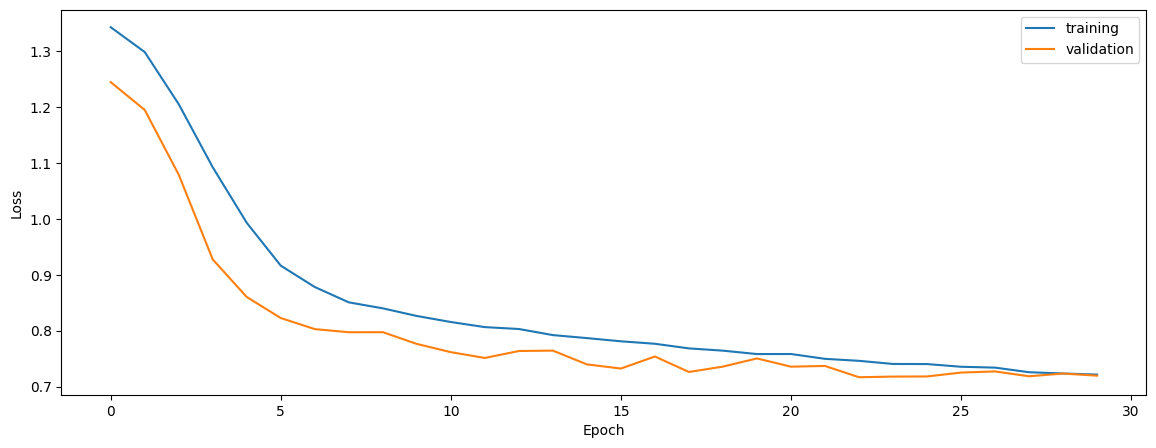

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.7074849798463761
0.7177011617900172
0.6985079185026831


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.7074849798463761
0.7177011617900172
0.6985079185026831


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7055760833053409
0.715590273957531
0.6951866590866023


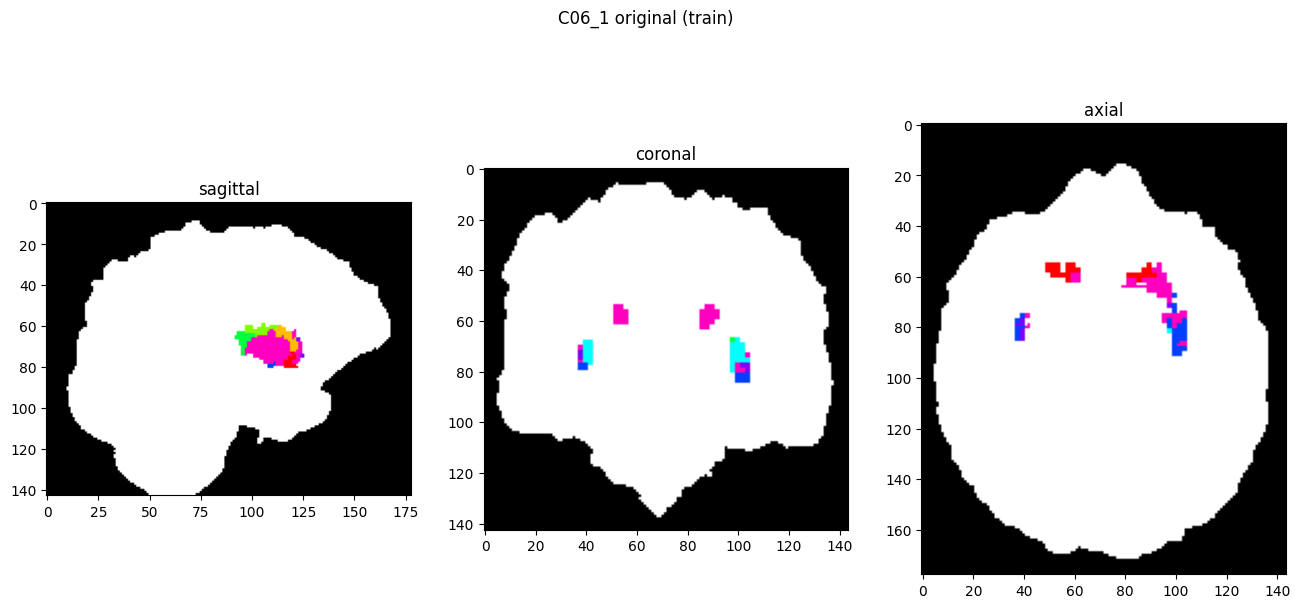

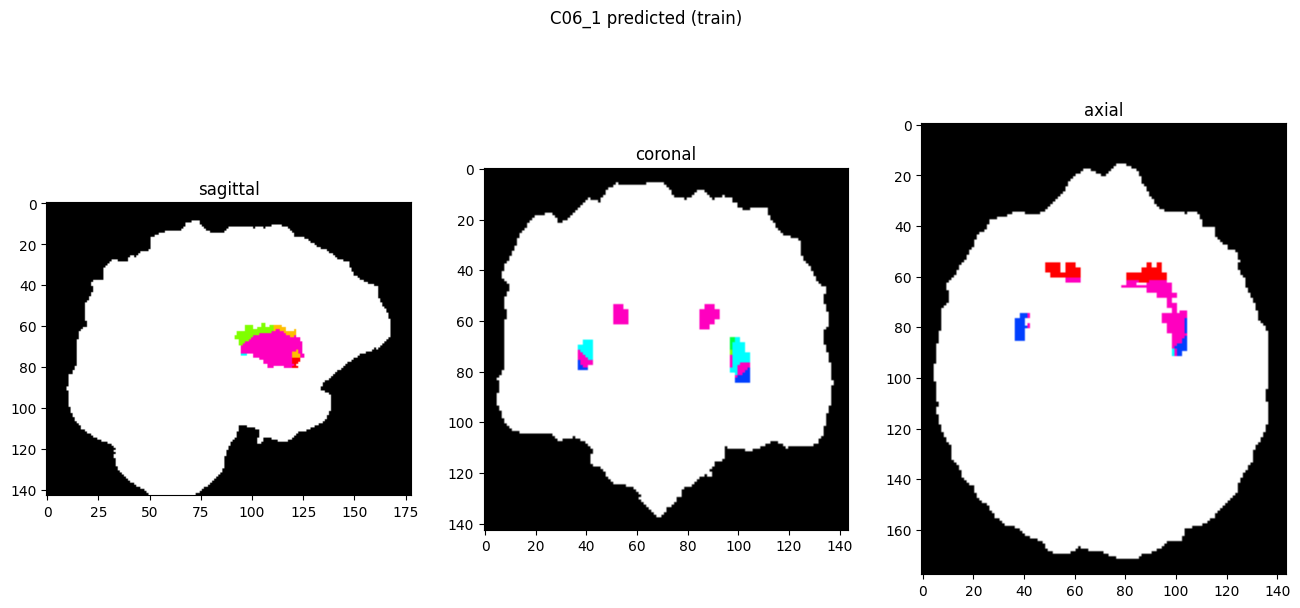

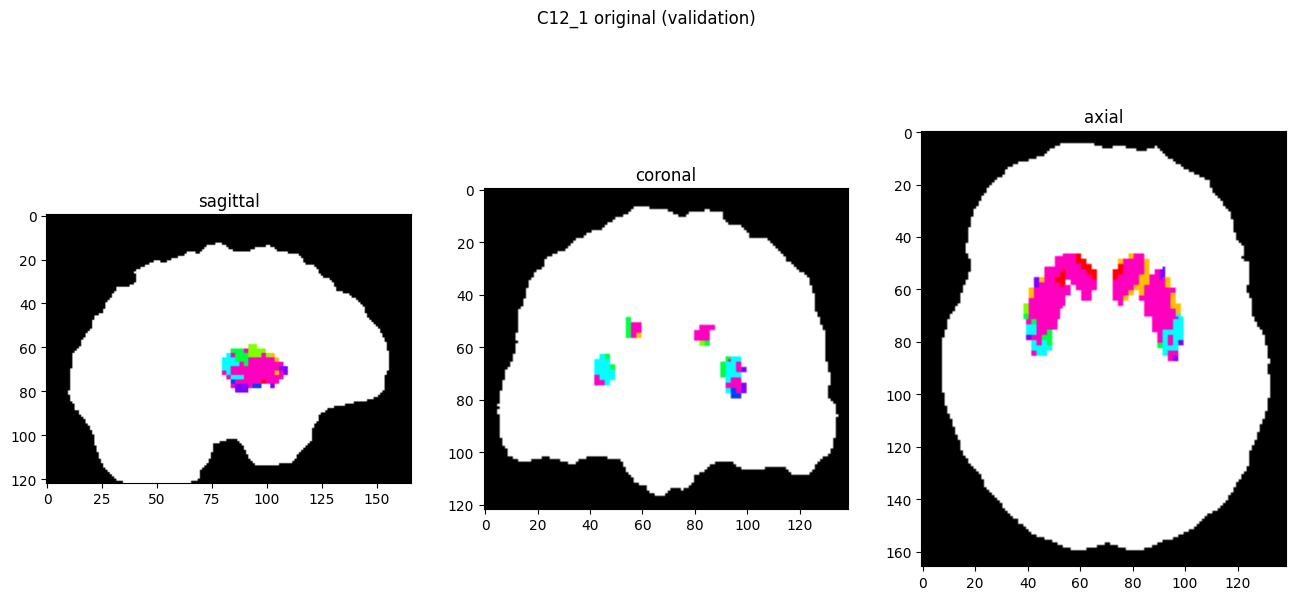

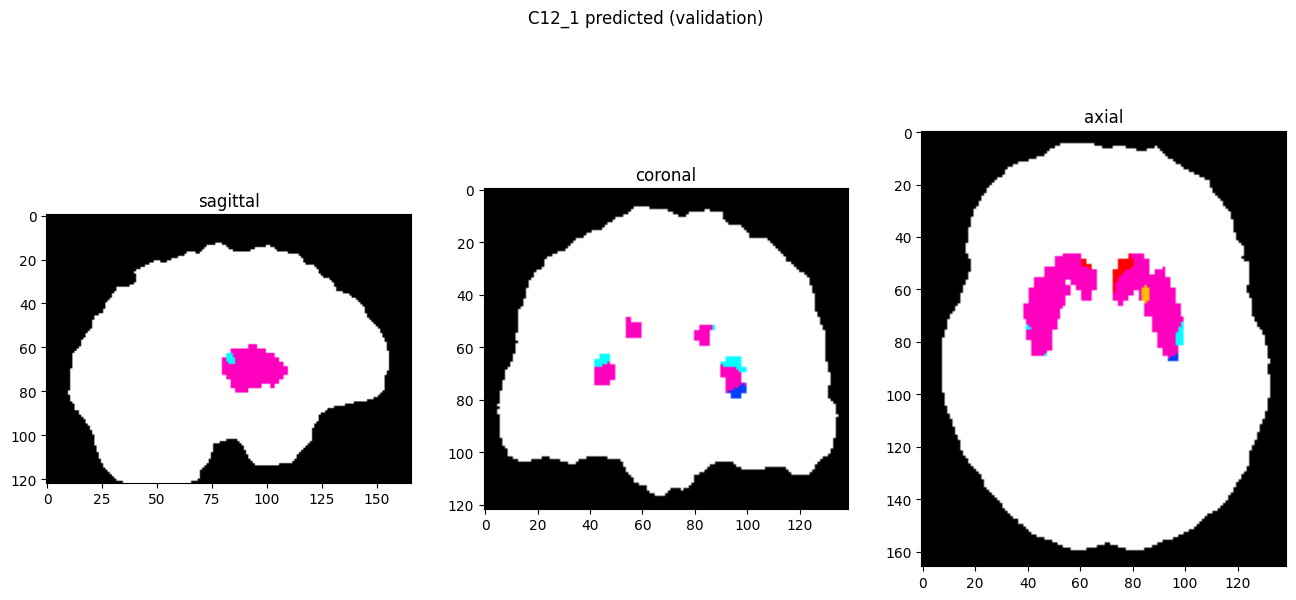

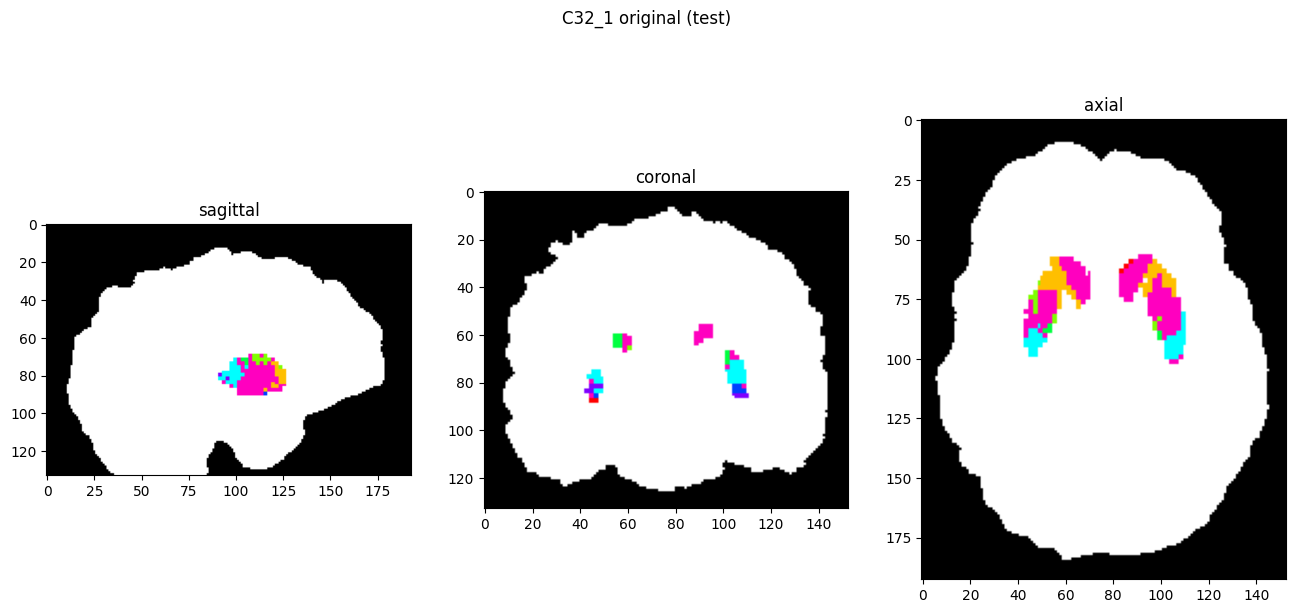

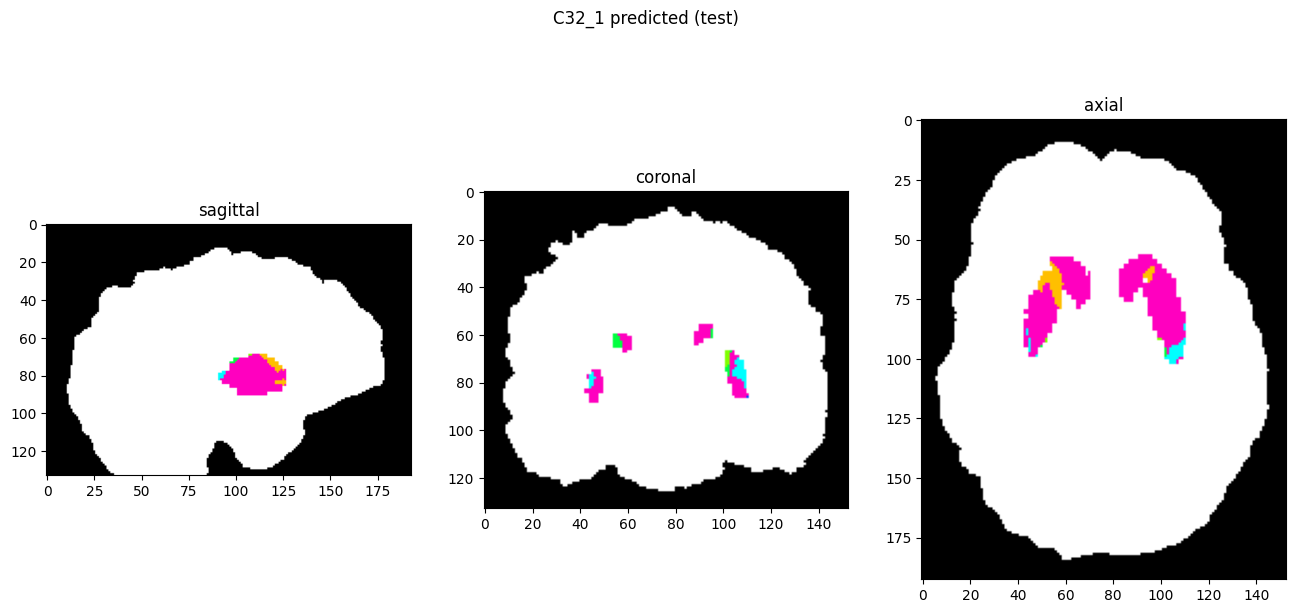

In [10]:
showResults(model, gen, threshold=0)